Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc
import networkx as nx

## Mobility of Countries

In [2]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(country_df):
    country_df = country_df[country_df['Participant Profile']=='Learner']
    country_df = country_df[country_df['Activity (mob)'].str.contains('Student')]
    country_df = country_df[~country_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(country_df.loc[:, 'Sending Country Code' ]), set(country_df.loc[:, 'Receiving Country Code']))))
    country_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
    country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
    # Adjacency matrix
    country_serie = country_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
    country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    
    # plotting gamma and linear fit for the degree distribution 
    from collections import Counter
    from statistics import mean

    d_in = scores['in degree']
    d_in = d_in[d_in>0]
    d_out = scores['out degree']
    d_out = d_out[d_out>0]
    kmin = 1000
    d2_in = d_in[d_in>kmin]
    d2_out = d_out[d_out>kmin]

    sorted_d = sorted(d_in)
    occurrence = Counter(sorted_d)
    x_in = list(occurrence.keys())
    y_in = list(occurrence.values())
    y_in = y_in/np.sum(y_in)

    sorted_d = sorted(d_out)
    occurrence = Counter(sorted_d)
    x_out = list(occurrence.keys())
    y_out = list(occurrence.values())
    y_out = y_out/np.sum(y_out)

    Pk_in = 1 - np.cumsum(y_in)
    Pk_in[-1] = 1 
    Pk_in = sorted(Pk_in, reverse = True)
    Pk_out = 1 - np.cumsum(y_out)
    Pk_out[-1] = 1 
    Pk_out = sorted(Pk_out, reverse = True)
    ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
    ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
    C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
    C_out = (ga_out-1)*kmin**(ga_out-1)

    pos_in = np.argmax(np.array(x_in)>=kmin)
    pos_out = np.argmax(np.array(x_out)>=kmin)

    P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
    pk_in = C_in*P_kmin_in*x_in**-ga_in
    Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

    P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
    pk_out = C_out*P_kmin_out*x_out**-ga_out
    Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 
    fig, ax = plt.subplots(2, 2, figsize = (30, 20))

    def plot_gamma(ax, x, y, title, p, cumulative=False):
        ax.loglog(x, y, 'o', markersize = 4)
        ax.loglog(x, p, color='orange')
        ax.grid(which='both', linestyle='--', linewidth=0.5)
        ax.set_title(title, size = 22)
        ax.set_xlabel("k", size = 20)
        if cumulative:
            ax.set_ylabel("P_k", size = 20)
        else:
            ax.set_ylabel("p_k", size = 20)
        ax.tick_params(labelsize=18)
        ax.tick_params(labelsize=18)

    plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
    plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
    plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
    plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
    plt.show()
    print('gamma_in = ' + str(ga_in))
    print('gamma_out = ' + str(ga_out))
    
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    
    
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = country_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = country_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    
    # Communities
    G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
    p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
    node_comm = nodes_df.copy()
    node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
    for i, s in enumerate(p):
        for element in s:
            node_comm.iat[element, 1]=i
    for i, s in enumerate(p):
        display(node_comm[node_comm['Community']==i])
        
    # Geographic Heatmaps
    # adding code country to scores dataframe
    countries_codes = nodes_df
    countries_codes['code'] = nodes
    scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

    # adding Switzerland since there is no Erasmus data
    sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
           'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
           'out degree position':0, 'hits hub position':0, 'hits autority position':0,
           'PageRank hub position':0, 'PageRank authority position':0}
    scores_merge = scores_merge.append(sw, ignore_index = True)

    merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
    merged_df.dropna(subset=['Nodes'], inplace=True)
    
    # focus on eu countries
    european_df = merged_df[merged_df['country'].isin(european_countries)]
    
    plt_list = ['PageRank hub', 'PageRank authority']
    fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

    for i in range(len(plt_list)):
        european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
        sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
        ax4[i].axis('off')
        fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
        ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
        
    # PageRank weighted on the total students enrolled in 2016 in
    # ISCED 5-7 (tertiary education and master degree) for each country
    european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
    european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')
    print('Top 10 countries for students enrollment')
    display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))
    european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
    european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

    # threshold set because some countries had too big values wrt the average
    european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
    european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)

    eu_w_copy = european_df_w.copy()
    eu_w_copy.dropna(inplace = True)
    # Countries ordered by weighted PageRank hub score
    eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
    eu_w_copy.reset_index(drop=True, inplace=True)
    display(eu_w_copy[['country', 'weight_pr_hub']])
    # Countries ordered by weighted PageRank authority score
    eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
    eu_w_copy.reset_index(drop=True, inplace=True)
    display(eu_w_copy[['country', 'weight_pr_aut']])
    
    fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
    plt_list = ['weight_pr_hub', 'weight_pr_aut']
    for i in range(len(plt_list)):
        european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
        sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                                  vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
        ax7[i].axis('off')
        fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
        ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
        
    # Geographic plot for Communities
    node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
    node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
    node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

    eu_communities = european_df.copy()
    eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

    fig5, ax5 = plt.subplots(figsize=(10,10))
    eu_communities.plot(column='Community', ax=ax5, edgecolor='0.5', linewidth=0.3, cmap='Pastel1')
    ax5.axis('off')
    ax5.set_title('European countries - Commmunity', fontsize=15)

In [3]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))
geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# list to focus only the european countries
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

# representation of weighted PageRank values, based on the total students enrolled in 2016 in
# ISCED 5-7 (tertiary education and master degree) for each country
isced57_df = pd.read_csv("eter-export-2016_loc.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()
        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

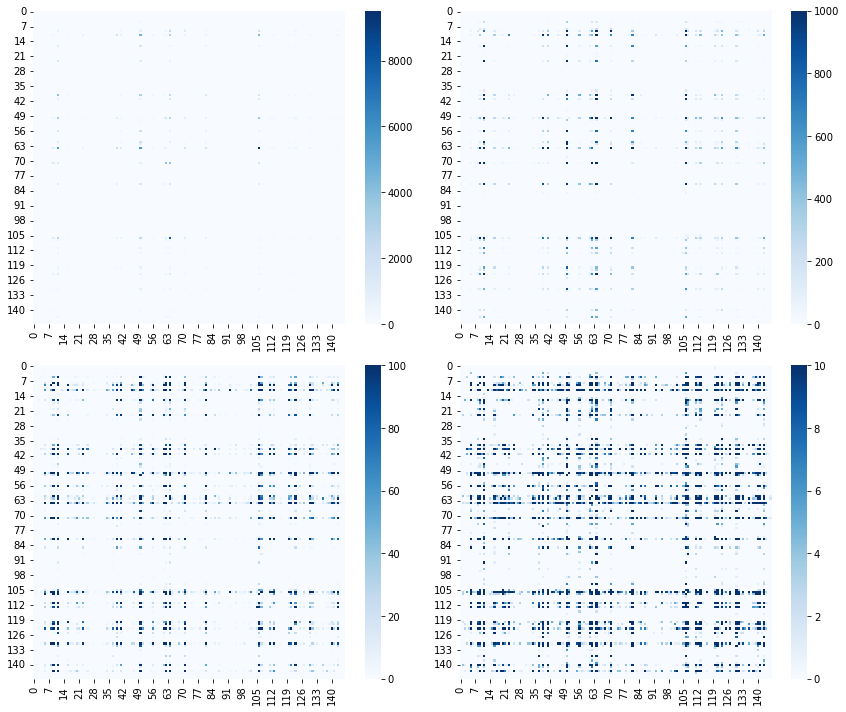

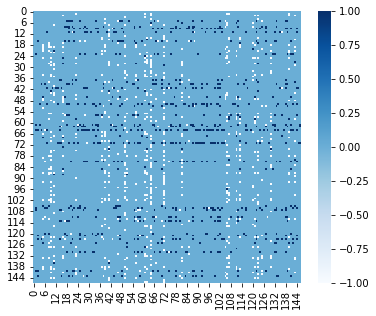

Number of components = 2


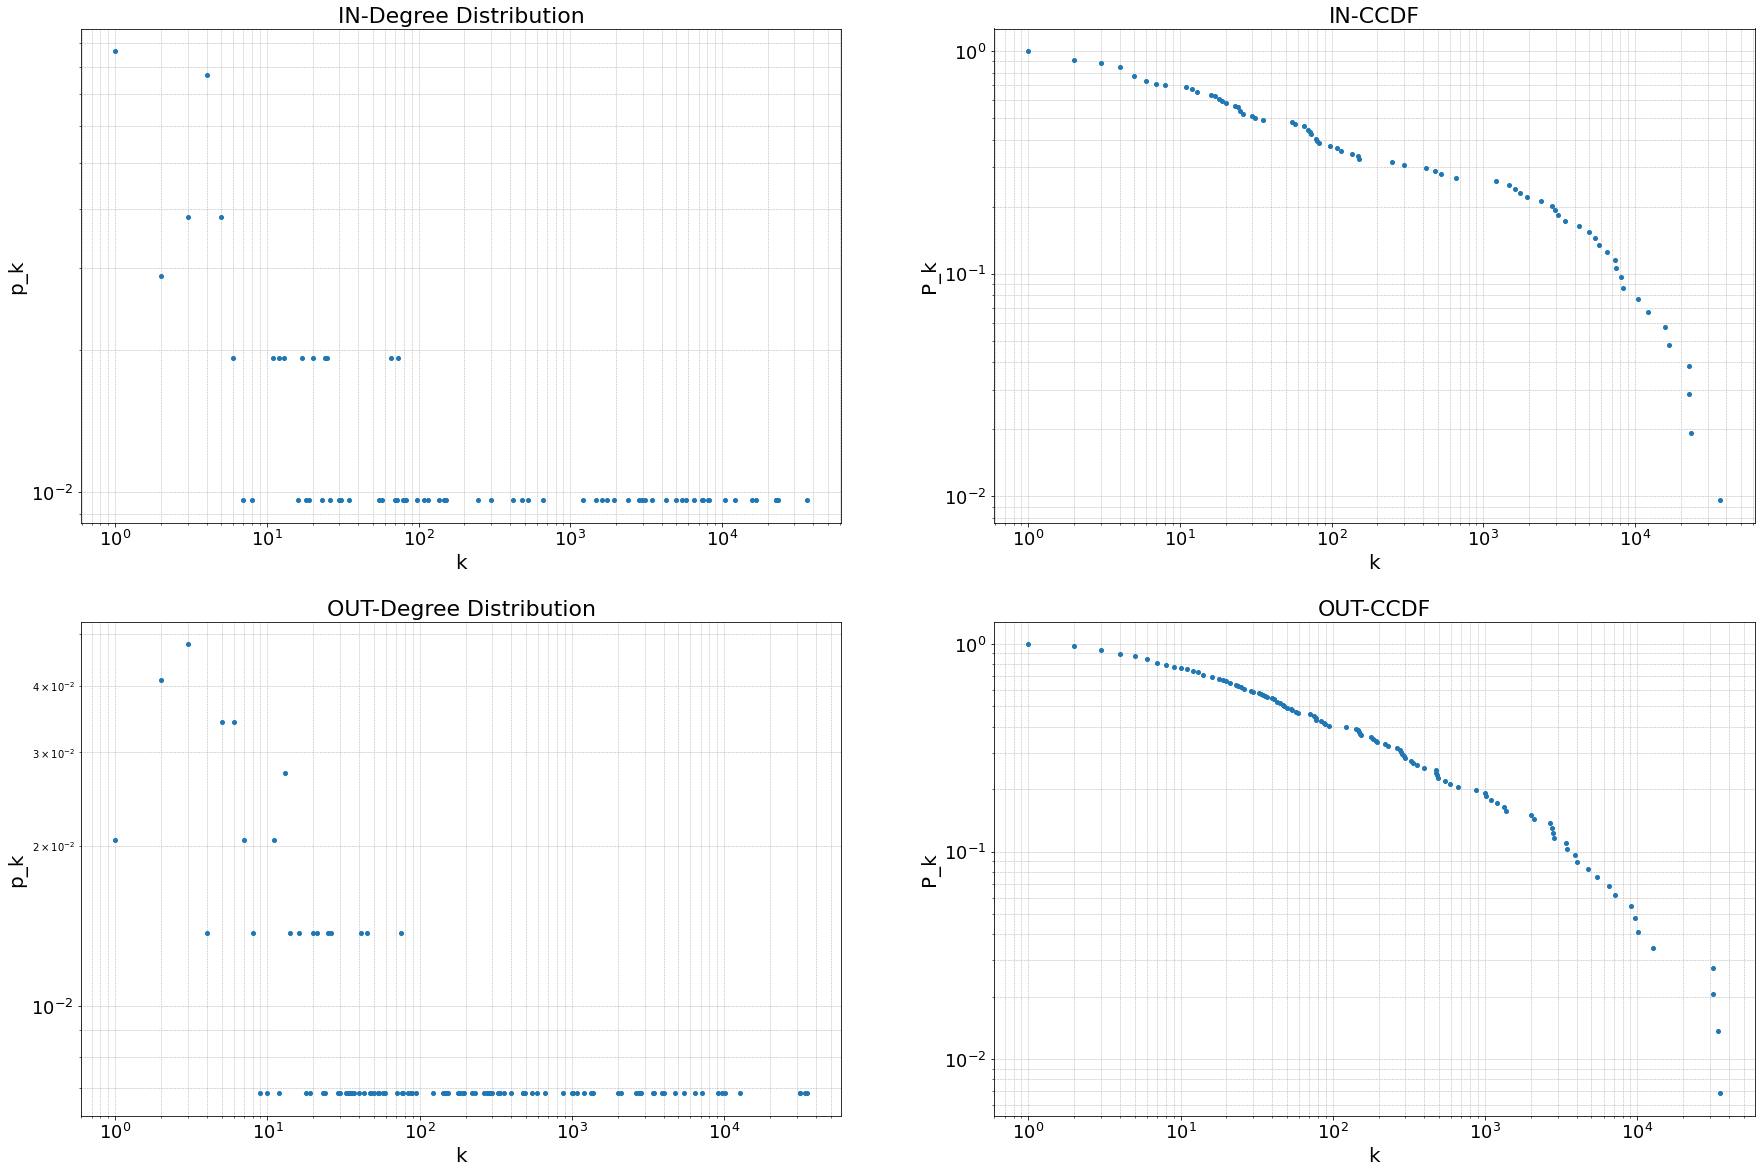

Top 10 for in degree


Nodes  in degree
64         Spain      36263
106        Italy      23344
11        France      22790
50       Germany      22538
39            UK      16849
71        Poland      15750
9       Portugal      12151
81   Netherlands      10510
56        Sweden       8268
123      Czechia       8079

Top 10 for out degree


Nodes  out degree
64         Spain       34913
50       Germany       33931
106        Italy       31591
11        France       31235
62        Turkey       12738
81   Netherlands       10144
71        Poland        9630
39            UK        9086
9       Portugal        7144
41       Belgium        6471

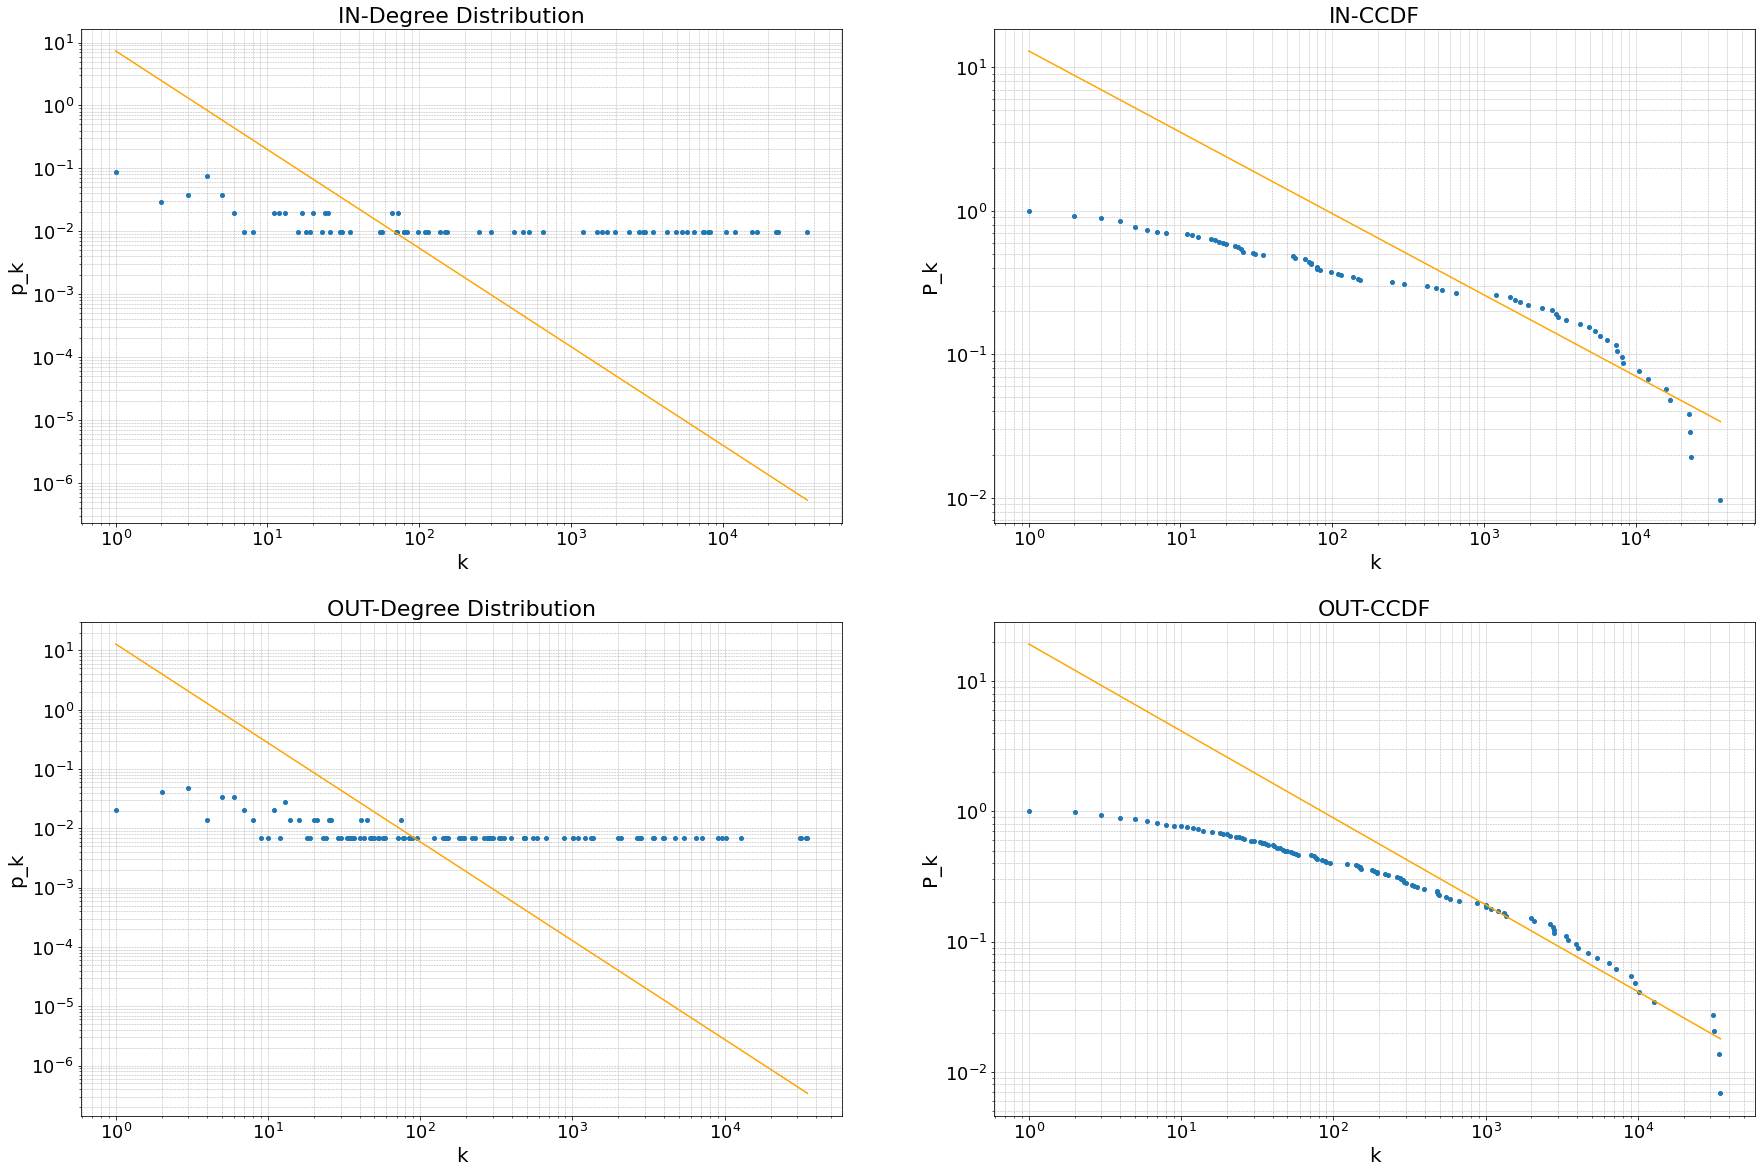

gamma_in = 1.5664993589080134
gamma_out = 1.6672702199678153


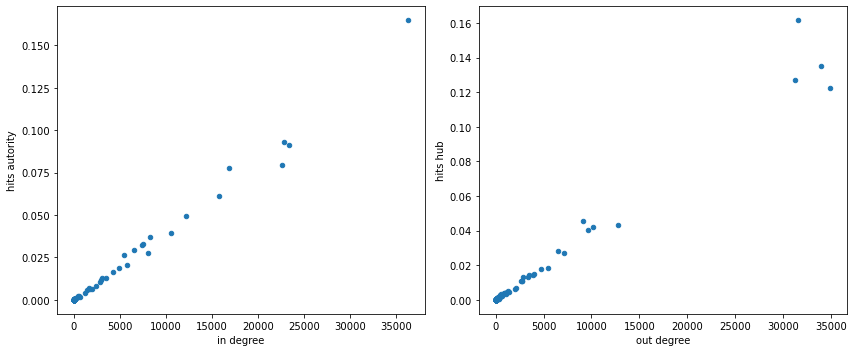

Top 10 for hits hub


Nodes  hits hub
106        Italy  0.161576
50       Germany  0.135408
11        France  0.127085
64         Spain  0.122200
39            UK  0.045554
62        Turkey  0.043050
81   Netherlands  0.042306
71        Poland  0.040657
41       Belgium  0.028275
9       Portugal  0.027016

Top 10 for hits autority


Nodes  hits autority
64         Spain       0.164803
11        France       0.093283
106        Italy       0.091191
50       Germany       0.079345
39            UK       0.077596
71        Poland       0.061080
9       Portugal       0.049354
81   Netherlands       0.039346
56        Sweden       0.036828
61       Finland       0.033024

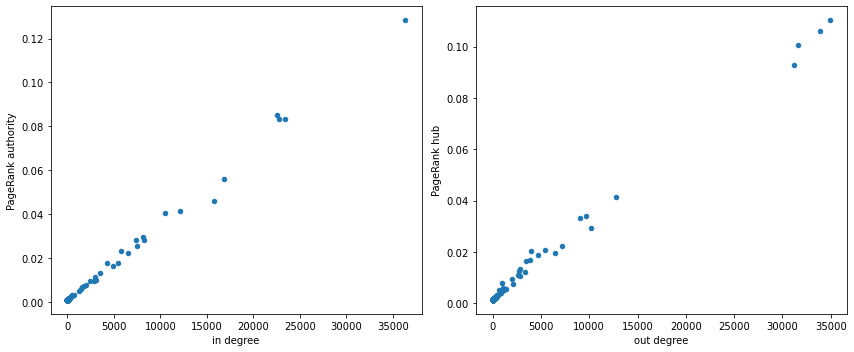

Top 10 for PageRank hub


Nodes  PageRank hub
64         Spain      0.110257
50       Germany      0.105996
106        Italy      0.100815
11        France      0.093048
62        Turkey      0.041473
71        Poland      0.033889
39            UK      0.033424
81   Netherlands      0.029289
9       Portugal      0.022390
123      Czechia      0.020962

Top 10 for PageRank authority


Nodes  PageRank authority
64         Spain            0.128283
50       Germany            0.084965
106        Italy            0.083311
11        France            0.083270
39            UK            0.056150
71        Poland            0.046034
9       Portugal            0.041512
81   Netherlands            0.040408
123      Czechia            0.029744
41       Belgium            0.028452

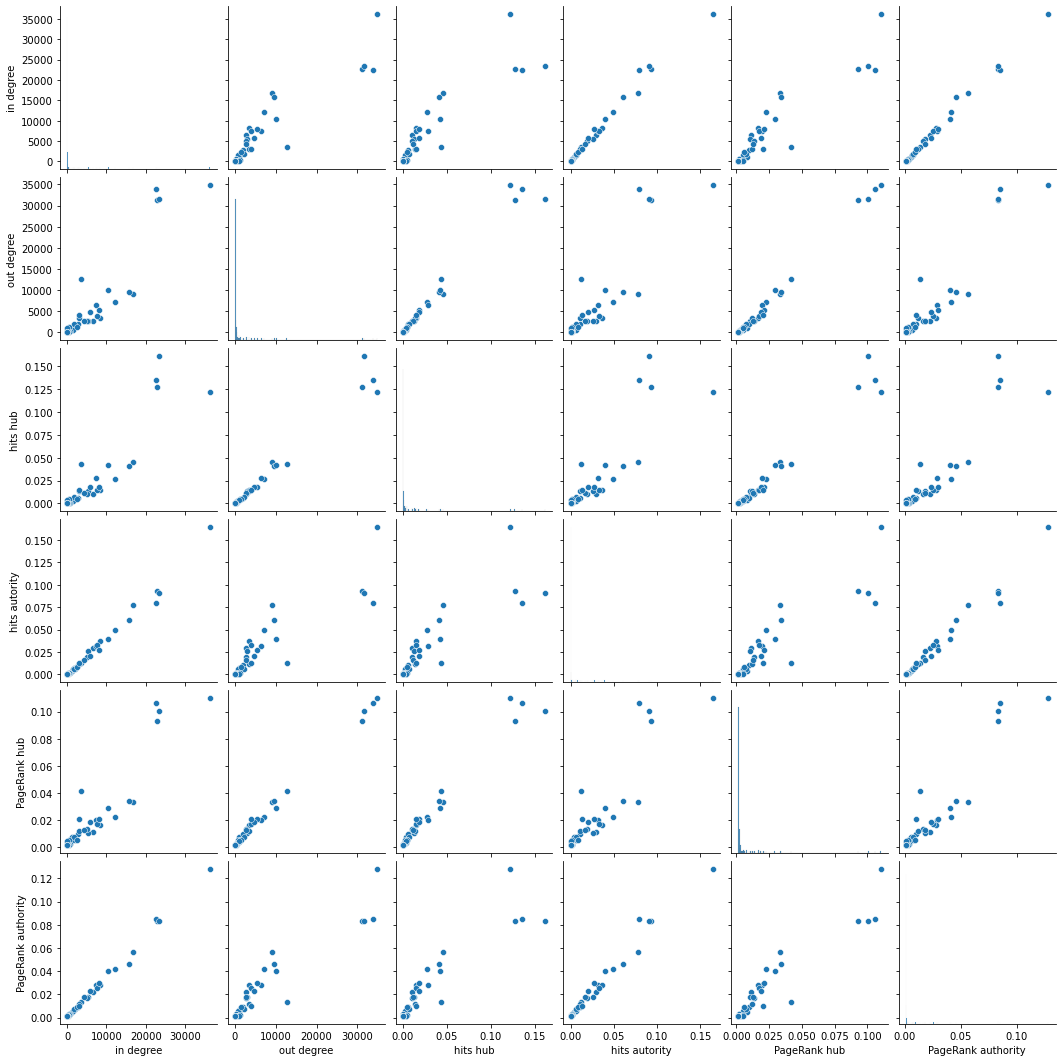

Nodes  in degree  in degree position  hits autority  \
64                Spain      36263                   1       0.164803   
50              Germany      22538                   4       0.079345   
106               Italy      23344                   2       0.091191   
11               France      22790                   3       0.093283   
39                   UK      16849                   5       0.077596   
71               Poland      15750                   6       0.061080   
9              Portugal      12151                   7       0.049354   
81          Netherlands      10510                   8       0.039346   
123             Czechia       8079                  10       0.027760   
41              Belgium       7416                  12       0.032101   
56               Sweden       8268                   9       0.036828   
61              Finland       7517                  11       0.033024   
130             Austria       5808                  14       0.020285   
16               Norway       6494                  13       0.029125   
23              Ireland       5419                  15       0.026383   
120             Denmark       4293                  17       0.016299   
111             Hungary       4948                  16       0.018998   
62               Turkey       3461                  18       0.012586   
113                  EL       2975                  20       0.011472   
143             Romania       3090                  19       0.012937   
107           Lithuania       2826                  21       0.010807   
140            Slovenia       2402                  22       0.008168   
8               Croatia       1949                  23       0.006518   
121            Slovakia       1735                  24       0.006356   
5                Latvia       1615                  25       0.006811   
51              Estonia       1478                  26       0.006028   
37             Bulgaria       1204                  27       0.004279   
105              Cyprus        659                  28       0.001930   
125             Iceland        528                  29       0.002094   
131  Russian Federation        483                  30       0.001973   
85                Malta        421                  31       0.001527   
68               Israel        298                  32       0.001121   
46           Luxembourg        152                  34       0.000671   
20               Serbia        248                  33       0.000994   
58               Canada        115                  37       0.000421   
17        United States        137                  36       0.000587   
136     North Macedonia        148                  35       0.000588   
21               Jordan        109                  38       0.000457   
127               China         70                  46       0.000134   
141             Ukraine         73                  43       0.000168   

     hits autority position  PageRank authority  PageRank authority position  
64                        1            0.128283                            1  
50                        4            0.084965                            2  
106                       3            0.083311                            3  
11                        2            0.083270                            4  
39                        5            0.056150                            5  
71                        6            0.046034                            6  
9                         7            0.041512                            7  
81                        8            0.040408                            8  
123                      13            0.029744                            9  
41                       11            0.028452                           10  
56                        9            0.028061                           11  
61                       10            0.025517                           12

Nodes  out degree  out degree position  hits hub  \
64                    Spain       34913                    1  0.122200   
50                  Germany       33931                    2  0.135408   
106                   Italy       31591                    3  0.161576   
11                   France       31235                    4  0.127085   
62                   Turkey       12738                    5  0.043050   
71                   Poland        9630                    7  0.040657   
39                       UK        9086                    8  0.045554   
81              Netherlands       10144                    6  0.042306   
9                  Portugal        7144                    9  0.027016   
123                 Czechia        5412                   11  0.018478   
143                 Romania        4021                   13  0.015054   
41                  Belgium        6471                   10  0.028275   
130                 Austria        4728                   12  0.017966   
61                  Finland        3906                   14  0.014616   
56                   Sweden        3455                   15  0.014486   
111                 Hungary        2794                   18  0.010795   
120                 Denmark        2767                   19  0.011163   
113                      EL        3396                   16  0.013430   
16                   Norway        2651                   20  0.010680   
23                  Ireland        2828                   17  0.013306   
107               Lithuania        1999                   22  0.006061   
37                 Bulgaria        1011                   27  0.003661   
121                Slovakia        2092                   21  0.006650   
5                    Latvia        1086                   26  0.003244   
140                Slovenia        1367                   23  0.004798   
8                   Croatia        1325                   24  0.005102   
131      Russian Federation        1201                   25  0.004732   
51                  Estonia         669                   30  0.002310   
141                 Ukraine        1004                   28  0.003845   
20                   Serbia         875                   29  0.003816   
92                  Tunisia         587                   31  0.003173   
47                  Georgia         548                   32  0.002217   
112                 Albania         478                   36  0.001829   
34   Bosnia and Herzegovina         487                   34  0.002040   
102                 Morocco         491                   33  0.002553   
46               Luxembourg         479                   35  0.001955   
136         North Macedonia         300                   41  0.000595   
68                   Israel         397                   37  0.001503   
21                   Jordan         327                   40  0.001078   
127                   China         338                   39  0.001296   

     hits hub position  PageRank hub  PageRank hub position  
64                   4      0.110257                      1  
50                   2      0.105996                      2  
106                  1      0.100815                      3  
11                   3      0.093048                      4  
62                   6      0.041473                      5  
71                   8      0.033889                      6  
39                   5      0.033424                      7  
81                   7      0.029289                      8  
9                   10      0.022390                      9  
123                 11      0.020962                     10  
143                 13      0.020560                     11  
41                   9      0.019769                     12  
130                 12      0.018680                     13  
61                  14      0.016837                     14  
56                  15      0.016523                     

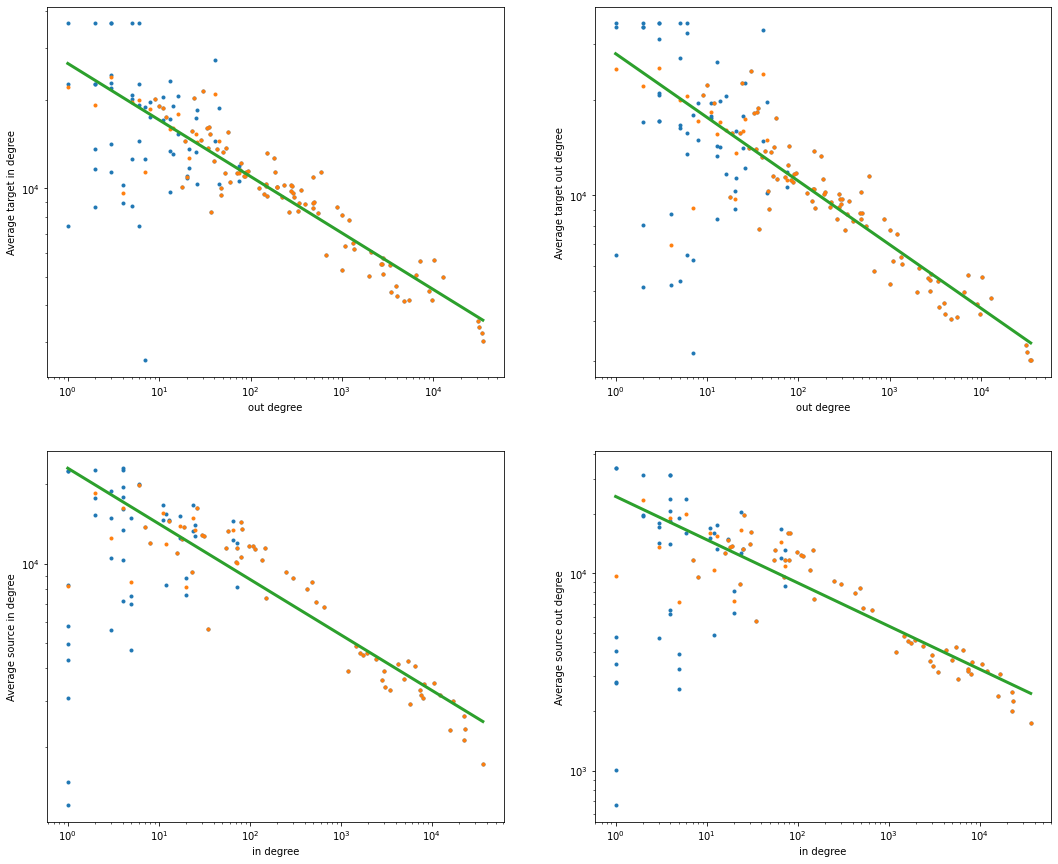

(-0.19190430299796604, -0.201005823903545, -0.2114176952655288, -0.21856149732297478)


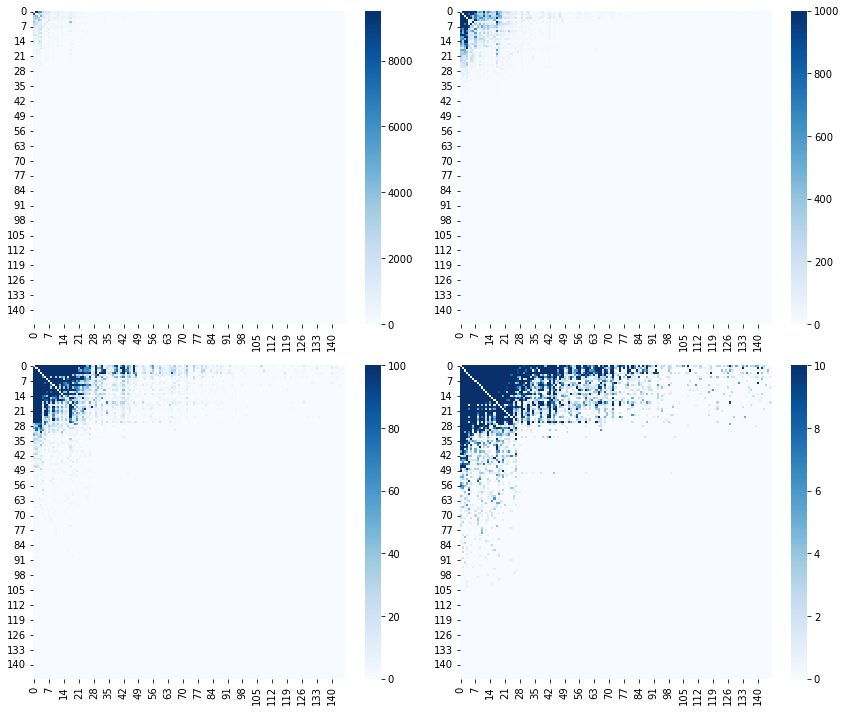

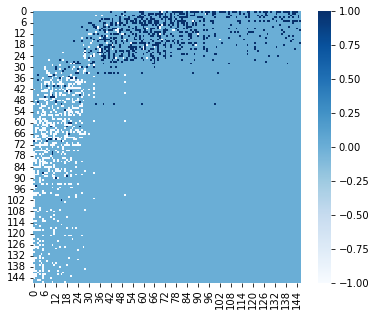

Nodes  Community
2               Sri Lanka          0
3               Hong Kong          0
6             New Zealand          0
7                Cameroon          0
10                 Gambia          0
..                    ...        ...
137                Belize          0
138  Moldova, Republic of          0
143               Romania          0
144                Bhutan          0
145              Suriname          0

[69 rows x 2 columns]

Nodes  Community
5                Latvia          1
8               Croatia          1
9              Portugal          1
16               Norway          1
17        United States          1
..                  ...        ...
129               Gabon          1
131  Russian Federation          1
133                  XK          1
140            Slovenia          1
141             Ukraine          1

[57 rows x 2 columns]

Nodes  Community
1            Bangladesh          2
4                Zambia          2
14   Dominican Republic          2
18           Montenegro          2
26                Sudan          2
27                 Peru          2
45             Pakistan          2
62               Turkey          2
65           Azerbaijan          2
66                Kenya          2
80              Lebanon          2
88   Korea, Republic of          2
98          El Salvador          2
104    Papua New Guinea          2
107           Lithuania          2
123             Czechia          2
132               Ghana          2
139             Belarus          2
142             Nigeria          2
146             Uruguay          2

Nodes  Community
0   nan          3

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
17          Turkey                          7107650.0
13         Germany                          2625241.0
10  United Kingdom                          2263020.0
23           Italy                          1797986.0
18           Spain                          1491419.0
20          Poland                          1418588.0
21     Netherlands                           720583.0
27          Greece                           704969.0
15          Sweden                           438578.0
2         Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.672427e-07
3          Romania   1.524939e-07
4          Estonia   1.133660e-07
5         Slovenia   1.086155e-07
6          Belgium   8.570608e-08
7        Lithuania   8.260642e-08
8           Latvia   7.601893e-08
9            Spain   7.392743e-08
10         Czechia   7.067111e-08
11        Portugal   6.921876e-08
12        Slovakia   6.734856e-08
13         Finland   6.085745e-08
14       Macedonia   5.703170e-08
15           Italy   5.607120e-08
16         Ireland   5.241397e-08
17         Denmark   4.944061e-08
18         Hungary   4.859938e-08
19          Norway   4.116854e-08
20     Netherlands   4.064640e-08
21         Germany   4.037578e-08
22          Sweden   3.767413e-08
23         Croatia   3.531952e-08
24        Bulgaria   3.376328e-08
25          Poland   2.388935e-08
26         Albania   2.317336e-08
27          Greece   1.729928e-08
28          Serbia   1.722992e-08
29  United Kingdom   1.476970e-08
30          Turkey   5.834922e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.939959e-07
3         Slovenia   1.797711e-07
4          Estonia   1.334071e-07
5         Portugal   1.283355e-07
6          Belgium   1.233476e-07
7          Czechia   1.002792e-07
8          Finland   9.223439e-08
9          Ireland   8.955316e-08
10          Latvia   8.858606e-08
11           Spain   8.601409e-08
12       Lithuania   8.334065e-08
13          Norway   8.292957e-08
14         Romania   7.377618e-08
15         Denmark   6.832701e-08
16        Slovakia   6.433085e-08
17          Sweden   6.398171e-08
18         Hungary   5.923545e-08
19     Netherlands   5.607658e-08
20         Croatia   4.713820e-08
21           Italy   4.633587e-08
22          Poland   3.245045e-08
23         Germany   3.236449e-08
24       Macedonia   2.937487e-08
25  United Kingdom   2.481206e-08
26        Bulgaria   2.253805e-08
27          Greece   1.629953e-08
28         Albania   9.170029e-09
29          Serbia   7.748081e-09
30          Turkey   1.866223e-09
31     Switzerland   0.000000e+00

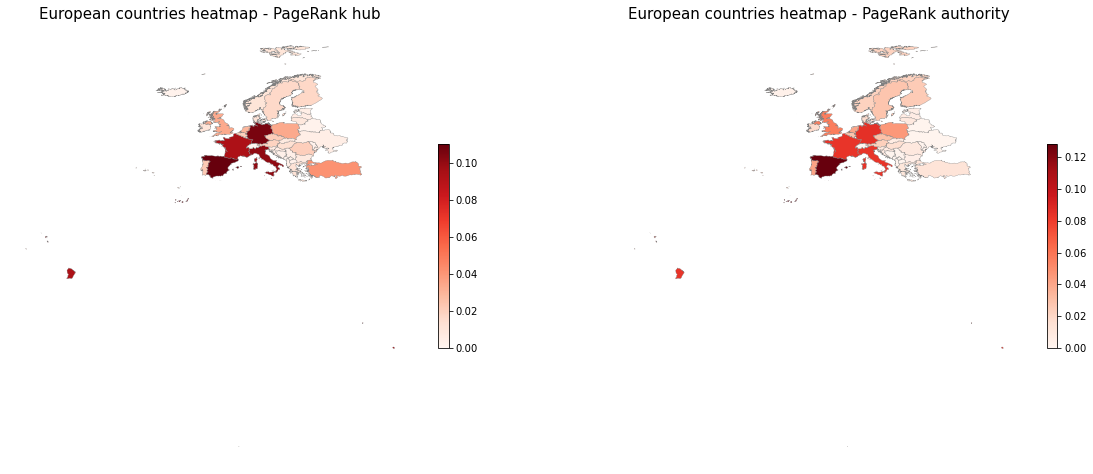

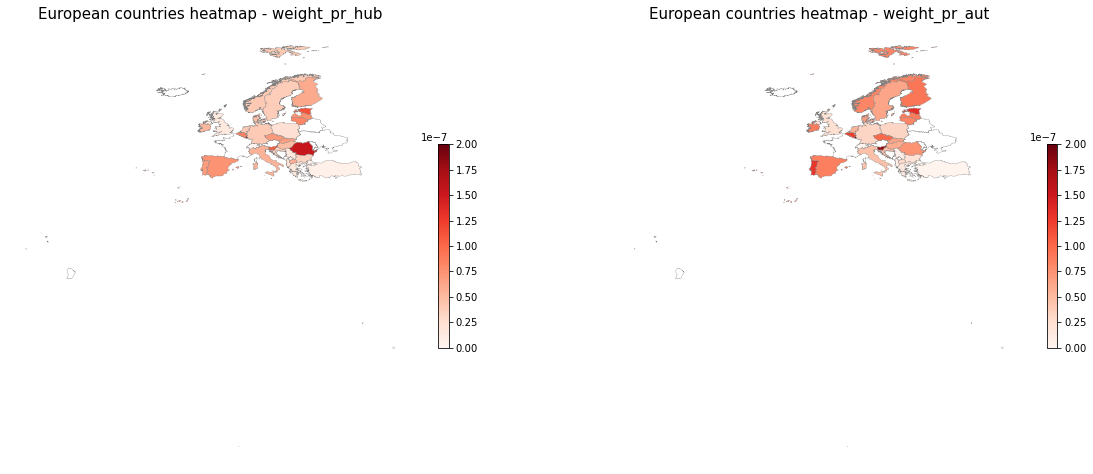

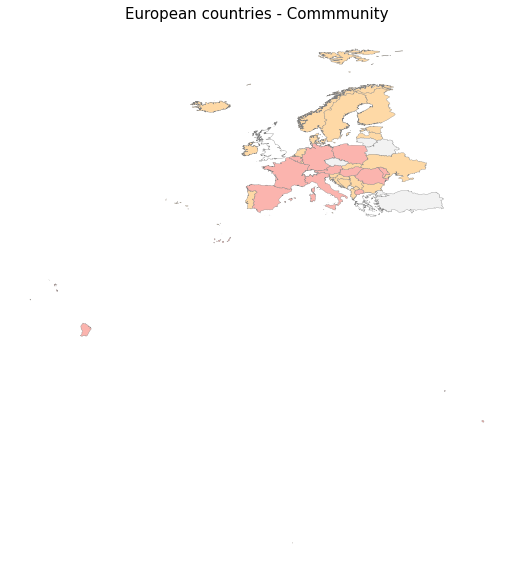

In [4]:
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country19_df)

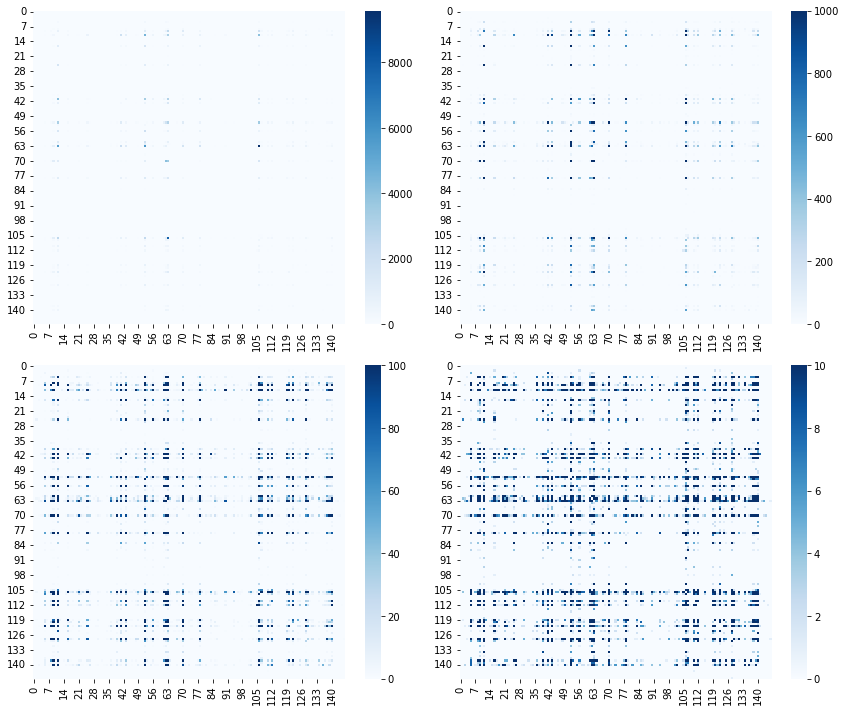

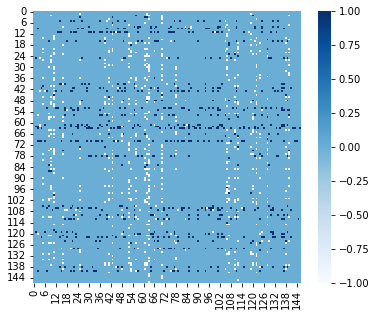

Number of components = 2


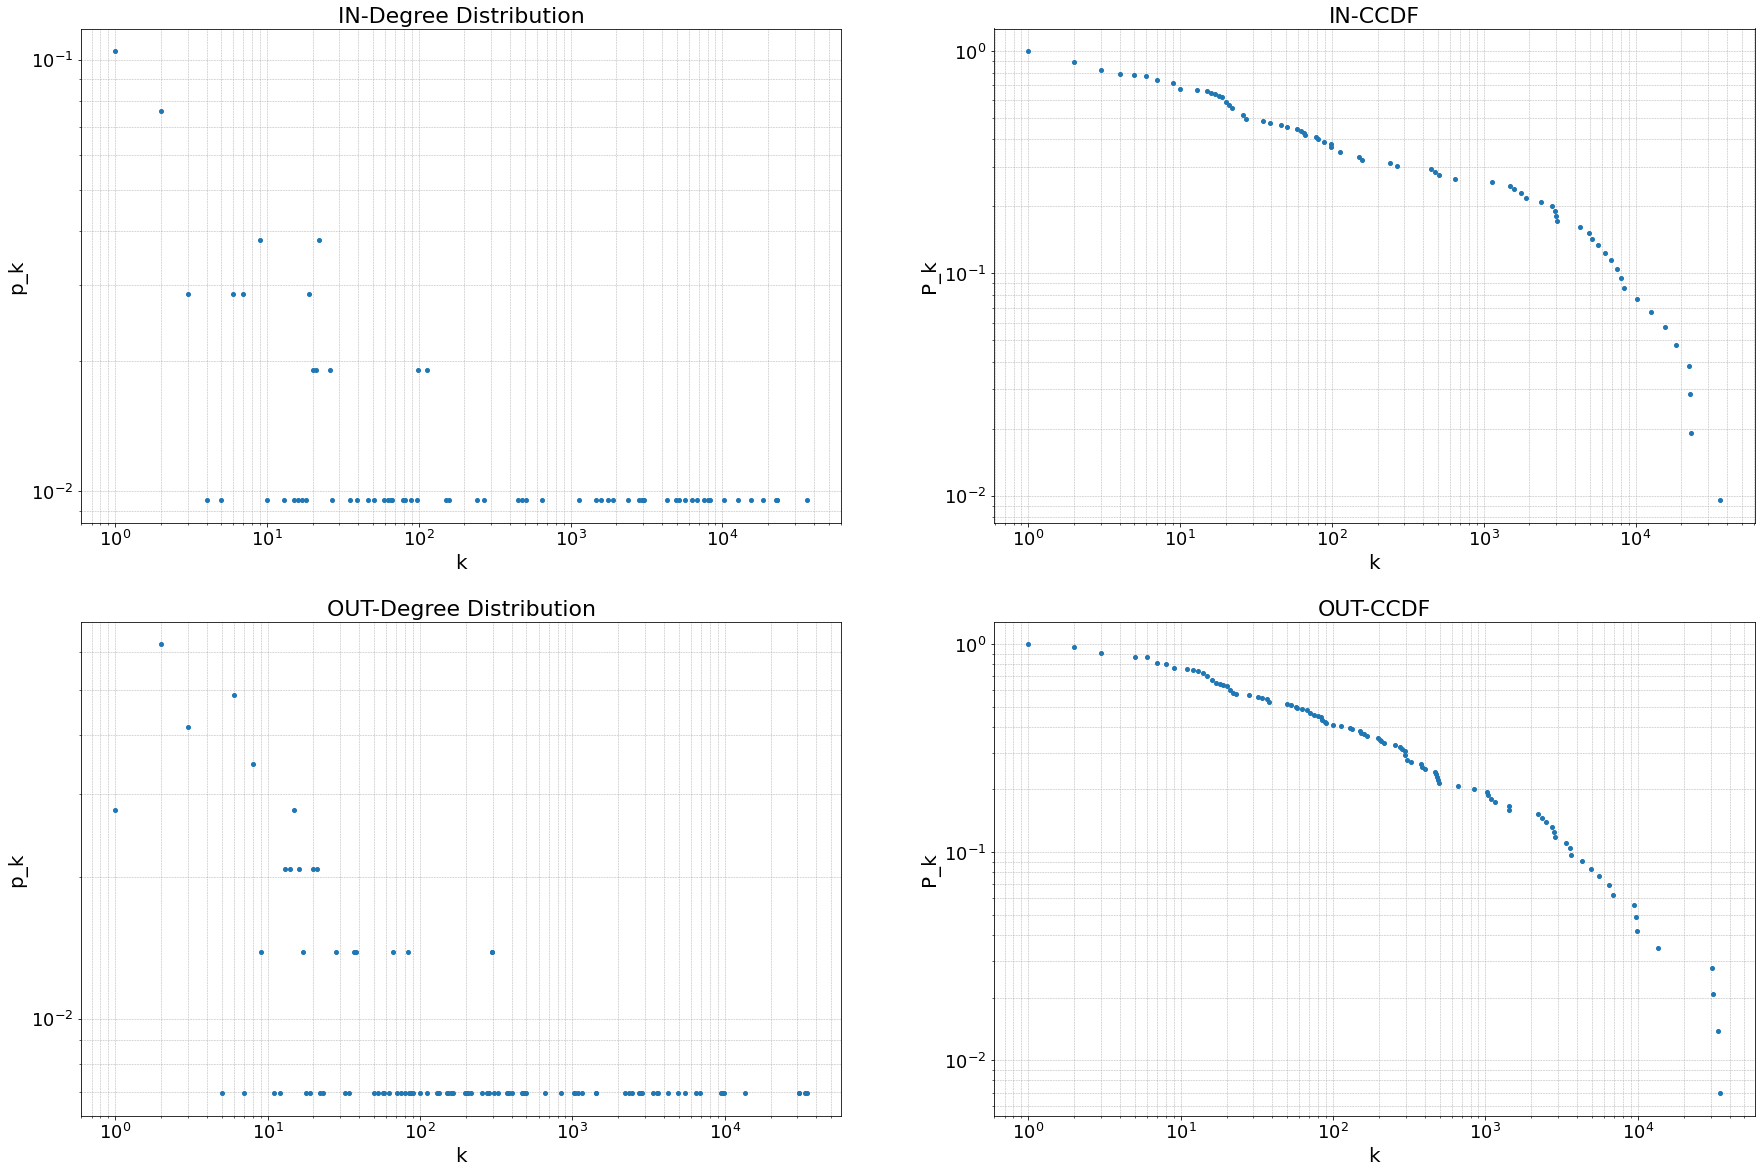

Top 10 for in degree


Nodes  in degree
63         Spain      36020
11        France      23047
52       Germany      22906
106        Italy      22627
41            UK      18474
70        Poland      15539
9       Portugal      12585
78   Netherlands      10198
122      Czechia       8342
56        Sweden       8079

Top 10 for out degree


Nodes  out degree
63         Spain       34630
52       Germany       33780
106        Italy       30947
11        France       30554
62        Turkey       13510
78   Netherlands        9843
70        Poland        9775
41            UK        9395
9       Portugal        6862
43       Belgium        6511

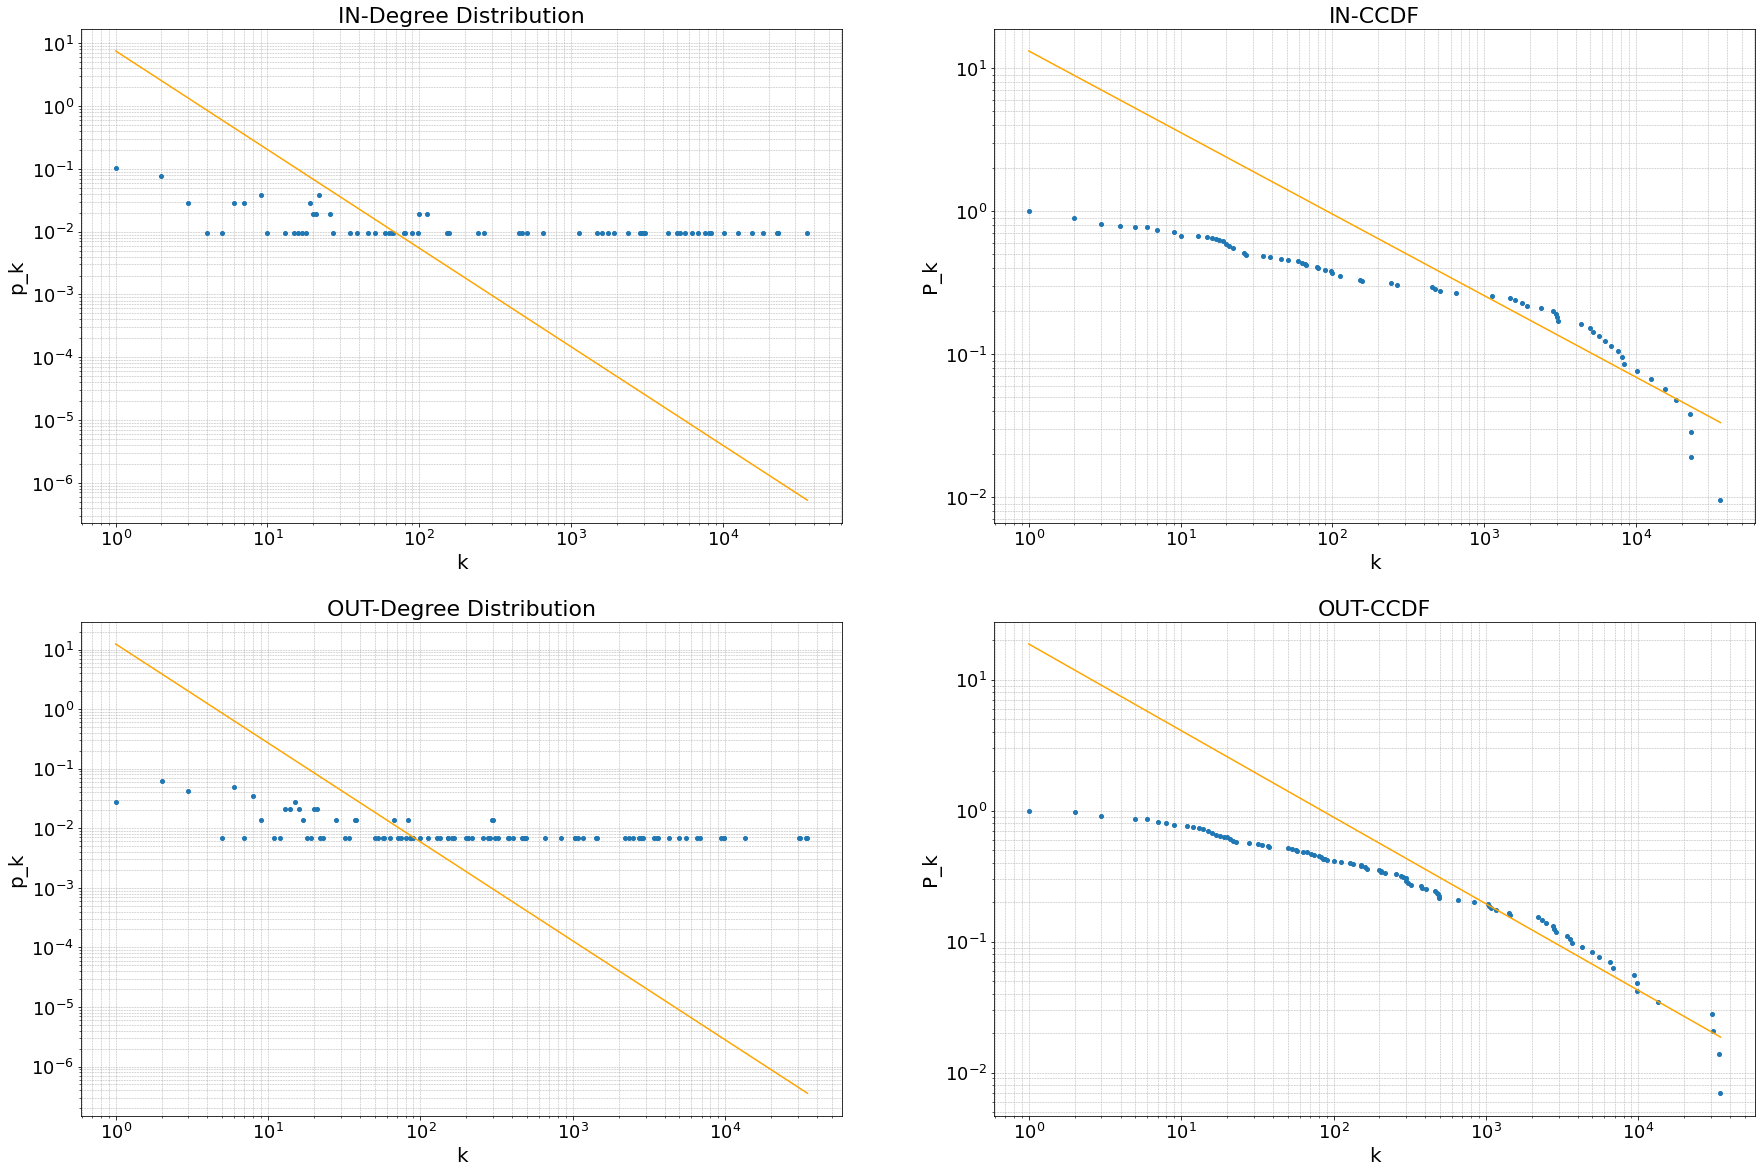

gamma_in = 1.57050450951441
gamma_out = 1.6613763046746546


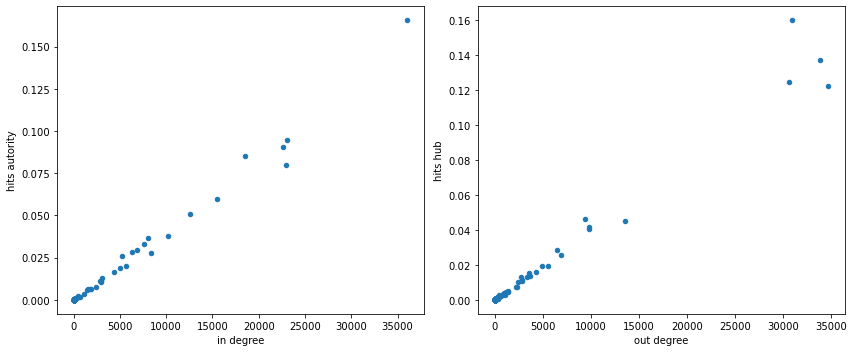

Top 10 for hits hub


Nodes  hits hub
106        Italy  0.160041
52       Germany  0.137508
11        France  0.124890
63         Spain  0.122369
41            UK  0.046538
62        Turkey  0.045017
78   Netherlands  0.041869
70        Poland  0.040729
43       Belgium  0.028681
9       Portugal  0.025886

Top 10 for hits autority


Nodes  hits autority
63         Spain       0.165548
11        France       0.094907
106        Italy       0.090780
41            UK       0.085221
52       Germany       0.079958
70        Poland       0.059830
9       Portugal       0.050634
78   Netherlands       0.037921
56        Sweden       0.036803
61       Finland       0.033260

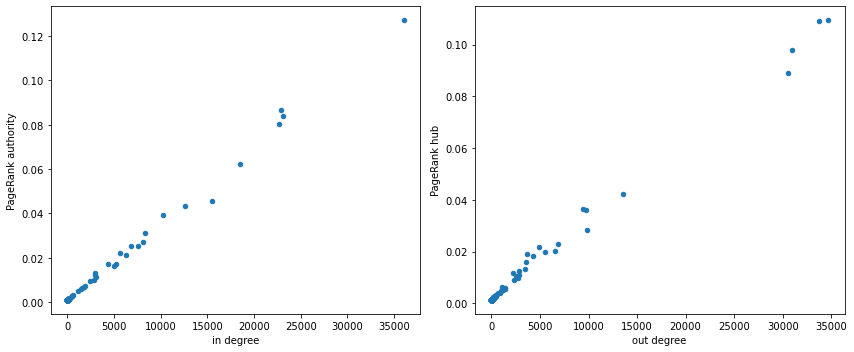

Top 10 for PageRank hub


Nodes  PageRank hub
63         Spain      0.109364
52       Germany      0.109099
106        Italy      0.097924
11        France      0.089084
62        Turkey      0.042240
41            UK      0.036373
70        Poland      0.036089
78   Netherlands      0.028372
9       Portugal      0.023053
128      Austria      0.021770

Top 10 for PageRank authority


Nodes  PageRank authority
63         Spain            0.127053
52       Germany            0.086534
11        France            0.083933
106        Italy            0.080115
41            UK            0.062336
70        Poland            0.045379
9       Portugal            0.043211
78   Netherlands            0.039211
122      Czechia            0.031170
56        Sweden            0.027315

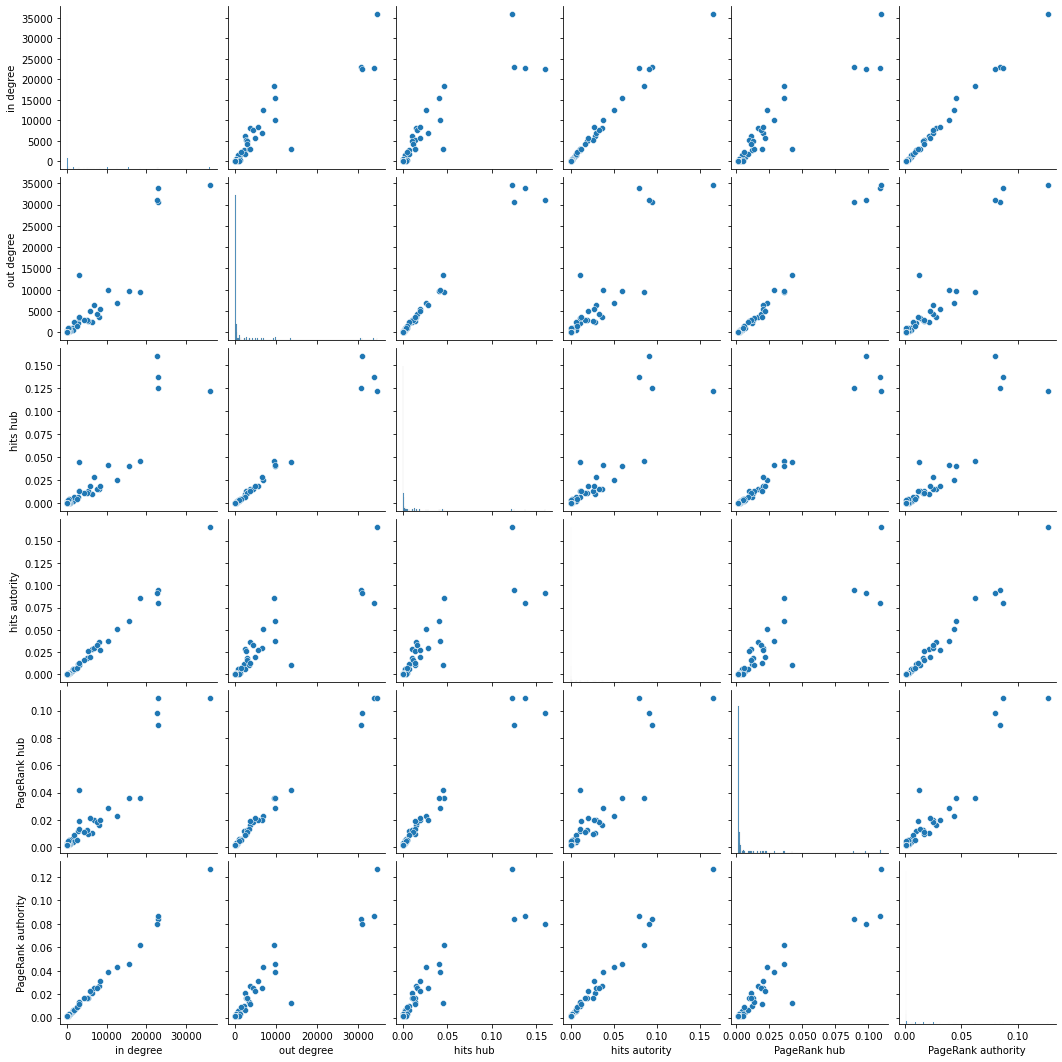

Nodes  in degree  in degree position  hits autority  \
63                    Spain      36020                   1       0.165548   
52                  Germany      22906                   3       0.079958   
11                   France      23047                   2       0.094907   
106                   Italy      22627                   4       0.090780   
41                       UK      18474                   5       0.085221   
70                   Poland      15539                   6       0.059830   
9                  Portugal      12585                   7       0.050634   
78              Netherlands      10198                   8       0.037921   
122                 Czechia       8342                   9       0.027543   
56                   Sweden       8079                  10       0.036803   
61                  Finland       7590                  11       0.033260   
43                  Belgium       6846                  12       0.029684   
128                 Austria       5666                  14       0.019946   
16                   Norway       6282                  13       0.028431   
25                  Ireland       5184                  15       0.025973   
119                 Denmark       4315                  17       0.016555   
110                 Hungary       4970                  16       0.018853   
112                      EL       3001                  19       0.010903   
62                   Turkey       2952                  20       0.010592   
140                 Romania       3058                  18       0.012703   
107               Lithuania       2835                  21       0.011192   
138                Slovenia       2378                  22       0.007568   
8                   Croatia       1909                  23       0.006136   
120                Slovakia       1763                  24       0.006463   
5                    Latvia       1587                  25       0.006606   
53                  Estonia       1479                  26       0.005960   
39                 Bulgaria       1129                  27       0.003655   
105                  Cyprus        650                  28       0.001940   
124                 Iceland        510                  29       0.002093   
83                    Malta        453                  31       0.001687   
129      Russian Federation        475                  30       0.001612   
67                   Israel        268                  32       0.000985   
21                   Serbia        242                  33       0.000875   
18            United States        157                  34       0.000696   
48               Luxembourg        152                  35       0.000693   
36   Bosnia and Herzegovina        113                  37       0.000367   
125                   China         79                  43       0.000147   
58                   Canada         89                  41       0.000308   
139                 Ukraine         98                  40       0.000297   
134         North Macedonia        113                  36       0.000405   

     hits autority position  PageRank authority  PageRank authority position  
63                        1            0.127053                            1  
52                        5            0.086534                            2  
11                        2            0.083933                            3  
106                       3            0.080115                            4  
41                        4            0.062336                            5  
70                        6            0.045379                            6  
9                         7            0.043211                            7  
78                        8            0.039211                            8  
122                      13            0.031170                            9  
56                        9            0.027315                           

Nodes  out degree  out degree position  hits hub  \
63                    Spain       34630                    1  0.122369   
52                  Germany       33780                    2  0.137508   
106                   Italy       30947                    3  0.160041   
11                   France       30554                    4  0.124890   
62                   Turkey       13510                    5  0.045017   
41                       UK        9395                    8  0.046538   
70                   Poland        9775                    7  0.040729   
78              Netherlands        9843                    6  0.041869   
9                  Portugal        6862                    9  0.025886   
128                 Austria        4938                   12  0.019161   
43                  Belgium        6511                   10  0.028681   
122                 Czechia        5527                   11  0.019247   
140                 Romania        3646                   14  0.013879   
61                  Finland        4275                   13  0.016044   
56                   Sweden        3574                   15  0.015303   
112                      EL        3404                   16  0.013223   
110                 Hungary        2882                   17  0.010898   
107               Lithuania        2205                   22  0.007061   
119                 Denmark        2811                   18  0.011598   
16                   Norway        2481                   20  0.010131   
25                  Ireland        2736                   19  0.013247   
120                Slovakia        2345                   21  0.007096   
39                 Bulgaria        1085                   26  0.003823   
8                   Croatia        1435                   23  0.005140   
5                    Latvia        1041                   27  0.002953   
138                Slovenia        1423                   24  0.004711   
129      Russian Federation        1158                   25  0.004444   
139                 Ukraine        1026                   28  0.003747   
53                  Estonia         660                   30  0.002223   
21                   Serbia         839                   29  0.003316   
36   Bosnia and Herzegovina         477                   34  0.001881   
102                 Morocco         489                   32  0.002320   
48               Luxembourg         495                   31  0.002038   
90                  Tunisia         483                   33  0.002575   
111                 Albania         403                   36  0.001405   
49                  Georgia         465                   35  0.001763   
134         North Macedonia         323                   39  0.000654   
67                   Israel         375                   38  0.001396   
125                   China         382                   37  0.001375   
131                      XK         277                   46  0.000855   

     hits hub position  PageRank hub  PageRank hub position  
63                   4      0.109364                      1  
52                   2      0.109099                      2  
106                  1      0.097924                      3  
11                   3      0.089084                      4  
62                   6      0.042240                      5  
41                   5      0.036373                      6  
70                   8      0.036089                      7  
78                   7      0.028372                      8  
9                   10      0.023053                      9  
128                 12      0.021770                     10  
43                   9      0.020250                     11  
122                 11      0.019907                     12  
140                 15      0.019066                     13  
61                  13      0.018470                     14  
56                  14      0.016030                     

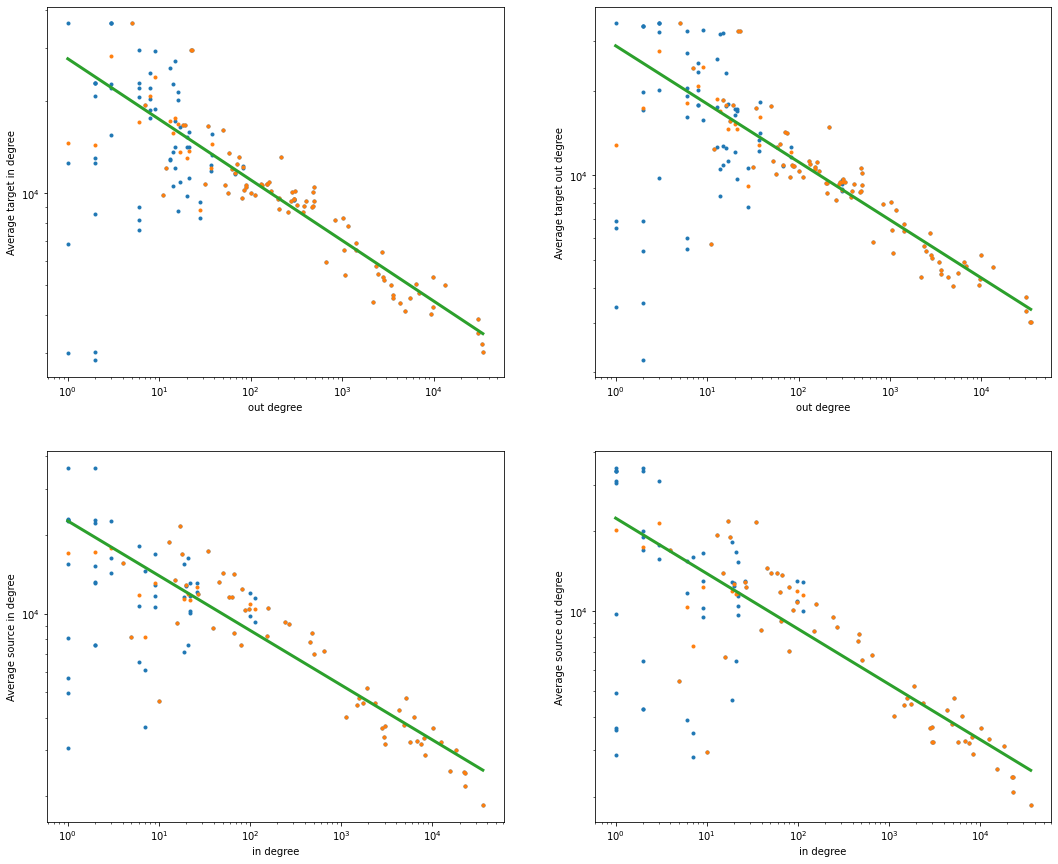

(-0.19839347404635532, -0.20604484181819913, -0.20917415960303473, -0.20856165223470094)


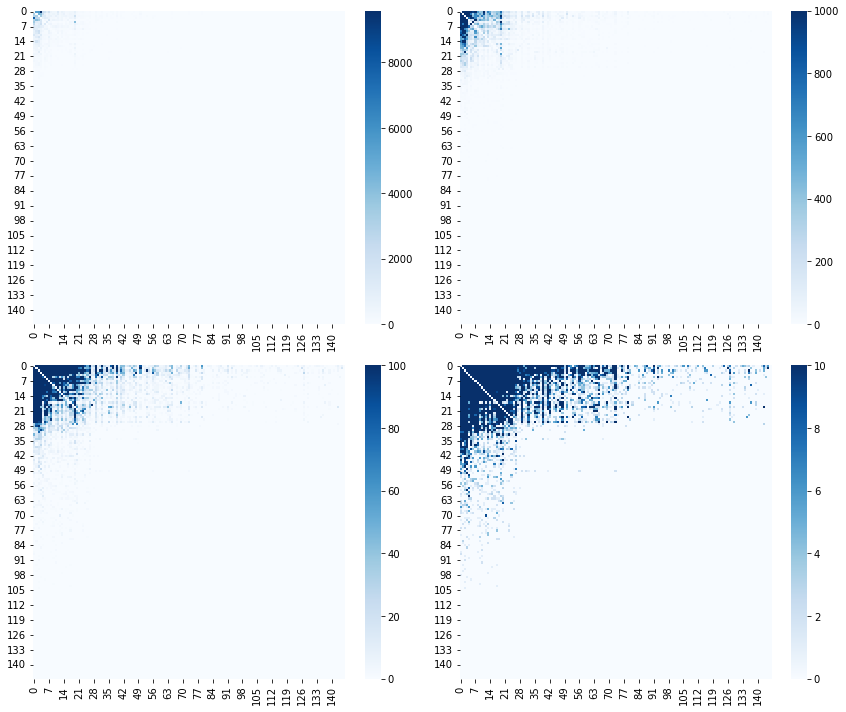

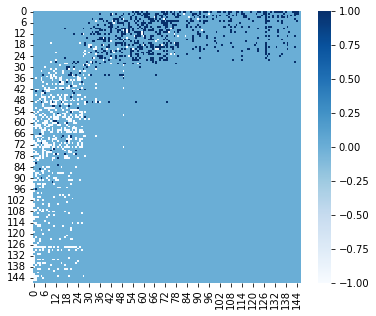

Nodes  Community
2               Sri Lanka          0
4                  Zambia          0
7                Cameroon          0
11                 France          0
12                 Rwanda          0
..                    ...        ...
133          Burkina Faso          0
135                Belize          0
136  Moldova, Republic of          0
142            Mauritania          0
144              Suriname          0

[46 rows x 2 columns]

Nodes  Community
6        New Zealand          1
8            Croatia          1
16            Norway          1
17        Montenegro          1
21            Serbia          1
..               ...        ...
132        Nicaragua          1
134  North Macedonia          1
139          Ukraine          1
143           Bhutan          1
146          Uruguay          1

[44 rows x 2 columns]

Nodes  Community
1                   Bangladesh          2
3                    Hong Kong          2
10                      Gambia          2
15   Taiwan, Province of China          2
18               United States          2
22                      Jordan          2
25                     Ireland          2
26                       Egypt          2
28                       Sudan          2
32                        Fiji          2
39                    Bulgaria          2
49                     Georgia          2
61                     Finland          2
62                      Turkey          2
73                       Japan          2
74                    Malaysia          2
77                       India          2
79                     Lebanon          2
84                      Malawi          2
87                     Ecuador          2
88                 Afghanistan          2
97                 El Salvador          2
102                    Morocco          2
103                   Mongolia          2
104           Papua New Guinea          2
107                  Lithuania          2
119                    Denmark          2
122                    Czechia          2
126                 Cabo Verde          2
130                      Ghana          2
131                         XK          2
137                    Belarus          2
138                   Slovenia          2
141                    Nigeria          2

Nodes  Community
5                               Latvia          3
9                             Portugal          3
19                            Botswana          3
20                             Algeria          3
23                           Argentina          3
27                         Timor-Leste          3
33   Venezuela, Bolivarian Republic of          3
34                              Uganda          3
40                               Chile          3
50                        South Africa          3
60                           Mauritius          3
64                          Azerbaijan          3
71                          Tajikistan          3
80                               Libya          3
86                  Korea, Republic of          3
90                             Tunisia          3
93                              Panama          3
95                               Macao          3
111                            Albania          3
112                                 EL          3
140                            Romania          3
145                  Brunei Darussalam          3

Nodes  Community
0   nan          4

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
17          Turkey                          7107650.0
13         Germany                          2625241.0
10  United Kingdom                          2263020.0
23           Italy                          1797986.0
18           Spain                          1491419.0
20          Poland                          1418588.0
21     Netherlands                           720583.0
27          Greece                           704969.0
15          Sweden                           438578.0
2         Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.615868e-07
3          Romania   1.414166e-07
4         Slovenia   1.030543e-07
5        Lithuania   1.022671e-07
6          Estonia   8.887769e-08
7          Belgium   8.779008e-08
8         Slovakia   7.930057e-08
9            Spain   7.332851e-08
10        Portugal   7.126727e-08
11          Latvia   7.101621e-08
12         Czechia   6.711531e-08
13         Finland   6.676041e-08
14       Macedonia   5.806861e-08
15           Italy   5.446309e-08
16         Ireland   4.884346e-08
17         Hungary   4.561838e-08
18         Denmark   4.274294e-08
19         Germany   4.155758e-08
20          Norway   3.944553e-08
21     Netherlands   3.937320e-08
22          Sweden   3.655081e-08
23         Croatia   3.602993e-08
24        Bulgaria   2.691932e-08
25          Poland   2.544010e-08
26         Albania   2.126780e-08
27          Greece   1.865586e-08
28          Serbia   1.685233e-08
29  United Kingdom   1.607281e-08
30          Turkey   5.942914e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1            Malta   2.000000e-07
2       Luxembourg   2.000000e-07
3         Slovenia   1.786941e-07
4         Portugal   1.335861e-07
5          Estonia   1.274242e-07
6          Belgium   1.090200e-07
7          Czechia   1.050861e-07
8          Finland   9.145925e-08
9        Lithuania   8.721573e-08
10         Ireland   8.541925e-08
11           Spain   8.518949e-08
12         Romania   8.489857e-08
13          Latvia   8.304045e-08
14          Norway   7.848664e-08
15         Denmark   6.669199e-08
16          Sweden   6.228195e-08
17        Slovakia   6.162832e-08
18         Hungary   5.913845e-08
19     Netherlands   5.441618e-08
20         Croatia   4.670279e-08
21           Italy   4.455839e-08
22         Germany   3.296214e-08
23          Poland   3.198902e-08
24       Macedonia   2.788566e-08
25  United Kingdom   2.754530e-08
26        Bulgaria   2.239988e-08
27          Greece   1.860285e-08
28         Albania   8.482448e-09
29          Serbia   7.707365e-09
30          Turkey   1.743374e-09
31     Switzerland   0.000000e+00

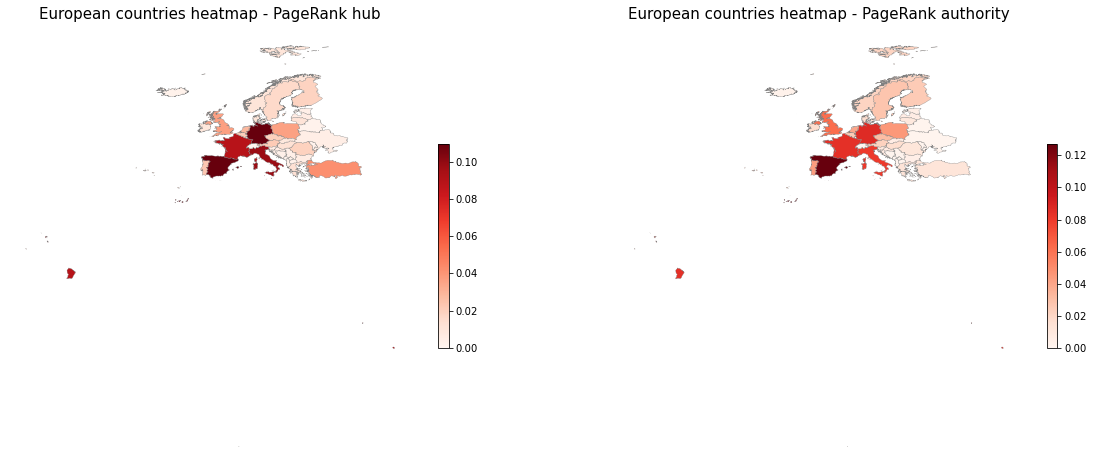

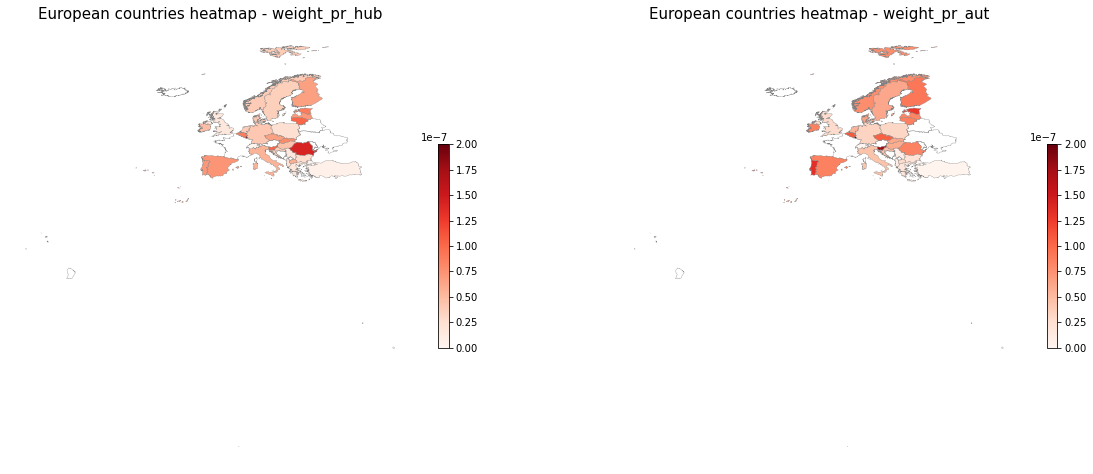

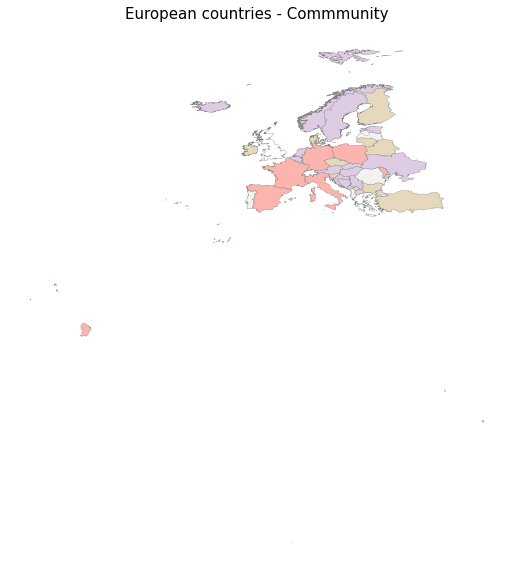

In [5]:
country18_df = pd.read_csv('data\Erasmus18.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country18_df)

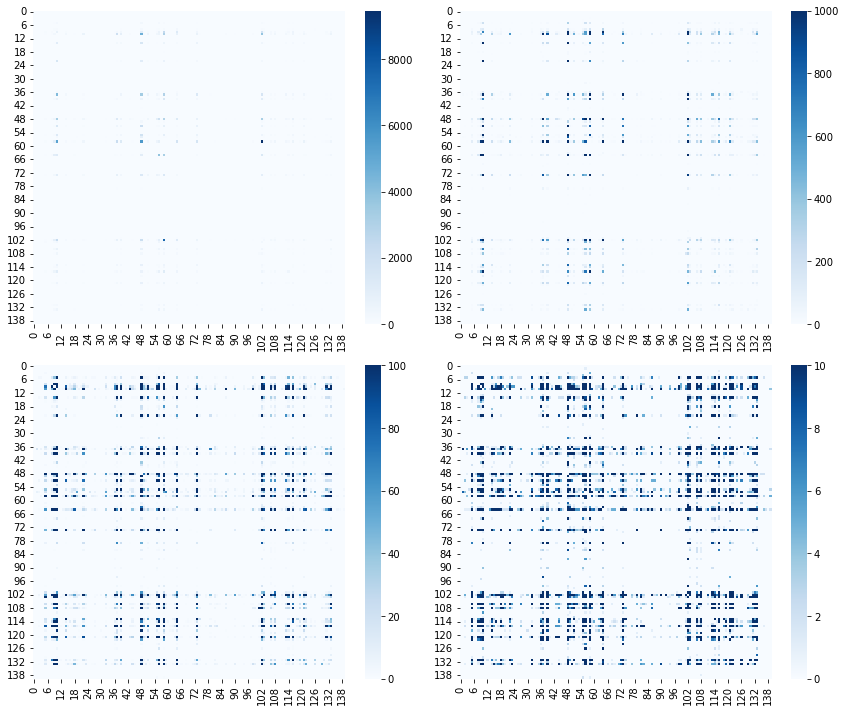

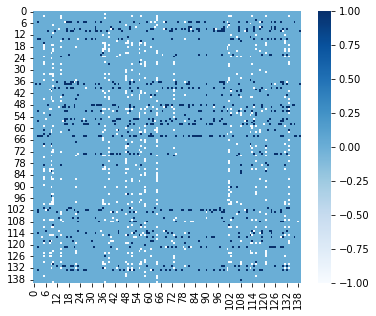

Number of components = 2


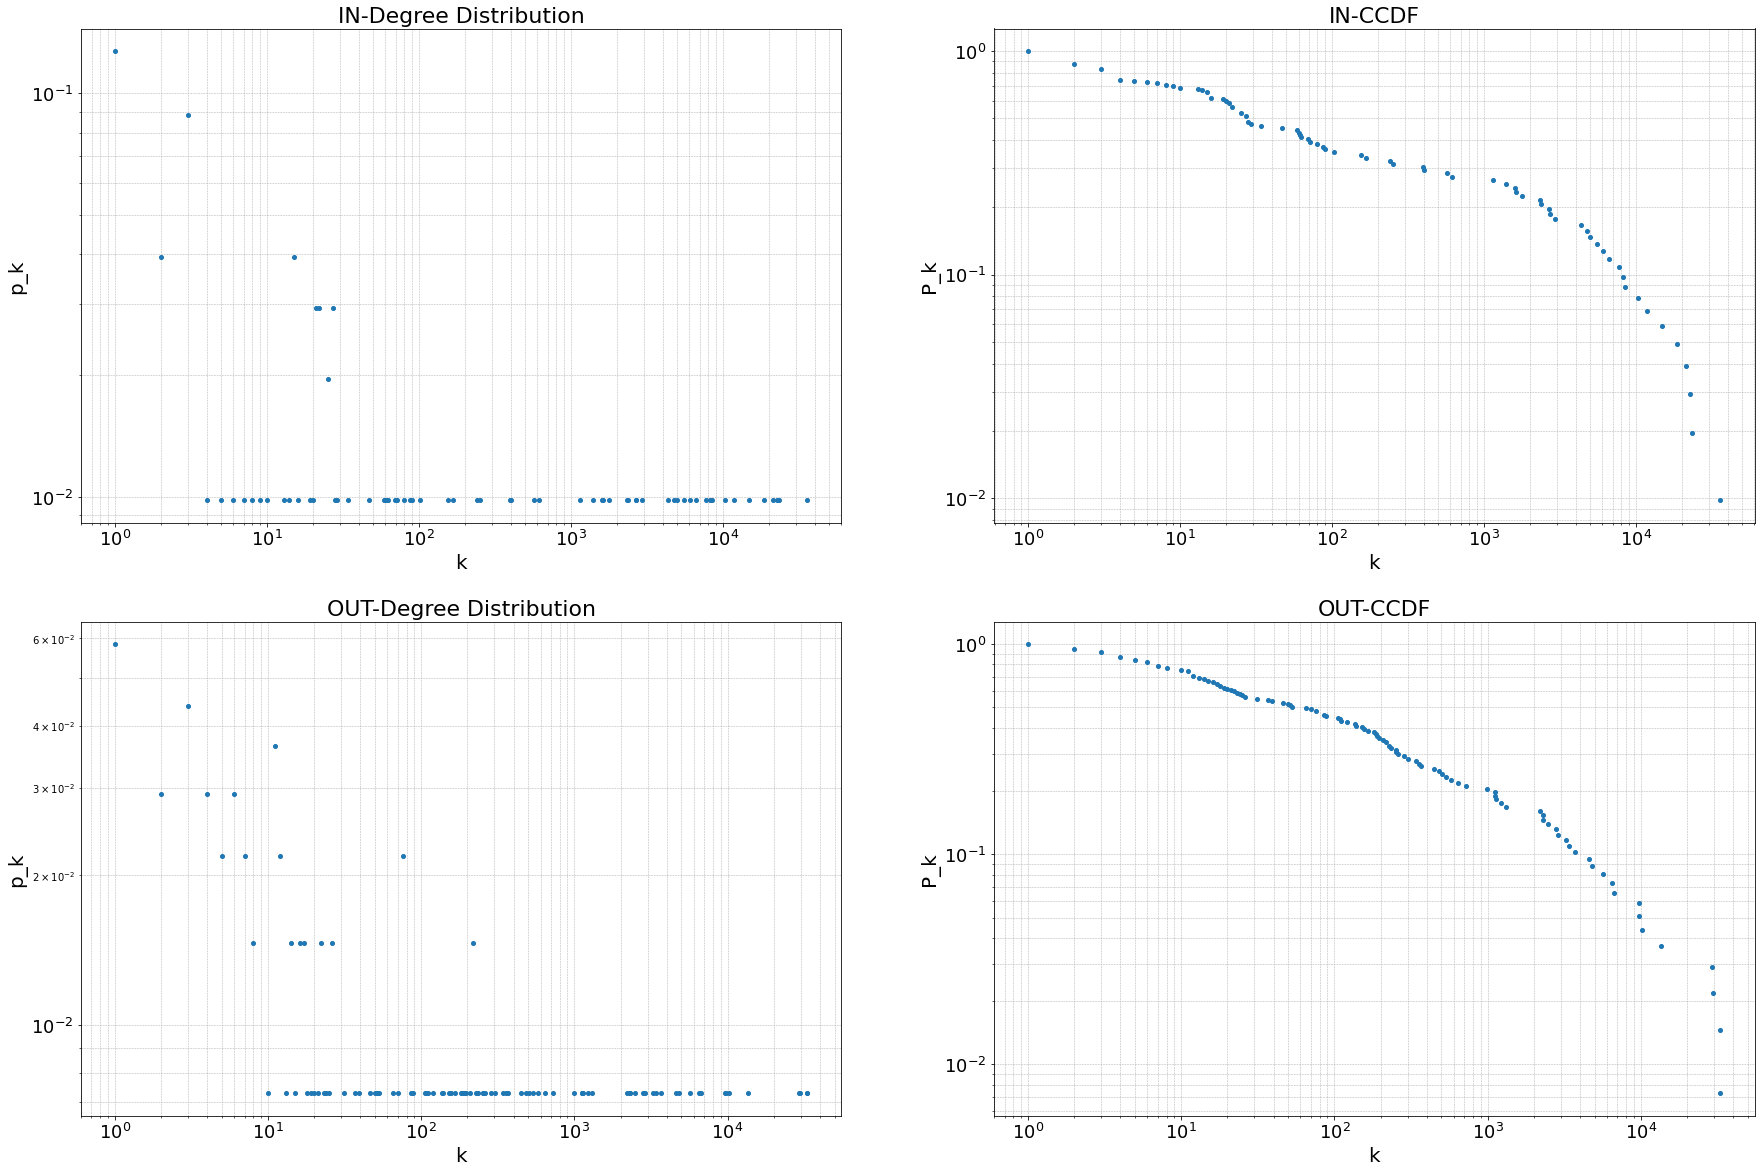

Top 10 for in degree


Nodes  in degree
58         Spain      35605
48       Germany      23161
10        France      22577
102        Italy      21364
37            UK      18668
64        Poland      14837
9       Portugal      11764
73   Netherlands      10325
51        Sweden       8497
116      Czechia       8191

Top 10 for out degree


Nodes  out degree
58         Spain       32975
48       Germany       32916
10        France       29867
102        Italy       29261
56        Turkey       13546
64        Poland       10157
73   Netherlands        9806
37            UK        9681
39       Belgium        6723
9       Portugal        6520

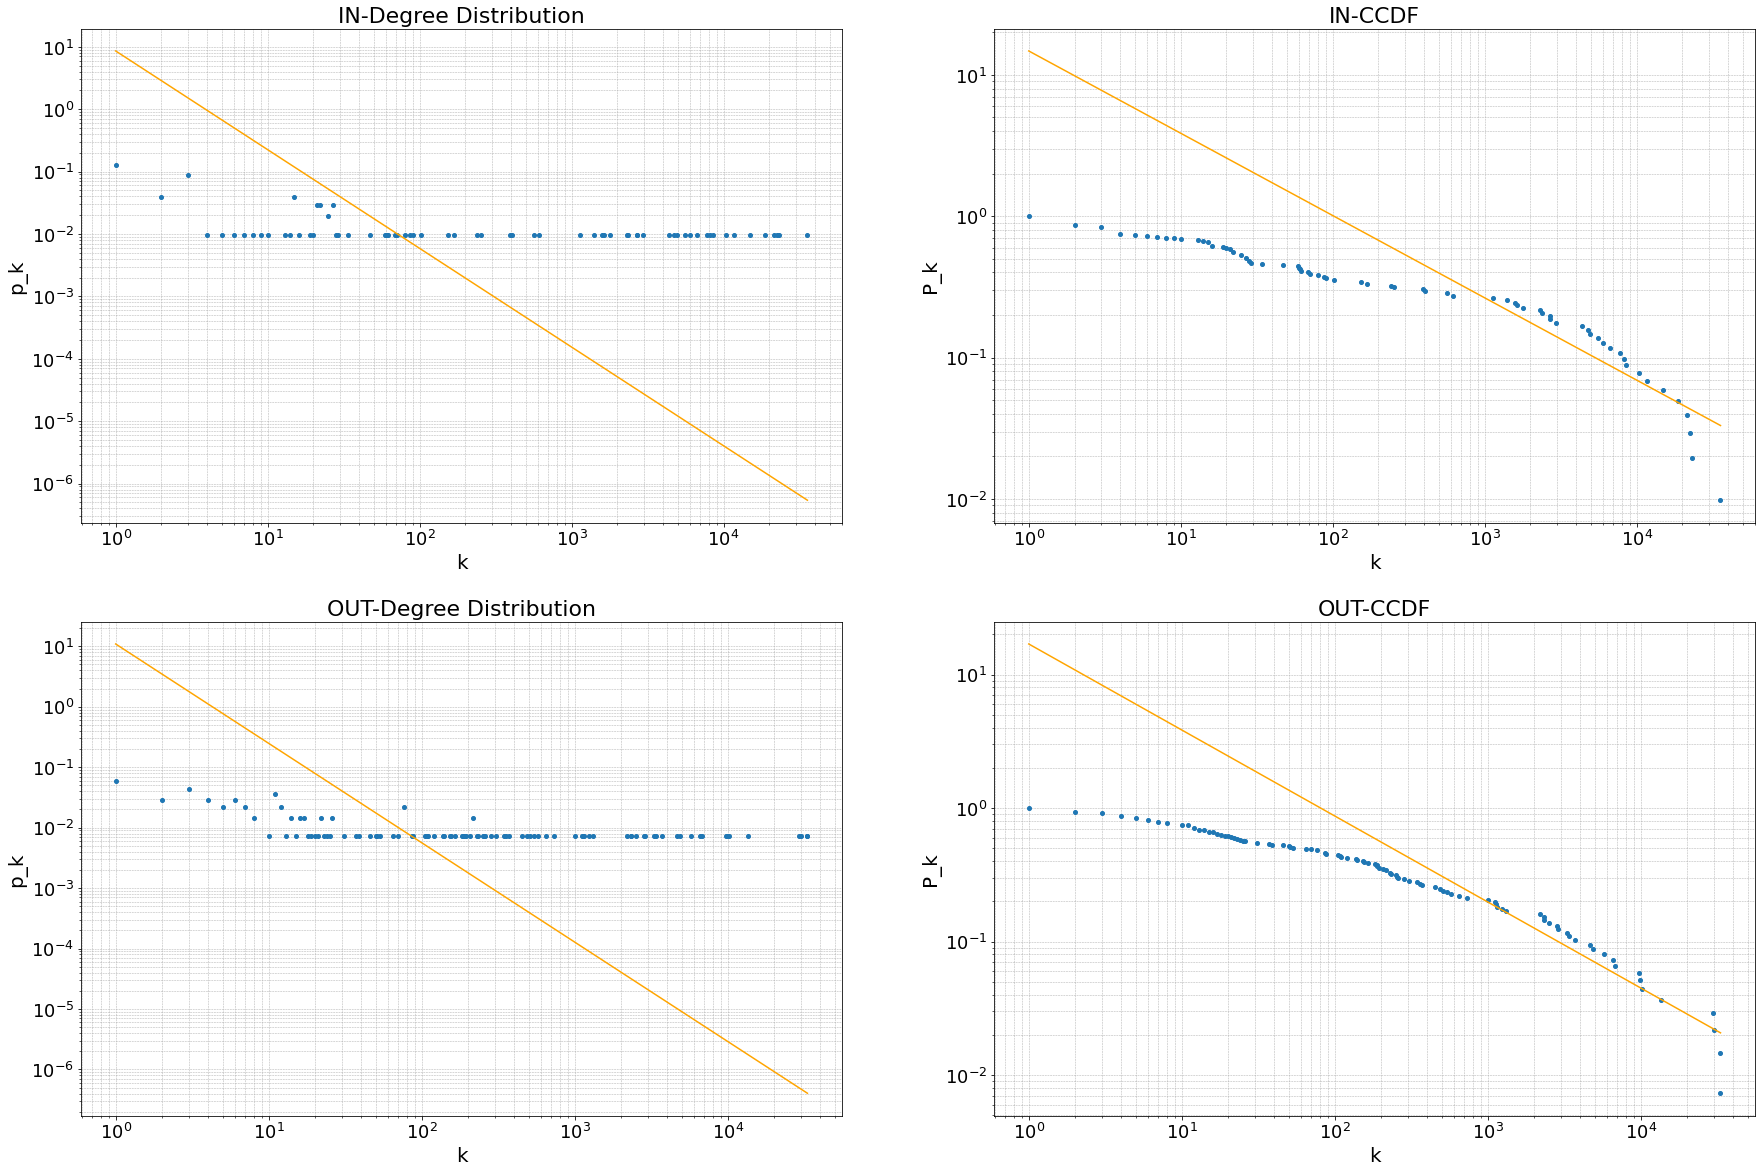

gamma_in = 1.5820023635740013
gamma_out = 1.6447442449039387


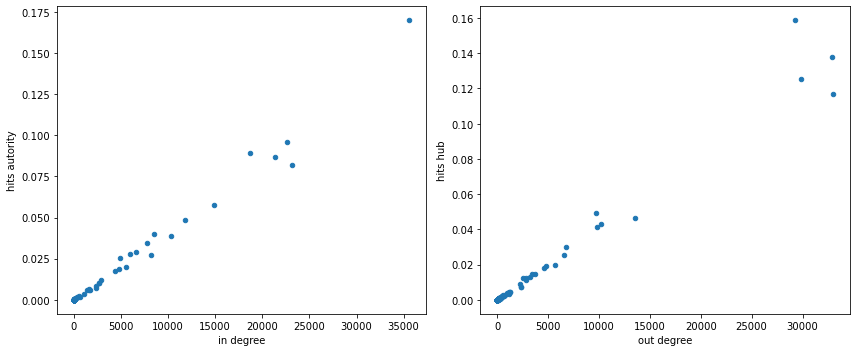

Top 10 for hits hub


Nodes  hits hub
102        Italy  0.158669
48       Germany  0.138050
10        France  0.125551
58         Spain  0.117020
37            UK  0.049037
56        Turkey  0.046440
64        Poland  0.042947
73   Netherlands  0.041421
39       Belgium  0.030267
9       Portugal  0.025288

Top 10 for hits autority


Nodes  hits autority
58         Spain       0.169761
10        France       0.095757
37            UK       0.088944
102        Italy       0.086551
48       Germany       0.082129
64        Poland       0.057782
9       Portugal       0.048229
51        Sweden       0.040013
73   Netherlands       0.039021
55       Finland       0.034659

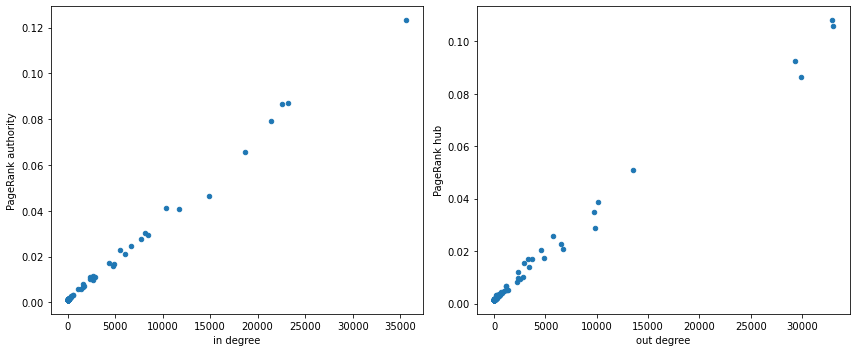

Top 10 for PageRank hub


Nodes  PageRank hub
48       Germany      0.107969
58         Spain      0.105780
102        Italy      0.092630
10        France      0.086511
56        Turkey      0.050982
64        Poland      0.038558
37            UK      0.034877
73   Netherlands      0.028793
116      Czechia      0.025774
9       Portugal      0.022677

Top 10 for PageRank authority


Nodes  PageRank authority
58         Spain            0.123114
48       Germany            0.087006
10        France            0.086449
102        Italy            0.079213
37            UK            0.065609
64        Poland            0.046248
73   Netherlands            0.041350
9       Portugal            0.040707
116      Czechia            0.030310
51        Sweden            0.029418

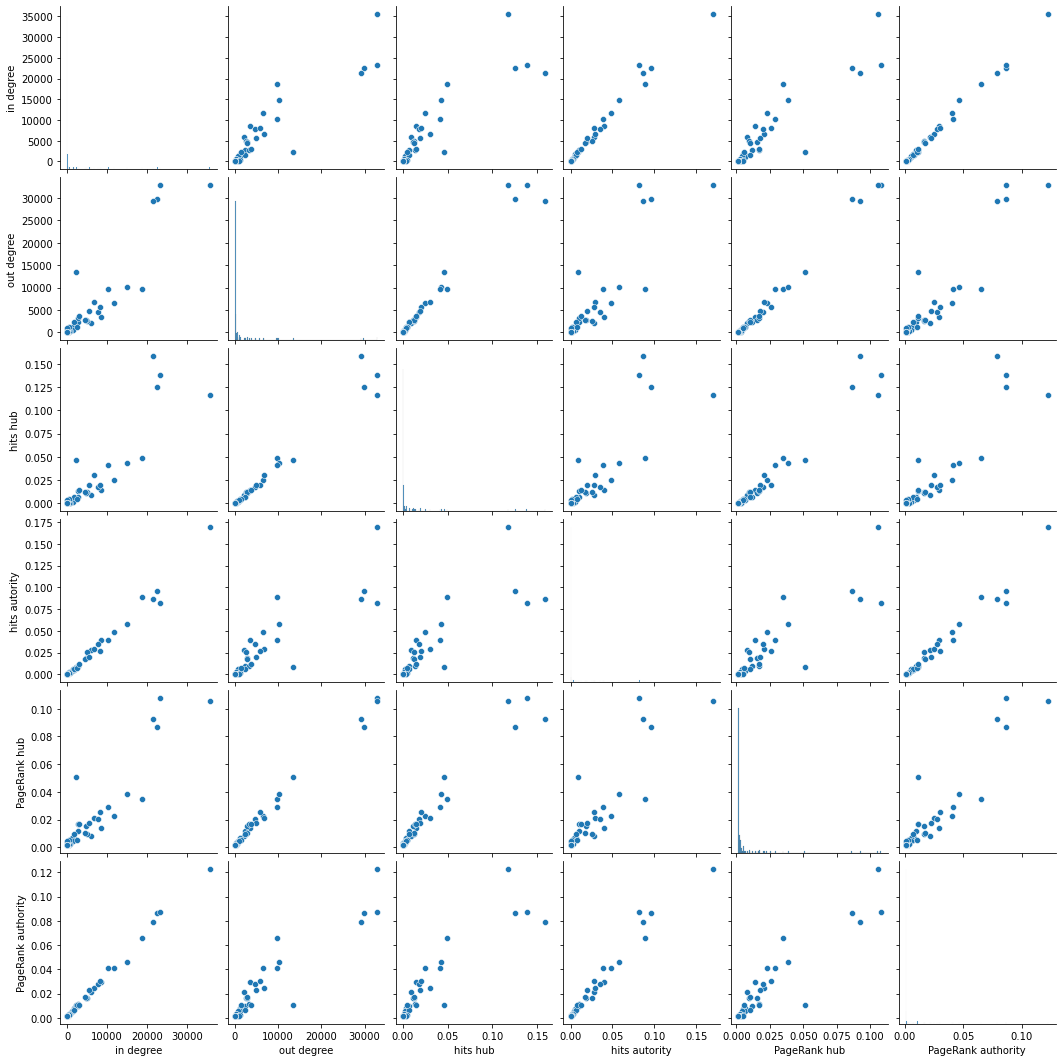

Nodes  in degree  in degree position  hits autority  \
58                Spain      35605                   1       0.169761   
48              Germany      23161                   2       0.082129   
10               France      22577                   3       0.095757   
102               Italy      21364                   4       0.086551   
37                   UK      18668                   5       0.088944   
64               Poland      14837                   6       0.057782   
73          Netherlands      10325                   8       0.039021   
9              Portugal      11764                   7       0.048229   
116             Czechia       8191                  10       0.027478   
51               Sweden       8497                   9       0.040013   
55              Finland       7719                  11       0.034659   
39              Belgium       6645                  12       0.029181   
121             Austria       5562                  14       0.020000   
14               Norway       6012                  13       0.027800   
113             Denmark       4362                  17       0.017367   
22              Ireland       4942                  15       0.025519   
106             Hungary       4753                  16       0.018594   
108                  EL       2688                  20       0.009944   
133             Romania       2932                  18       0.011985   
56               Turkey       2326                  22       0.008511   
131            Slovenia       2367                  21       0.007317   
103           Lithuania       2692                  19       0.010274   
5                Latvia       1593                  25       0.006580   
8               Croatia       1777                  23       0.005673   
114            Slovakia       1627                  24       0.006065   
49              Estonia       1397                  26       0.005867   
36             Bulgaria       1142                  27       0.003644   
118             Iceland        569                  29       0.002494   
101              Cyprus        614                  28       0.001771   
79                Malta        395                  31       0.001552   
122  Russian Federation        403                  30       0.001586   
63               Israel        240                  33       0.000845   
18               Serbia        253                  32       0.000888   
15        United States        168                  34       0.000569   
43           Luxembourg        154                  35       0.000767   
119               China         87                  38       0.000229   
53               Canada        102                  36       0.000447   
68                Japan         90                  37       0.000415   
82   Korea, Republic of         59                  45       0.000186   
107             Albania         71                  40       0.000381   

     hits autority position  PageRank authority  PageRank authority position  
58                        1            0.123114                            1  
48                        5            0.087006                            2  
10                        2            0.086449                            3  
102                       4            0.079213                            4  
37                        3            0.065609                            5  
64                        6            0.046248                            6  
73                        9            0.041350                            7  
9                         7            0.040707                            8  
116                      13            0.030310                            9  
51                        8            0.029418                           10  
55                       10            0.027783                           11  
39                       11            0.024593                           12

Nodes  out degree  out degree position  hits hub  \
48                  Germany       32916                    2  0.138050   
58                    Spain       32975                    1  0.117020   
102                   Italy       29261                    4  0.158669   
10                   France       29867                    3  0.125551   
56                   Turkey       13546                    5  0.046440   
64                   Poland       10157                    6  0.042947   
37                       UK        9681                    8  0.049037   
73              Netherlands        9806                    7  0.041421   
116                 Czechia        5694                   11  0.019911   
9                  Portugal        6520                   10  0.025288   
39                  Belgium        6723                    9  0.030267   
55                  Finland        4613                   13  0.018064   
121                 Austria        4838                   12  0.019445   
133                 Romania        3701                   14  0.014400   
108                      EL        3268                   16  0.013178   
106                 Hungary        2869                   17  0.011019   
51                   Sweden        3394                   15  0.014861   
103               Lithuania        2309                   21  0.007263   
113                 Denmark        2810                   18  0.012119   
114                Slovakia        2316                   20  0.007171   
22                  Ireland        2492                   19  0.012187   
14                   Norway        2196                   22  0.009252   
36                 Bulgaria        1112                   27  0.003873   
5                    Latvia        1141                   25  0.003331   
131                Slovenia        1311                   23  0.004607   
8                   Croatia        1233                   24  0.004574   
122      Russian Federation        1122                   26  0.004397   
132                 Ukraine         998                   28  0.004001   
49                  Estonia         643                   30  0.002034   
18                   Serbia         728                   29  0.002768   
32   Bosnia and Herzegovina         450                   35  0.001515   
119                   China         575                   31  0.002390   
98                  Morocco         537                   32  0.002809   
44                  Georgia         507                   33  0.001899   
126         North Macedonia         303                   39  0.000562   
19                   Jordan         259                   41  0.000759   
59               Azerbaijan         189                   50  0.000450   
43               Luxembourg         484                   34  0.002201   
86                  Tunisia         357                   37  0.001660   
107                 Albania         370                   36  0.001528   

     hits hub position  PageRank hub  PageRank hub position  
48                   2      0.107969                      1  
58                   4      0.105780                      2  
102                  1      0.092630                      3  
10                   3      0.086511                      4  
56                   6      0.050982                      5  
64                   7      0.038558                      6  
37                   5      0.034877                      7  
73                   8      0.028793                      8  
116                 11      0.025774                      9  
9                   10      0.022677                     10  
39                   9      0.020963                     11  
55                  13      0.020220                     12  
121                 12      0.017531                     13  
133                 15      0.017118                     14  
108                 16      0.016792                     

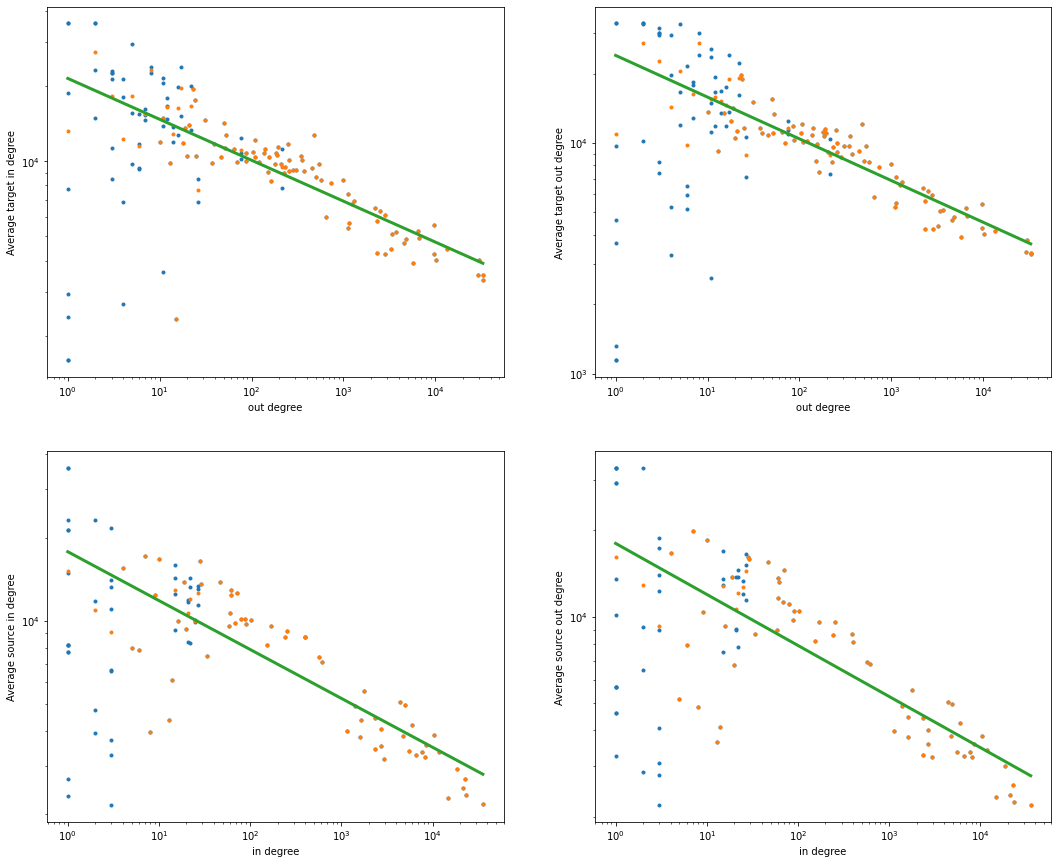

(-0.1638113565743919, -0.1808333579656681, -0.17663416293109127, -0.17836246071891335)


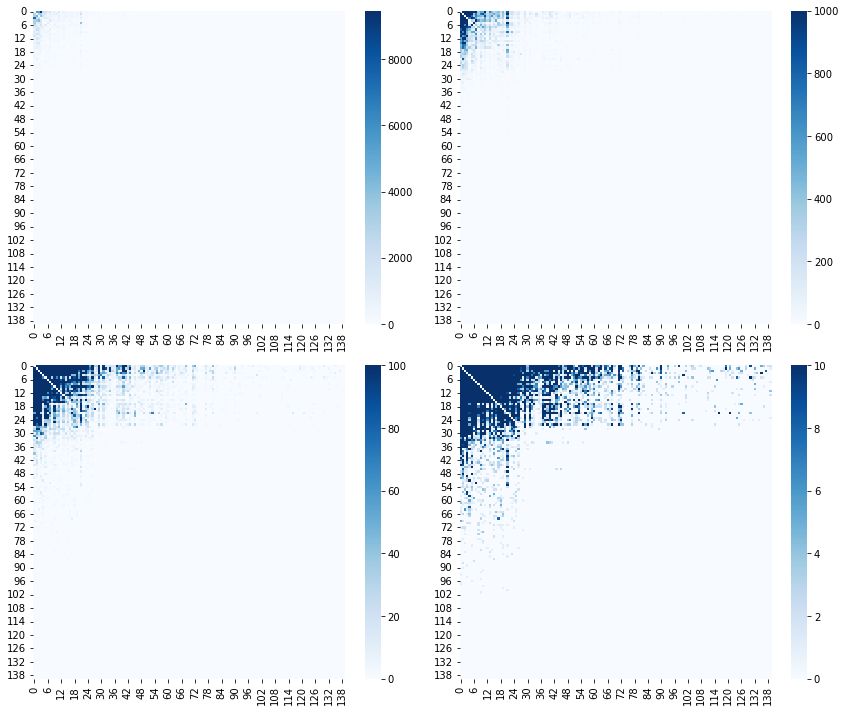

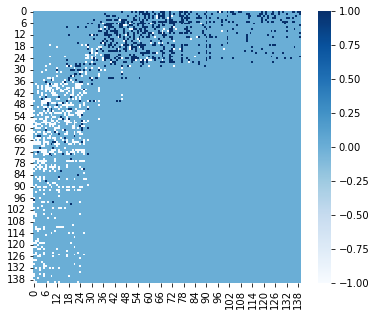

Nodes  Community
5                      Latvia          0
8                     Croatia          0
12         Dominican Republic          0
15              United States          0
16                 Montenegro          0
18                     Serbia          0
23                      Egypt          0
32     Bosnia and Herzegovina          0
36                   Bulgaria          0
47   Central African Republic          0
49                    Estonia          0
50                    Armenia          0
52                     Brazil          0
57                  Mauritius          0
59                 Azerbaijan          0
60                      Kenya          0
63                     Israel          0
65        Trinidad and Tobago          0
68                      Japan          0
75                      Libya          0
81                 Kazakhstan          0
85                   Honduras          0
89                     Panama          0
93                El Salvador          0
97                   Mongolia          0
99                 Uzbekistan          0
101                    Cyprus          0
103                 Lithuania          0
105                     Niger          0
106                   Hungary          0
108                        EL          0
113                   Denmark          0
114                  Slovakia          0
115                    Mexico          0
119                     China          0
129      Moldova, Republic of          0
131                  Slovenia          0
132                   Ukraine          0
133                   Romania          0
138         Brunei Darussalam          0

Nodes  Community
1                   Bangladesh          1
2                    Sri Lanka          1
7                     Cameroon          1
13   Taiwan, Province of China          1
17                     Algeria          1
19                      Jordan          1
20                   Argentina          1
25                       Sudan          1
26                        Peru          1
28                     Senegal          1
34                    Paraguay          1
37                          UK          1
42                    Pakistan          1
46                   Guatemala          1
56                      Turkey          1
58                       Spain          1
64                      Poland          1
66                  Tajikistan          1
69                    Malaysia          1
76                       Benin          1
78                 Philippines          1
80                      Malawi          1
82          Korea, Republic of          1
84                 Afghanistan          1
88                        Mali          1
92        Syrian Arab Republic          1
94                    Thailand          1
100           Papua New Guinea          1
102                      Italy          1
109                     Angola          1
110                  Singapore          1
111                 Kyrgyzstan          1
117                 Mozambique          1
120                 Cabo Verde          1
126            North Macedonia          1
128                     Belize          1
134                 Mauritania          1
136                     Bhutan          1
137                   Suriname          1
139                    Uruguay          1

Nodes  Community
3                          Hong Kong          2
11                        Madagascar          2
14                            Norway          2
22                           Ireland          2
27                         Indonesia          2
30                            Uganda          2
35                             Chile          2
39                           Belgium          2
40                         Australia          2
41                          Colombia          2
44                           Georgia          2
45                      South Africa          2
48                           Germany          2
51                            Sweden          2
54      Tanzania, United Republic of          2
61                     Liechtenstein          2
62               Palestine, State of          2
67   Bolivia, Plurinational State of          2
70                              Cuba          2
72                             India          2
73                       Netherlands          2
86                           Tunisia          2
104                         Ethiopia          2
112                          Jamaica          2
118                          Iceland          2
122               Russian Federation          2
124                               XK          2
127                     Burkina Faso          2
135                          Nigeria          2

Nodes  Community
4                              Zambia          3
6                         New Zealand          3
9                            Portugal          3
21                              Nepal          3
24                        Timor-Leste          3
31                         Costa Rica          3
43                         Luxembourg          3
53                             Canada          3
55                            Finland          3
71   Lao People's Democratic Republic          3
74                            Lebanon          3
77                           Cambodia          3
79                              Malta          3
87                            Myanmar          3
90                           Viet Nam          3
91                           Barbados          3
95                              Macao          3
98                            Morocco          3
107                           Albania          3
116                           Czechia          3
121                           Austria          3
123                             Ghana          3
125                         Nicaragua          3
130                           Belarus          3

Nodes  Community
10                             France          4
29  Venezuela, Bolivarian Republic of          4
33          Iran, Islamic Republic of          4
38                              Haiti          4
83                            Ecuador          4
96                      Côte d'Ivoire          4

Nodes  Community
0   nan          5

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
17          Turkey                          7107650.0
13         Germany                          2625241.0
10  United Kingdom                          2263020.0
23           Italy                          1797986.0
18           Spain                          1491419.0
20          Poland                          1418588.0
21     Netherlands                           720583.0
27          Greece                           704969.0
15          Sweden                           438578.0
2         Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.492077e-07
3          Romania   1.269687e-07
4        Lithuania   1.038695e-07
5         Slovenia   1.008047e-07
6          Estonia   9.722841e-08
7          Belgium   9.088036e-08
8         Slovakia   8.726855e-08
9          Czechia   8.689476e-08
10          Latvia   8.319393e-08
11         Finland   7.308682e-08
12           Spain   7.092605e-08
13        Portugal   7.010644e-08
14       Macedonia   6.583604e-08
15         Hungary   5.536776e-08
16           Italy   5.151878e-08
17         Ireland   4.661964e-08
18         Germany   4.112719e-08
19     Netherlands   3.995800e-08
20         Denmark   3.928433e-08
21          Sweden   3.216798e-08
22         Croatia   3.190898e-08
23          Norway   3.044968e-08
24        Bulgaria   2.887107e-08
25          Poland   2.718071e-08
26          Greece   2.381973e-08
27         Albania   2.016383e-08
28          Serbia   1.619288e-08
29  United Kingdom   1.541150e-08
30          Turkey   7.172862e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.963920e-07
3         Slovenia   1.939973e-07
4         Portugal   1.258455e-07
5          Estonia   1.246647e-07
6          Belgium   1.066173e-07
7           Latvia   1.024491e-07
8          Czechia   1.021874e-07
9          Finland   1.004248e-07
10       Lithuania   8.574431e-08
11           Spain   8.254842e-08
12         Ireland   8.232216e-08
13         Romania   8.084707e-08
14          Norway   7.869189e-08
15          Sweden   6.707696e-08
16         Denmark   6.682868e-08
17        Slovakia   6.054686e-08
18         Hungary   5.764323e-08
19     Netherlands   5.738467e-08
20         Croatia   4.456249e-08
21           Italy   4.405664e-08
22         Germany   3.314218e-08
23          Poland   3.260108e-08
24  United Kingdom   2.899191e-08
25       Macedonia   2.457189e-08
26        Bulgaria   2.425445e-08
27          Greece   1.612880e-08
28         Albania   9.442370e-09
29          Serbia   8.126549e-09
30          Turkey   1.531775e-09
31     Switzerland   0.000000e+00

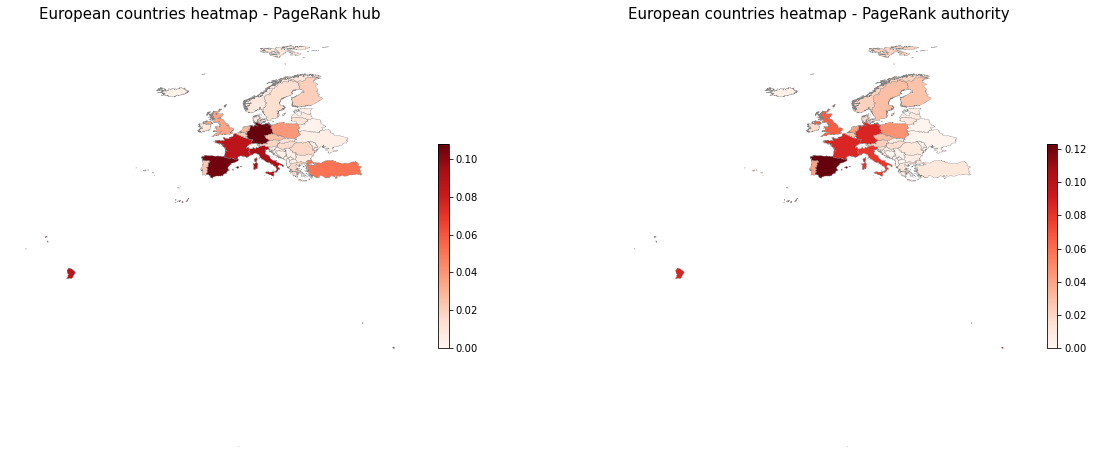

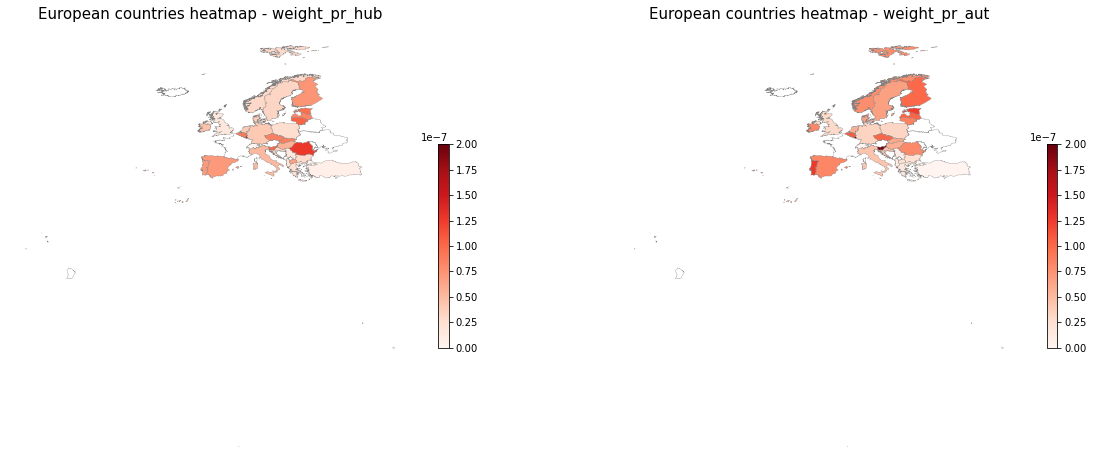

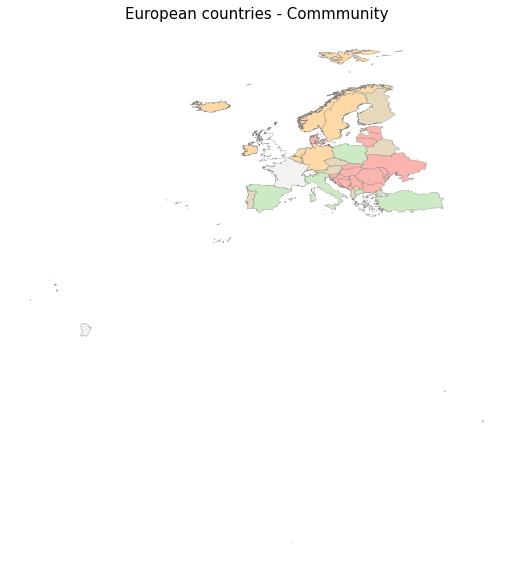

In [6]:
country17_df = pd.read_csv('data\Erasmus17.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country17_df)

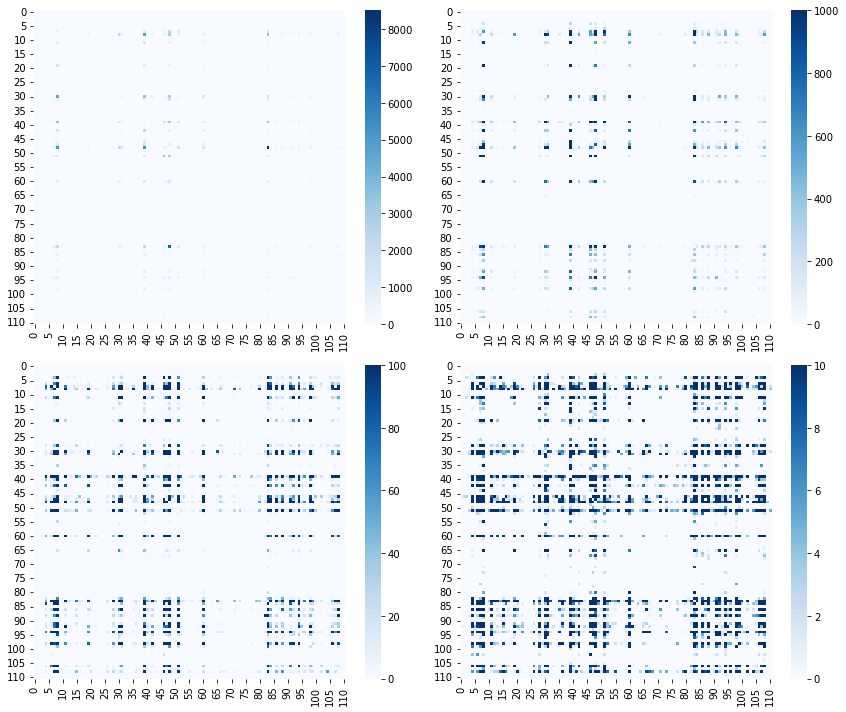

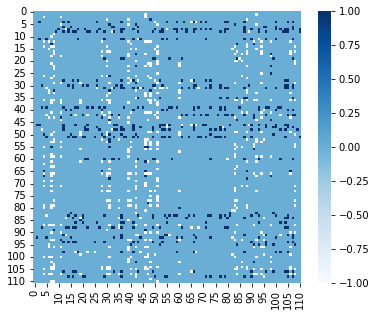

Number of components = 2


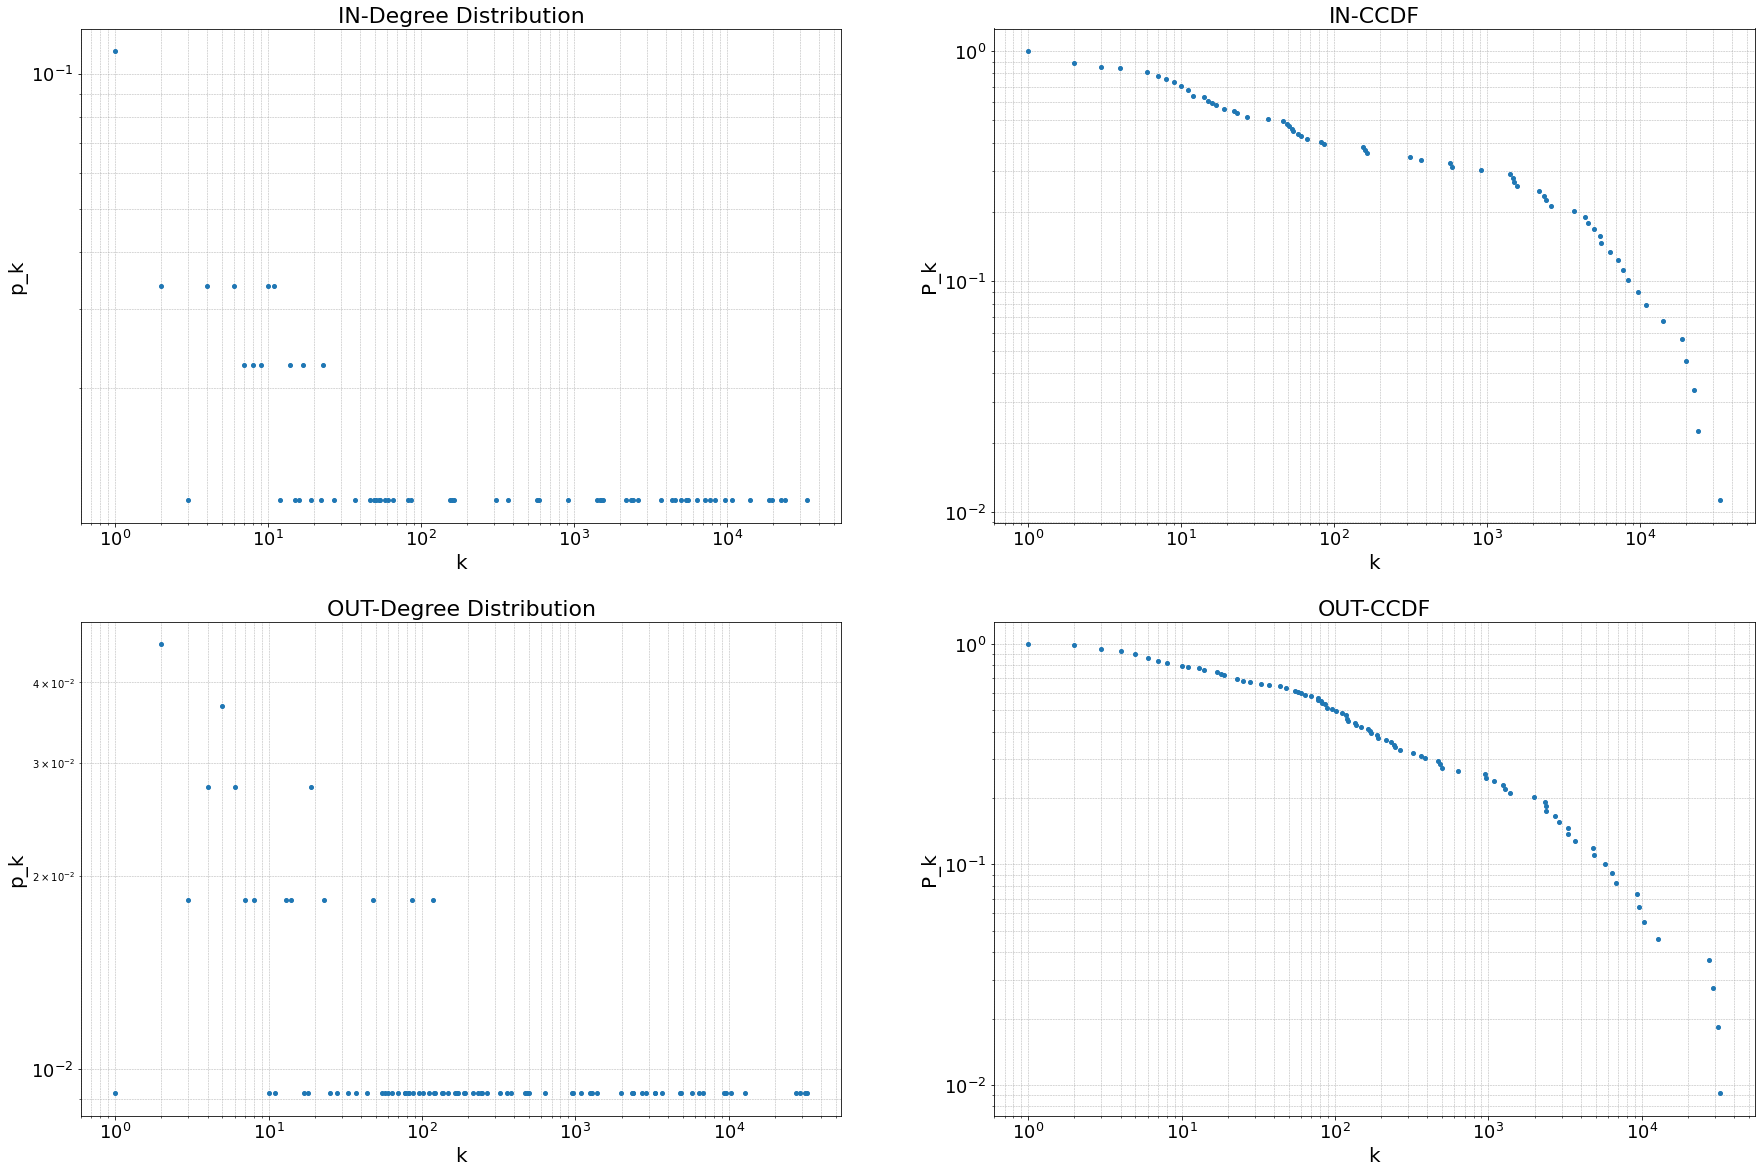

Top 10 for in degree


Nodes  in degree
48        Spain      33293
39      Germany      23798
8        France      22383
83        Italy      19833
30           UK      18794
51       Poland      14105
7      Portugal      10852
60  Netherlands       9731
42       Sweden       8345
94      Czechia       7736

Top 10 for out degree


Nodes  out degree
39      Germany       32334
48        Spain       31506
8        France       29317
83        Italy       27270
46       Turkey       12785
51       Poland       10401
30           UK        9578
60  Netherlands        9319
31      Belgium        6751
7      Portugal        6377

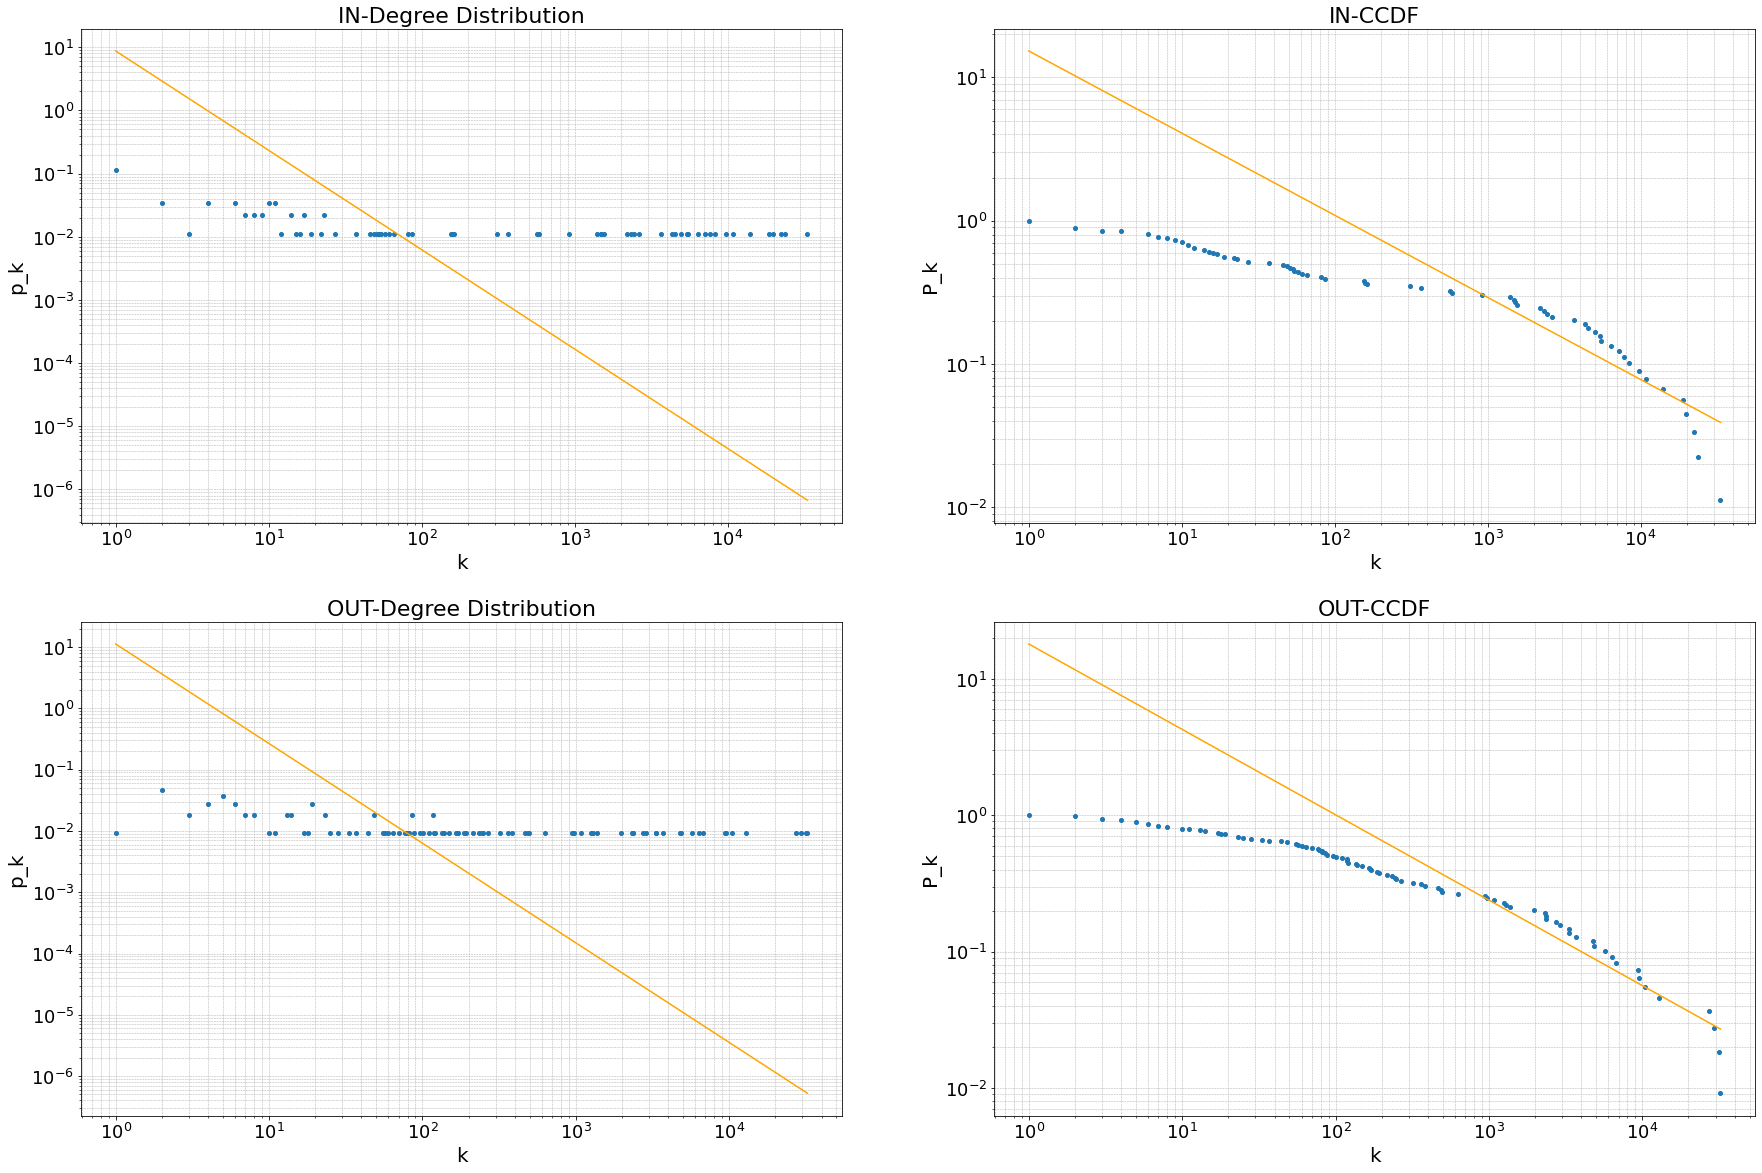

gamma_in = 1.5728906172718744
gamma_out = 1.6259076203624574


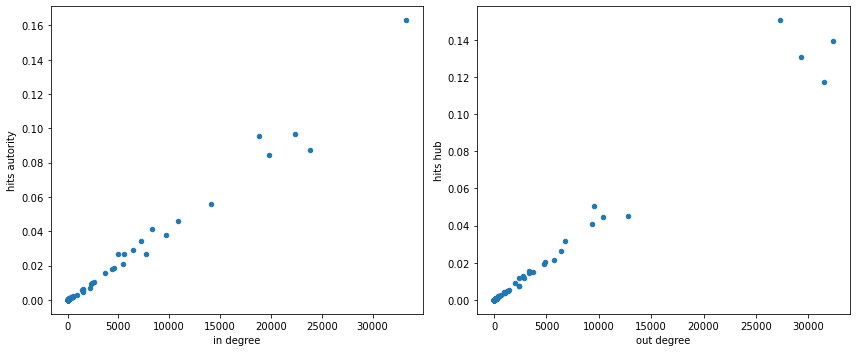

Top 10 for hits hub


Nodes  hits hub
83        Italy  0.150597
39      Germany  0.139633
8        France  0.131016
48        Spain  0.117437
30           UK  0.050395
46       Turkey  0.045201
51       Poland  0.044641
60  Netherlands  0.040668
31      Belgium  0.031715
7      Portugal  0.026263

Top 10 for hits autority


Nodes  hits autority
48        Spain       0.162945
8        France       0.096727
30           UK       0.095482
39      Germany       0.087375
83        Italy       0.084303
51       Poland       0.055721
7      Portugal       0.045732
42       Sweden       0.041256
60  Netherlands       0.038033
47      Finland       0.034068

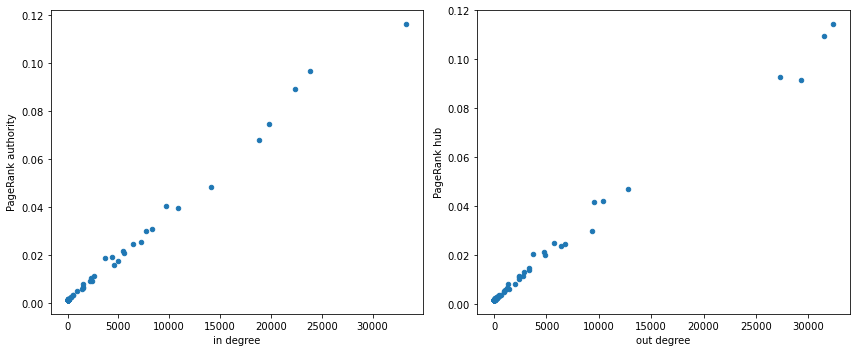

Top 10 for PageRank hub


Nodes  PageRank hub
39      Germany      0.114569
48        Spain      0.109729
83        Italy      0.092845
8        France      0.091482
46       Turkey      0.046980
51       Poland      0.042238
30           UK      0.041662
60  Netherlands      0.029906
94      Czechia      0.024756
31      Belgium      0.024384

Top 10 for PageRank authority


Nodes  PageRank authority
48        Spain            0.116533
39      Germany            0.096689
8        France            0.089403
83        Italy            0.074795
30           UK            0.068275
51       Poland            0.048501
60  Netherlands            0.040407
7      Portugal            0.039777
42       Sweden            0.030819
94      Czechia            0.029999

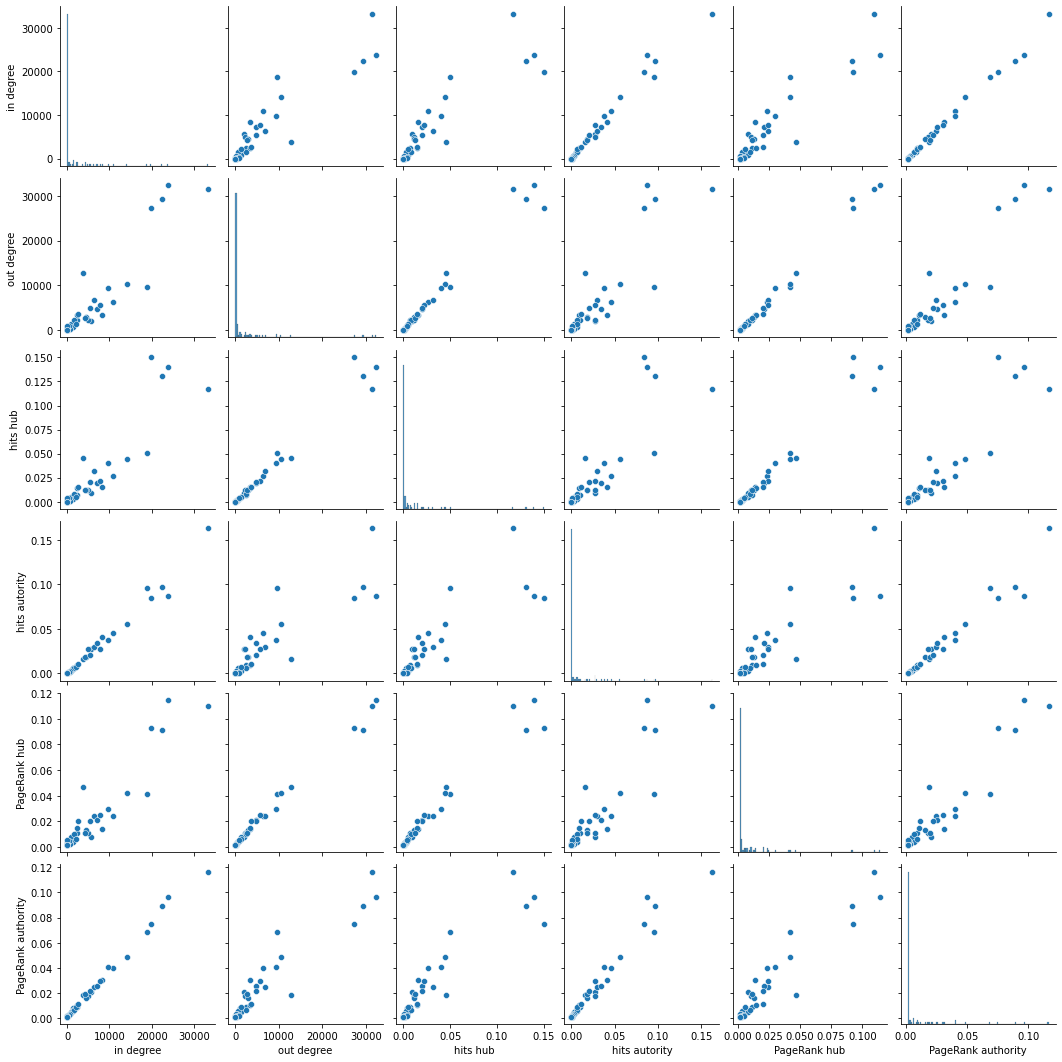

Nodes  in degree  in degree position  hits autority  \
48                Spain      33293                   1       0.162945   
39              Germany      23798                   2       0.087375   
8                France      22383                   3       0.096727   
83                Italy      19833                   4       0.084303   
30                   UK      18794                   5       0.095482   
51               Poland      14105                   6       0.055721   
60          Netherlands       9731                   8       0.038033   
7              Portugal      10852                   7       0.045732   
42               Sweden       8345                   9       0.041256   
94              Czechia       7736                  10       0.026969   
47              Finland       7179                  11       0.034068   
31              Belgium       6395                  12       0.029199   
98              Austria       5428                  14       0.020758   
11               Norway       5532                  13       0.026885   
92              Denmark       4341                  17       0.017851   
46               Turkey       3693                  18       0.015895   
19              Ireland       4999                  15       0.026967   
86              Hungary       4542                  16       0.018515   
108             Romania       2625                  19       0.010639   
88                   EL       2353                  21       0.008945   
106            Slovenia       2196                  22       0.006885   
84            Lithuania       2429                  20       0.009774   
4                Latvia       1500                  24       0.006364   
6               Croatia       1485                  25       0.004798   
91             Slovakia       1556                  23       0.005946   
40              Estonia       1408                  26       0.005928   
28             Bulgaria        916                  27       0.003091   
95              Iceland        586                  28       0.002462   
82               Cyprus        570                  29       0.001849   
65                Malta        311                  31       0.001155   
99   Russian Federation        368                  30       0.001684   
13        United States        159                  33       0.000595   
15               Serbia        163                  32       0.000558   
35           Luxembourg        155                  34       0.000800   
52               Israel         82                  36       0.000308   
44               Canada         86                  35       0.000393   
96                China         66                  37       0.000184   
32            Australia         61                  38       0.000333   
80              Morocco         58                  39       0.000304   
67   Korea, Republic of         49                  43       0.000137   

     hits autority position  PageRank authority  PageRank authority position  
48                        1            0.116533                            1  
39                        4            0.096689                            2  
8                         2            0.089403                            3  
83                        5            0.074795                            4  
30                        3            0.068275                            5  
51                        6            0.048501                            6  
60                        9            0.040407                            7  
7                         7            0.039777                            8  
42                        8            0.030819                            9  
94                       12            0.029999                           10  
47                       10            0.025510                           11  
31                       11            0.024832                           12

Nodes  out degree  out degree position  hits hub  \
39              Germany       32334                    1  0.139633   
48                Spain       31506                    2  0.117437   
83                Italy       27270                    4  0.150597   
8                France       29317                    3  0.131016   
46               Turkey       12785                    5  0.045201   
51               Poland       10401                    6  0.044641   
30                   UK        9578                    7  0.050395   
60          Netherlands        9319                    8  0.040668   
94              Czechia        5721                   11  0.021545   
31              Belgium        6751                    9  0.031715   
7              Portugal        6377                   10  0.026263   
47              Finland        4781                   13  0.019474   
108             Romania        3678                   14  0.014823   
98              Austria        4873                   12  0.020217   
88                   EL        3310                   16  0.014303   
42               Sweden        3319                   15  0.015275   
86              Hungary        2887                   17  0.011807   
84            Lithuania        2359                   20  0.007445   
92              Denmark        2720                   18  0.012691   
19              Ireland        2333                   21  0.011820   
91             Slovakia        2368                   19  0.007646   
11               Norway        1979                   22  0.008815   
28             Bulgaria        1290                   24  0.004872   
6               Croatia        1251                   25  0.004658   
106            Slovenia        1381                   23  0.005118   
4                Latvia        1085                   26  0.003462   
107             Ukraine         945                   28  0.003750   
99   Russian Federation         969                   27  0.004081   
40              Estonia         632                   29  0.002337   
15               Serbia         496                   30  0.001893   
35           Luxembourg         485                   31  0.002327   
96                China         468                   32  0.002004   
36              Georgia         361                   34  0.001258   
80              Morocco         383                   33  0.001900   
82               Cyprus         321                   35  0.000758   
66           Kazakhstan         247                   37  0.000918   
71              Tunisia         266                   36  0.001248   
102     North Macedonia         191                   41  0.000417   
87              Albania         187                   42  0.000763   
16               Jordan         148                   46  0.000516   

     hits hub position  PageRank hub  PageRank hub position  
39                   2      0.114569                      1  
48                   4      0.109729                      2  
83                   1      0.092845                      3  
8                    3      0.091482                      4  
46                   6      0.046980                      5  
51                   7      0.042238                      6  
30                   5      0.041662                      7  
60                   8      0.029906                      8  
94                  11      0.024756                      9  
31                   9      0.024384                     10  
7                   10      0.023881                     11  
47                  13      0.021154                     12  
108                 15      0.020380                     13  
98                  12      0.020145                     14  
88                  16      0.014628                     15  
42                  14      0.014002                     16  
86                  19      0.013235                     17  
84                  22      0.0

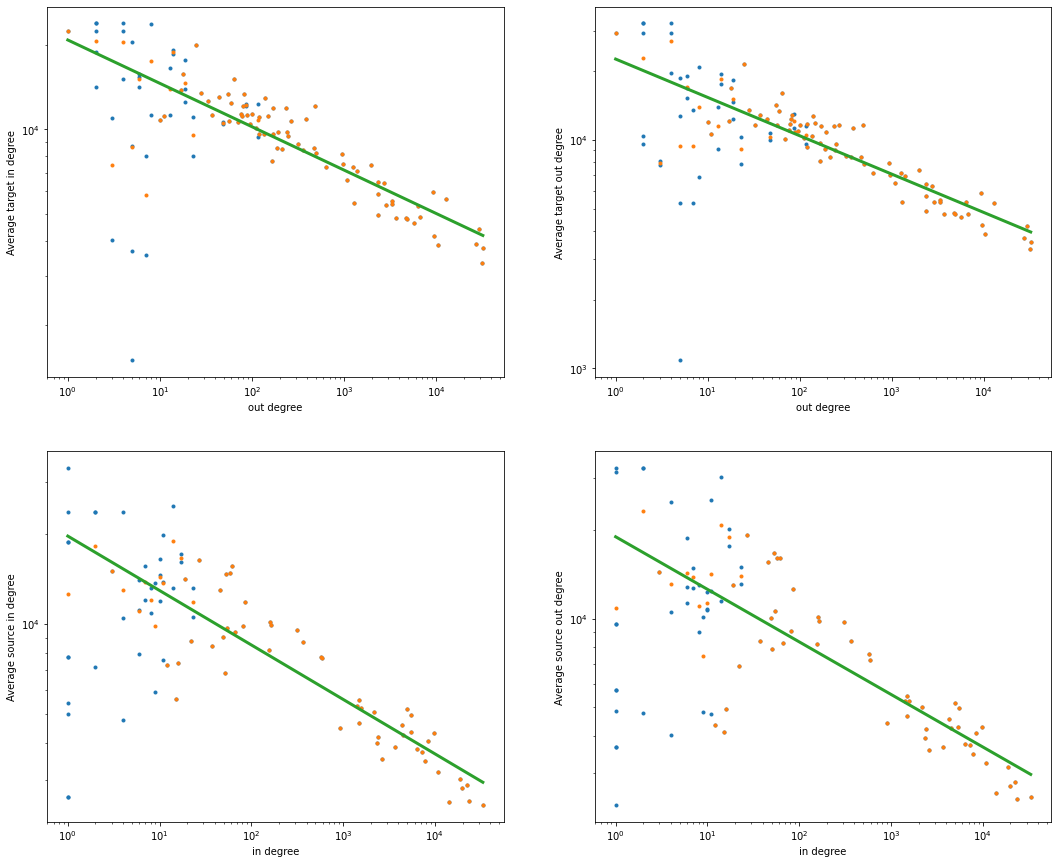

(-0.1544304249297988, -0.16778856685274204, -0.18258937454941349, -0.17804032141718953)


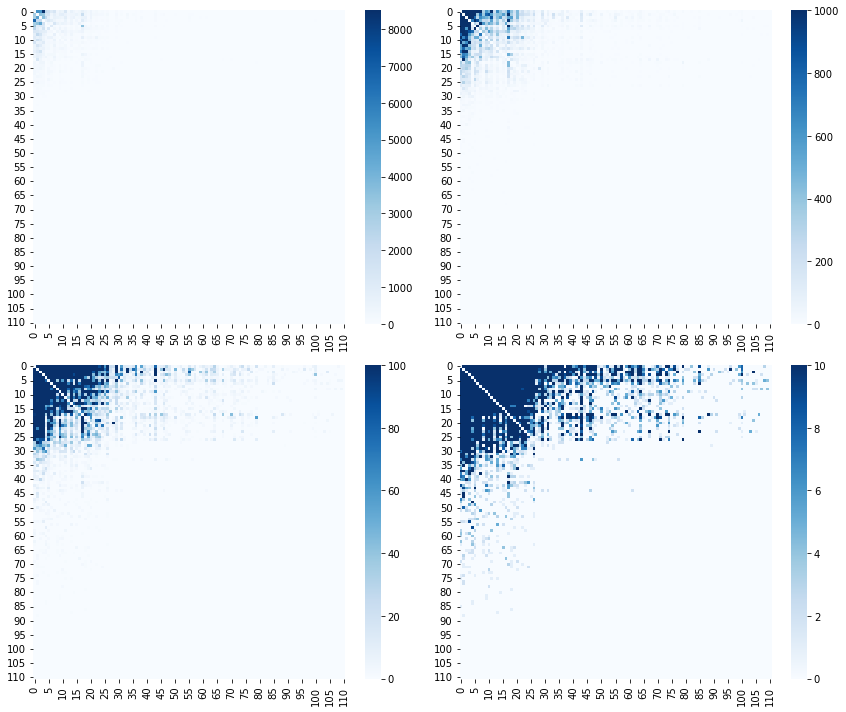

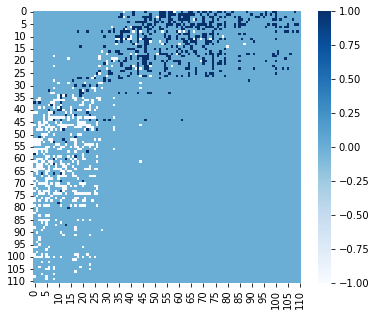

Nodes  Community
4                               Latvia          0
7                             Portugal          0
8                               France          0
9                           Madagascar          0
10           Taiwan, Province of China          0
14                             Algeria          0
20                               Egypt          0
23   Venezuela, Bolivarian Republic of          0
26              Bosnia and Herzegovina          0
35                          Luxembourg          0
37                        South Africa          0
42                              Sweden          0
55                               Japan          0
58    Lao People's Democratic Republic          0
62                               Libya          0
63                            Cambodia          0
66                          Kazakhstan          0
69                            Honduras          0
71                             Tunisia          0
72                             Myanmar          0
77                            Thailand          0
79                          Uzbekistan          0
80                             Morocco          0
81                            Mongolia          0
82                              Cyprus          0
83                               Italy          0
84                           Lithuania          0
86                             Hungary          0
87                             Albania          0
99                  Russian Federation          0
102                    North Macedonia          0
103                       Burkina Faso          0
104               Moldova, Republic of          0
108                            Romania          0

Nodes  Community
1           Bangladesh          1
5          New Zealand          1
13       United States          1
15              Serbia          1
18               Nepal          1
19             Ireland          1
21                Peru          1
22           Indonesia          1
24              Uganda          1
27            Paraguay          1
28            Bulgaria          1
33            Colombia          1
36             Georgia          1
39             Germany          1
47             Finland          1
49          Azerbaijan          1
50       Liechtenstein          1
57                Cuba          1
60         Netherlands          1
61             Lebanon          1
65               Malta          1
67  Korea, Republic of          1
73            Viet Nam          1
78            Barbados          1
85            Ethiopia          1
88                  EL          1
92             Denmark          1
93              Mexico          1
97               Gabon          1

Nodes  Community
2      Sri Lanka          2
6        Croatia          2
11        Norway          2
12    Montenegro          2
25    Costa Rica          2
34      Pakistan          2
40       Estonia          2
41       Armenia          2
43        Brazil          2
46        Turkey          2
52        Israel          2
54    Tajikistan          2
70   Afghanistan          2
90    Kyrgyzstan          2
91      Slovakia          2
94       Czechia          2
95       Iceland          2
96         China          2
98       Austria          2
100           XK          2
101    Nicaragua          2
105      Belarus          2
106     Slovenia          2
107      Ukraine          2
109       Bhutan          2

Nodes  Community
3                       Hong Kong          3
16                         Jordan          3
17                      Argentina          3
29                          Chile          3
30                             UK          3
31                        Belgium          3
32                      Australia          3
38                      Guatemala          3
44                         Canada          3
45   Tanzania, United Republic of          3
48                          Spain          3
51                         Poland          3
53            Palestine, State of          3
56                       Malaysia          3
59                          India          3
64                    Philippines          3
68                        Ecuador          3
74                          Macao          3
75           Syrian Arab Republic          3
76                    El Salvador          3
89                      Singapore          3
110                       Uruguay          3

Nodes  Community
0   nan          4

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
16          Turkey                          7107650.0
13         Germany                          2625241.0
10  United Kingdom                          2263020.0
23           Italy                          1797986.0
18           Spain                          1491419.0
20          Poland                          1418588.0
21     Netherlands                           720583.0
27          Greece                           704969.0
15          Sweden                           438578.0
2         Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.717710e-07
3          Romania   1.511653e-07
4         Slovenia   1.152472e-07
5          Belgium   1.057105e-07
6        Lithuania   9.866581e-08
7         Slovakia   8.973590e-08
8          Czechia   8.346247e-08
9          Estonia   8.291044e-08
10         Finland   7.646203e-08
11        Portugal   7.382788e-08
12           Spain   7.357377e-08
13          Latvia   7.331518e-08
14         Ireland   5.386471e-08
15       Macedonia   5.314523e-08
16           Italy   5.163831e-08
17         Hungary   4.757780e-08
18         Denmark   4.379717e-08
19         Germany   4.364116e-08
20     Netherlands   4.150309e-08
21         Croatia   4.039316e-08
22        Bulgaria   3.441266e-08
23          Sweden   3.192481e-08
24          Poland   2.977437e-08
25          Norway   2.974320e-08
26          Greece   2.075026e-08
27  United Kingdom   1.840972e-08
28         Albania   1.810482e-08
29          Serbia   1.538392e-08
30          Turkey   6.609799e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1            Malta   2.000000e-07
2       Luxembourg   2.000000e-07
3         Slovenia   1.770698e-07
4          Estonia   1.354579e-07
5         Portugal   1.229693e-07
6          Belgium   1.076548e-07
7           Latvia   1.012808e-07
8          Czechia   1.011389e-07
9          Finland   9.220635e-08
10         Ireland   8.860261e-08
11         Romania   8.548312e-08
12       Lithuania   8.028789e-08
13           Spain   7.813569e-08
14          Norway   7.703323e-08
15         Denmark   7.497805e-08
16          Sweden   7.027031e-08
17        Slovakia   5.790980e-08
18         Hungary   5.702243e-08
19     Netherlands   5.607551e-08
20         Croatia   4.256757e-08
21           Italy   4.159941e-08
22         Germany   3.683066e-08
23          Poland   3.418965e-08
24       Macedonia   3.134522e-08
25  United Kingdom   3.016992e-08
26        Bulgaria   2.138097e-08
27          Greece   1.483537e-08
28         Albania   1.047136e-08
29          Serbia   8.028754e-09
30          Turkey   2.630136e-09
31     Switzerland   0.000000e+00

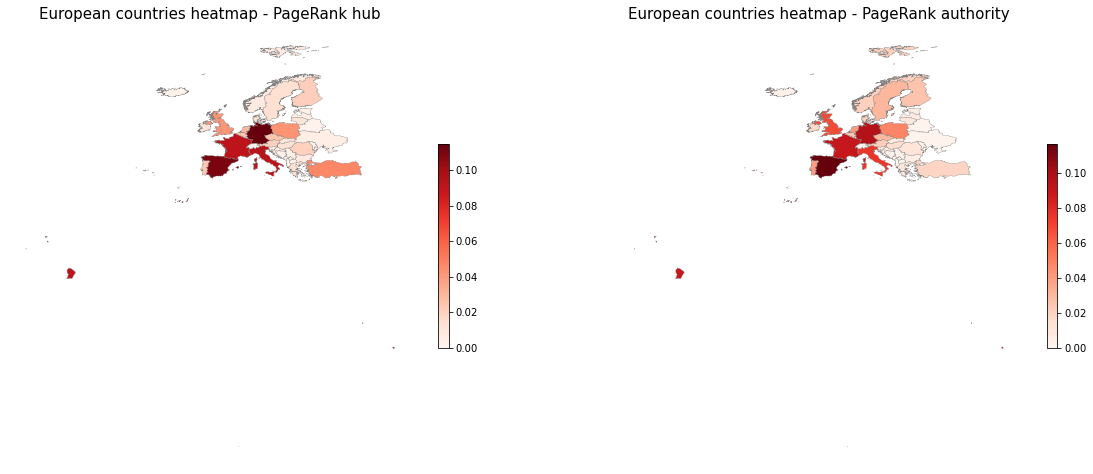

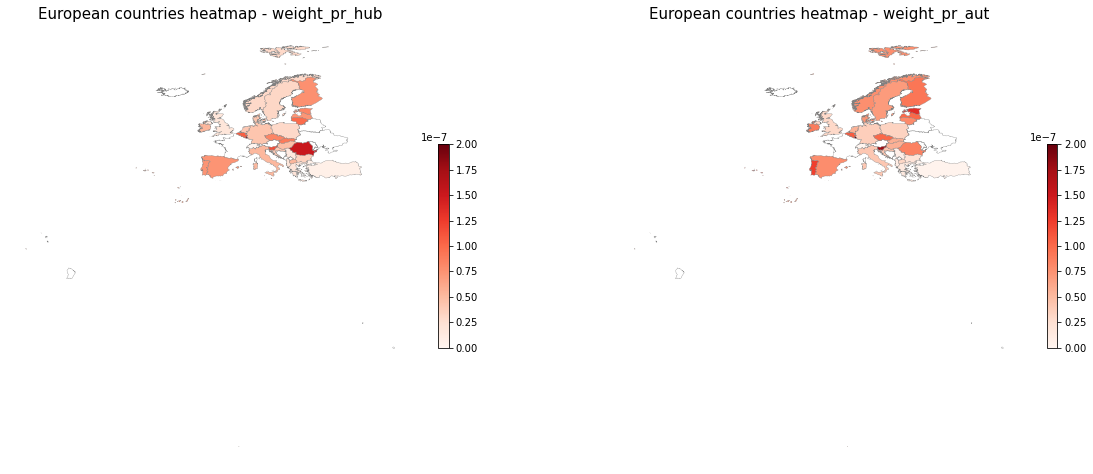

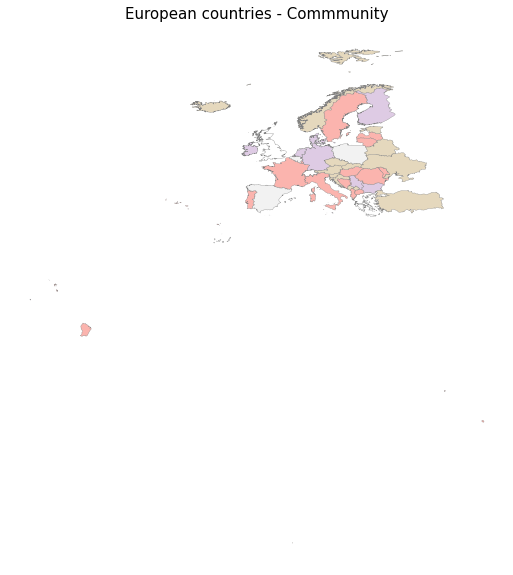

In [7]:
country16_df = pd.read_csv('data\Erasmus16.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country16_df)

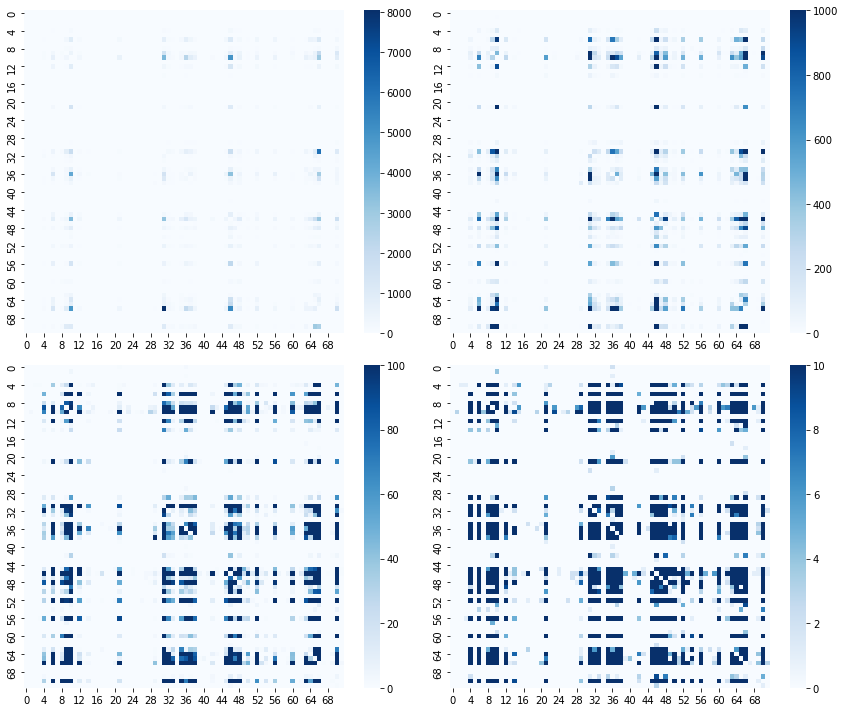

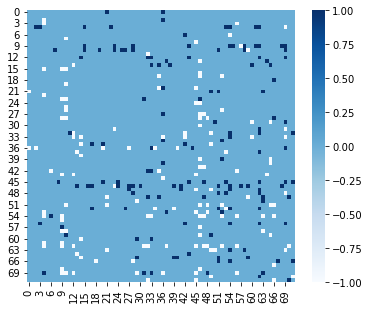

Number of components = 1


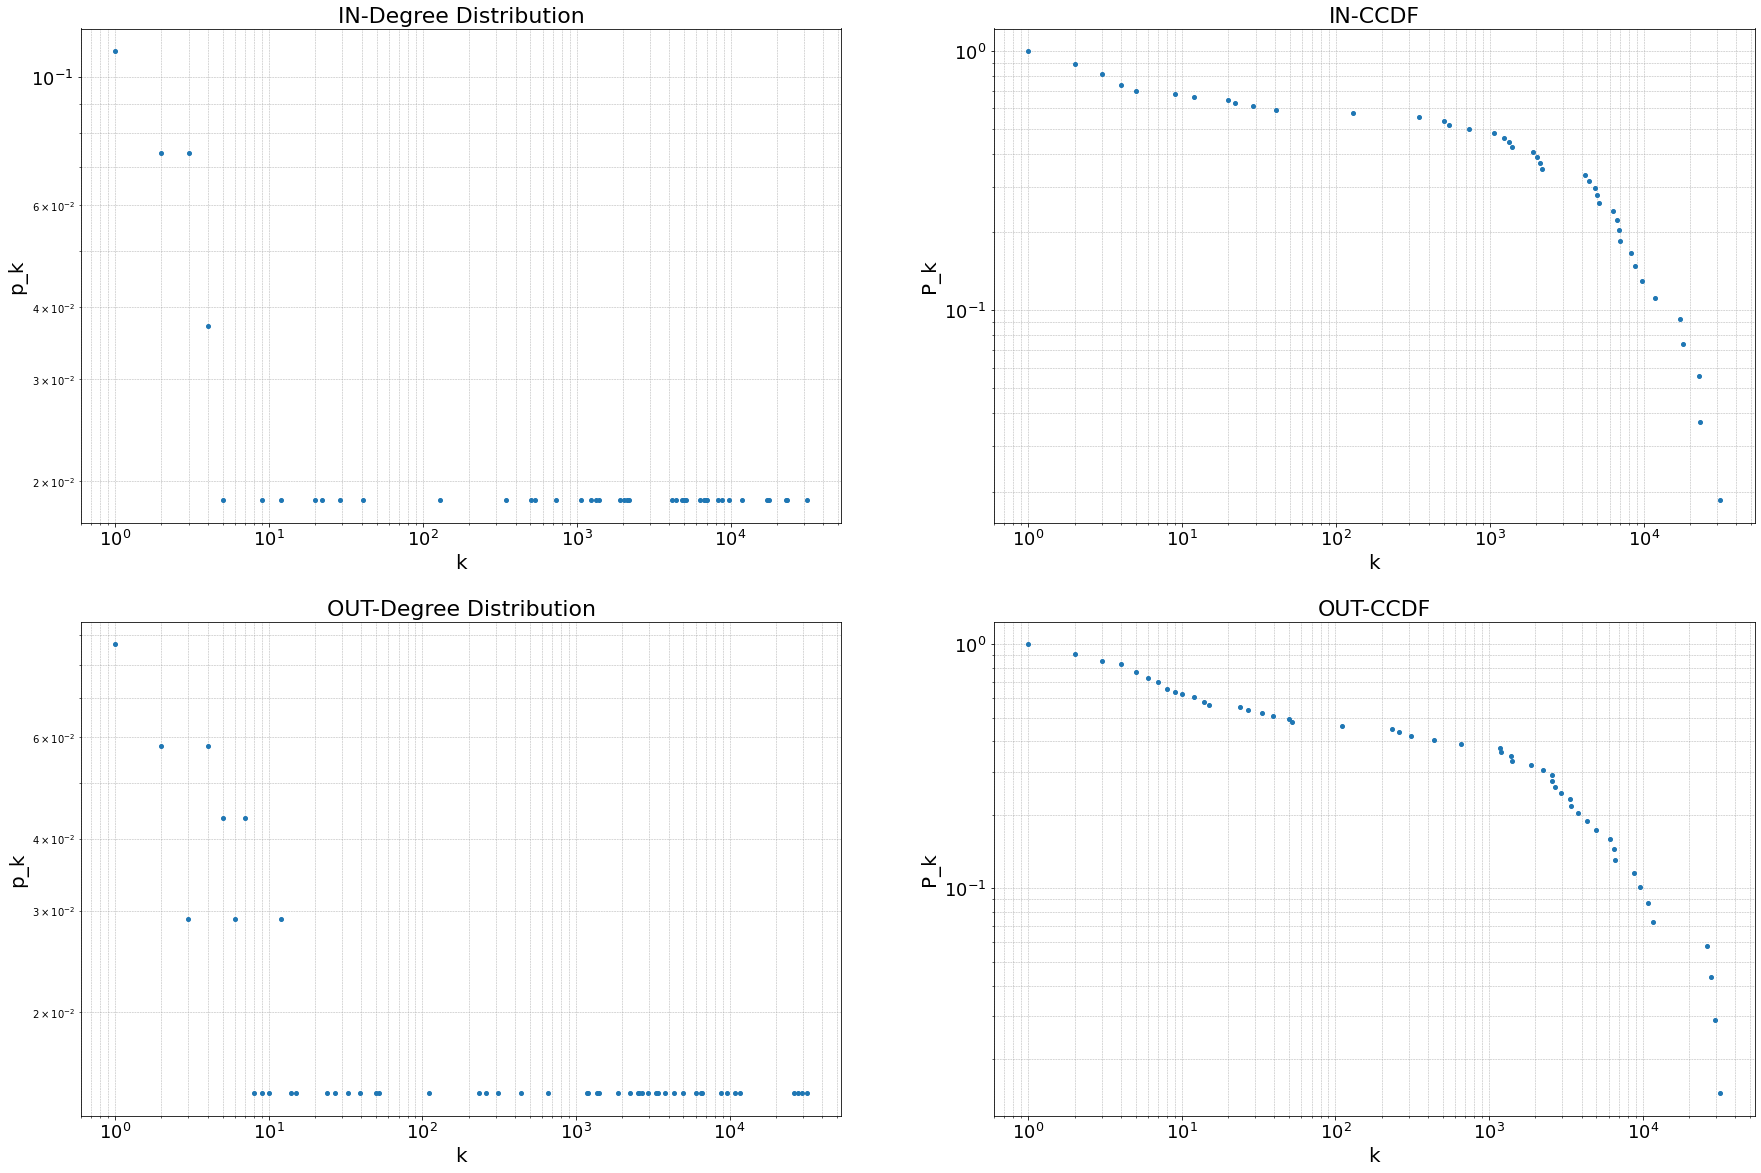

Top 10 for in degree


Nodes  in degree
66        Spain      31328
46      Germany      23334
10       France      22774
36           UK      17896
31        Italy      17313
70       Poland      11915
9      Portugal       9770
6   Netherlands       8832
56       Sweden       8277
64      Finland       6992

Top 10 for out degree


Nodes  out degree
46      Germany       31842
66        Spain       29491
10       France       27790
31        Italy       26119
65       Turkey       11601
70       Poland       10874
36           UK        9630
6   Netherlands        8838
37      Belgium        6641
48      Czechia        6492

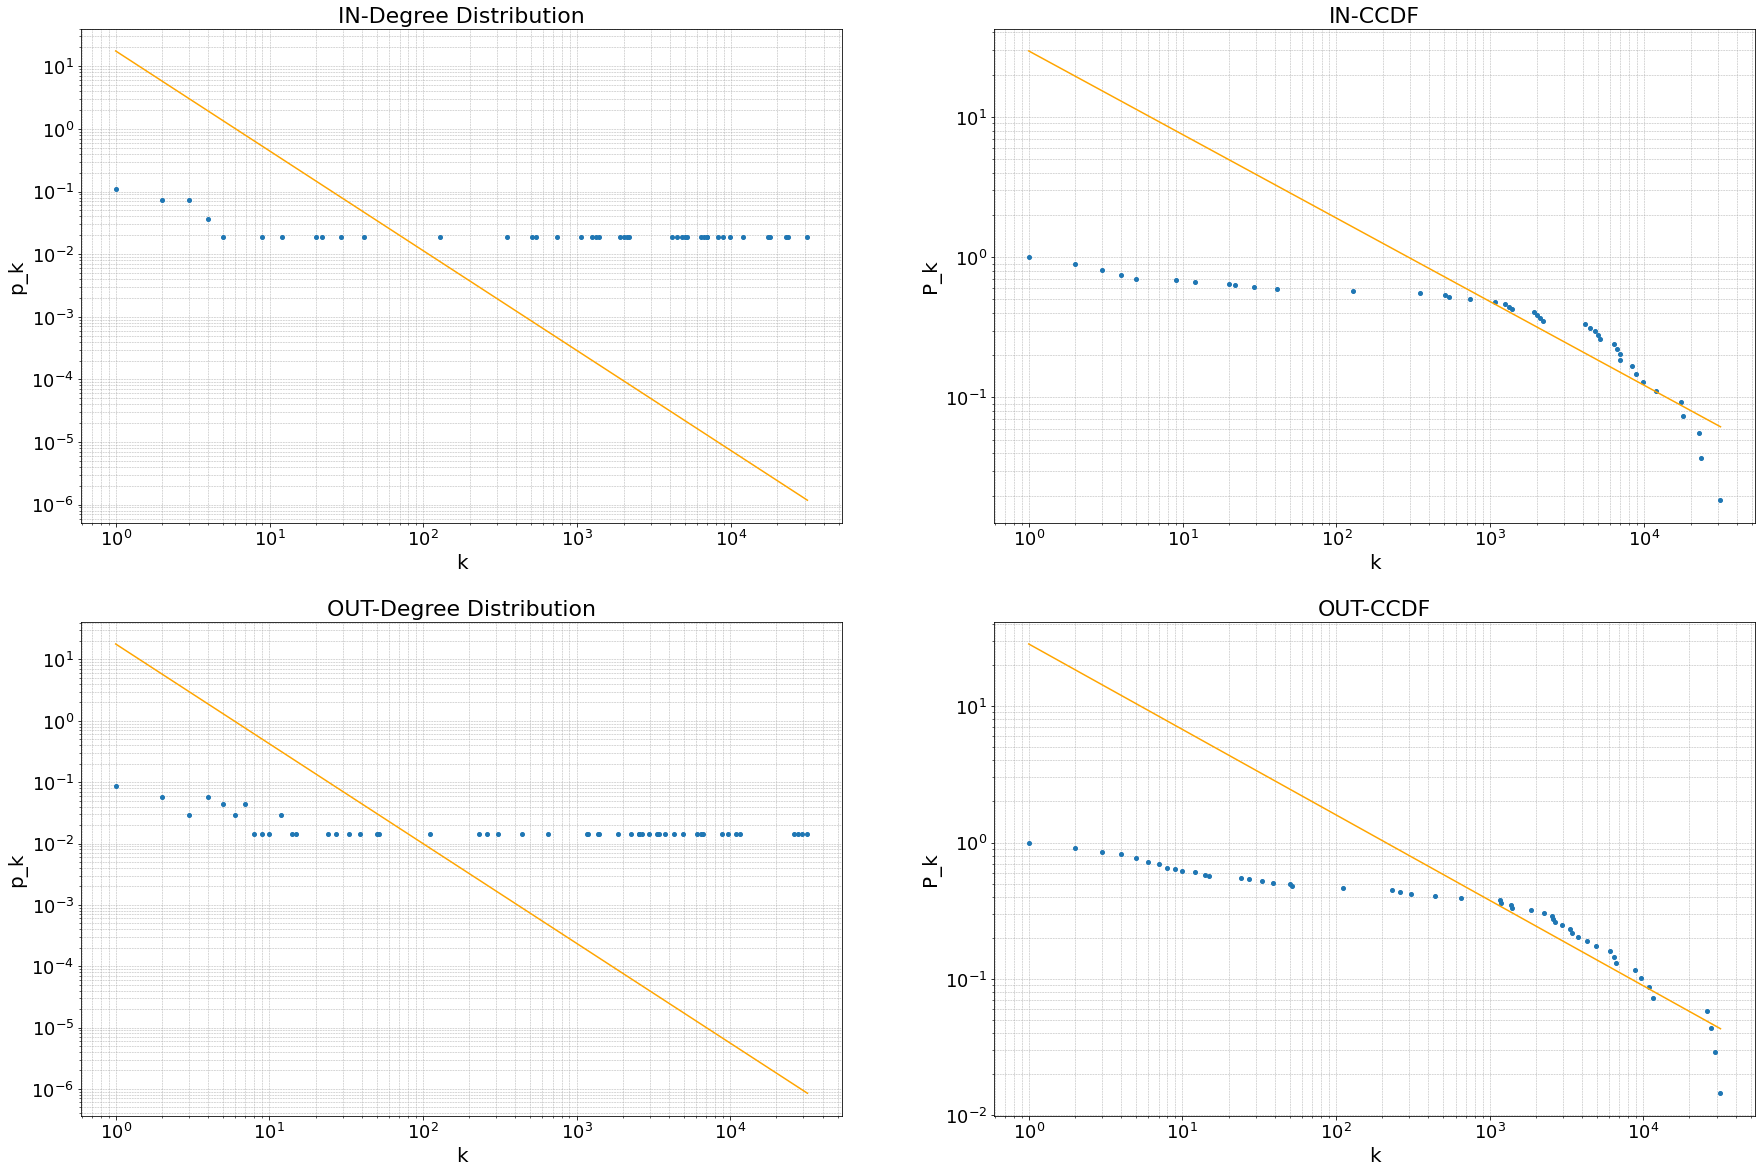

gamma_in = 1.5958788399212063
gamma_out = 1.6266161029533694


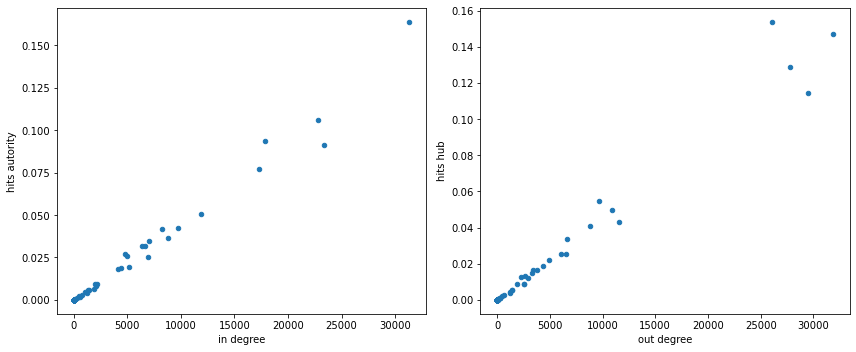

Top 10 for hits hub


Nodes  hits hub
31        Italy  0.153959
46      Germany  0.147386
10       France  0.128948
66        Spain  0.114324
36           UK  0.054692
70       Poland  0.049684
65       Turkey  0.042843
6   Netherlands  0.040712
37      Belgium  0.033620
9      Portugal  0.025642

Top 10 for hits autority


Nodes  hits autority
66        Spain       0.164030
10       France       0.106196
36           UK       0.093642
46      Germany       0.091452
31        Italy       0.076907
70       Poland       0.050483
9      Portugal       0.042417
56       Sweden       0.041725
6   Netherlands       0.036388
64      Finland       0.034568

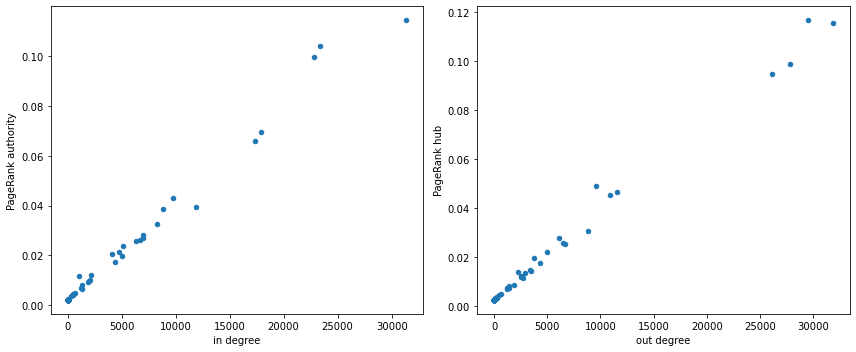

Top 10 for PageRank hub


Nodes  PageRank hub
66        Spain      0.116762
46      Germany      0.115689
10       France      0.098750
31        Italy      0.094661
36           UK      0.048974
65       Turkey      0.046628
70       Poland      0.045302
6   Netherlands      0.030773
9      Portugal      0.028010
48      Czechia      0.026003

Top 10 for PageRank authority


Nodes  PageRank authority
66        Spain            0.114362
46      Germany            0.104124
10       France            0.099493
36           UK            0.069481
31        Italy            0.066042
9      Portugal            0.042854
70       Poland            0.039454
6   Netherlands            0.038527
56       Sweden            0.032644
48      Czechia            0.028223

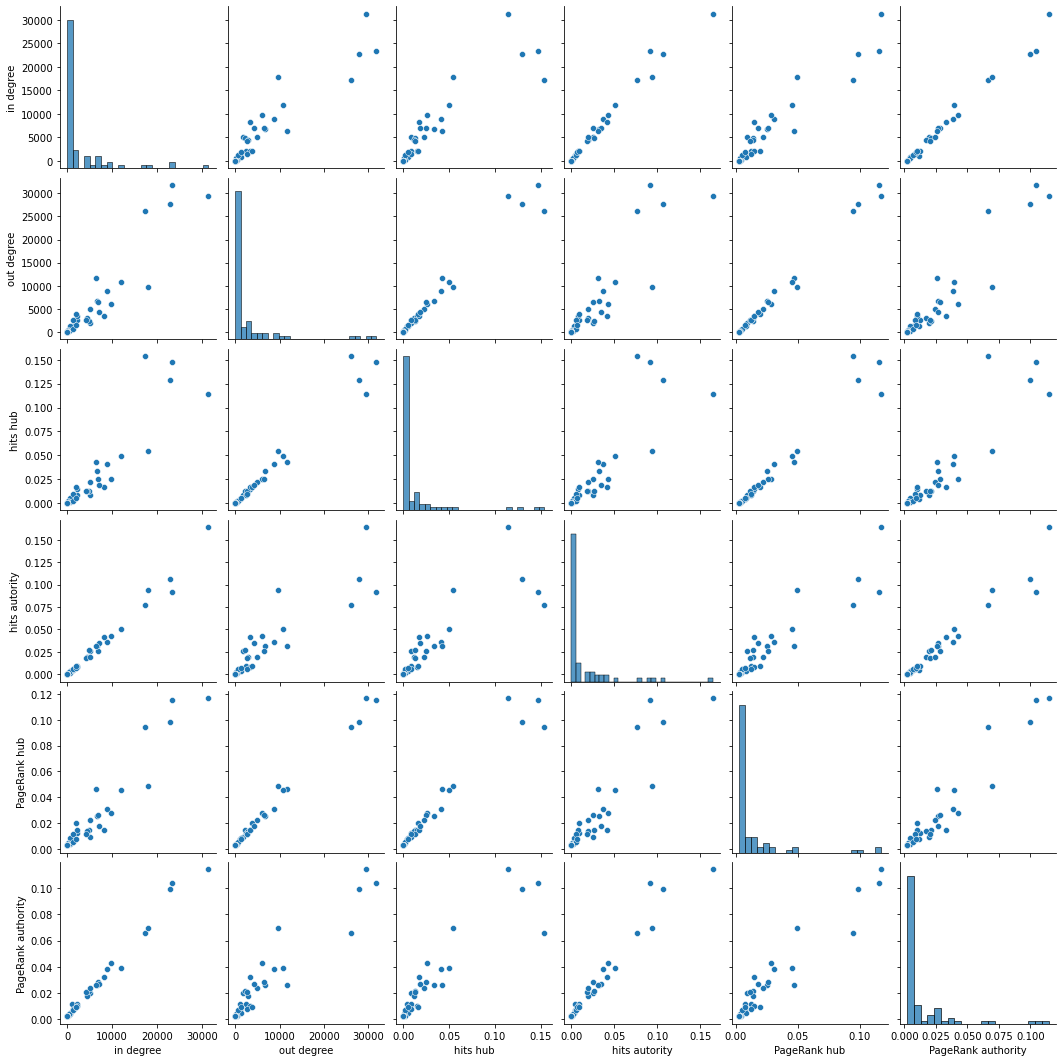

Nodes  in degree  in degree position  hits autority  \
66               Spain      31328                   1       0.164030   
46             Germany      23334                   2       0.091452   
10              France      22774                   3       0.106196   
36                  UK      17896                   4       0.093642   
31               Italy      17313                   5       0.076907   
9             Portugal       9770                   7       0.042417   
70              Poland      11915                   6       0.050483   
6          Netherlands       8832                   8       0.036388   
56              Sweden       8277                   9       0.041725   
48             Czechia       6950                  11       0.025480   
64             Finland       6992                  10       0.034568   
37             Belgium       6689                  12       0.031768   
65              Turkey       6356                  13       0.031474   
52             Austria       5143                  14       0.019585   
21             Ireland       4808                  16       0.026830   
45             Denmark       4153                  18       0.018201   
12              Norway       5003                  15       0.025615   
35             Hungary       4419                  17       0.019052   
32           Lithuania       2185                  19       0.009079   
4               Latvia       1065                  26       0.004839   
38                  EL       2115                  20       0.008328   
63             Romania       2014                  21       0.009355   
60            Slovenia       1910                  22       0.006646   
47            Slovakia       1387                  23       0.005585   
8              Croatia       1242                  25       0.004221   
50             Estonia       1326                  24       0.006006   
33            Bulgaria        735                  27       0.003097   
29              Cyprus        539                  28       0.001746   
49             Iceland        505                  29       0.002442   
14               Malta        347                  30       0.001382   
42          Luxembourg        129                  31       0.000776   
69       Liechtenstein         41                  32       0.000120   
53  Russian Federation         29                  33       0.000149   
13       United States         22                  34       0.000115   
54     North Macedonia         20                  35       0.000052   
20  Korea, Republic of         12                  36       0.000044   
59              Canada          9                  37       0.000041   
57              Brazil          5                  38       0.000007   
0            Hong Kong          3                  44       0.000007   
27            Thailand          3                  42       0.000009   

    hits autority position  PageRank authority  PageRank authority position  
66                       1            0.114362                            1  
46                       4            0.104124                            2  
10                       2            0.099493                            3  
36                       3            0.069481                            4  
31                       5            0.066042                            5  
9                        7            0.042854                            6  
70                       6            0.039454                            7  
6                        9            0.038527                            8  
56                       8            0.032644                            9  
48                      15            0.028223                           10  
64                      10            0.026799                           11  
37                      11            0.026297                           12  
65                      12            0.025807    

Nodes  out degree  out degree position  hits hub  \
66               Spain       29491                    2  0.114324   
46             Germany       31842                    1  0.147386   
10              France       27790                    3  0.128948   
31               Italy       26119                    4  0.153959   
36                  UK        9630                    7  0.054692   
65              Turkey       11601                    5  0.042843   
70              Poland       10874                    6  0.049684   
6          Netherlands        8838                    8  0.040712   
9             Portugal        6081                   11  0.025642   
48             Czechia        6492                   10  0.025322   
37             Belgium        6641                    9  0.033620   
52             Austria        4940                   12  0.022294   
63             Romania        3770                   14  0.016433   
64             Finland        4329                   13  0.018747   
38                  EL        3337                   16  0.015089   
56              Sweden        3436                   15  0.016781   
21             Ireland        2255                   21  0.012472   
35             Hungary        2944                   17  0.012341   
32           Lithuania        2550                   20  0.008745   
47            Slovakia        2568                   19  0.009045   
45             Denmark        2683                   18  0.013080   
12              Norway        1869                   22  0.008825   
33            Bulgaria        1378                   24  0.005649   
60            Slovenia        1407                   23  0.005383   
8              Croatia        1191                   25  0.004348   
4               Latvia        1173                   26  0.003807   
50             Estonia         653                   27  0.002497   
42          Luxembourg         439                   28  0.002321   
29              Cyprus         310                   29  0.001054   
49             Iceland         260                   30  0.000968   
14               Malta         232                   31  0.000957   
54     North Macedonia         111                   32  0.000276   
62             Ukraine          52                   33  0.000180   
53  Russian Federation          50                   34  0.000287   
28             Morocco          39                   35  0.000230   
51               China          33                   36  0.000170   
17              Serbia          24                   38  0.000109   
69       Liechtenstein          27                   37  0.000098   
15             Algeria          14                   40  0.000031   
59              Canada          12                   42  0.000070   

    hits hub position  PageRank hub  PageRank hub position  
66                  4      0.116762                      1  
46                  2      0.115689                      2  
10                  3      0.098750                      3  
31                  1      0.094661                      4  
36                  5      0.048974                      5  
65                  7      0.046628                      6  
70                  6      0.045302                      7  
6                   8      0.030773                      8  
9                  10      0.028010                      9  
48                 11      0.026003                     10  
37                  9      0.025457                     11  
52                 12      0.022232                     12  
63                 15      0.019659                     13  
64                 13      0.017803                     14  
38                 16      0.014721                     15  
56                 14      0.014326                     16  
21                 18      0.014202                     17  
35                 19      0.013761                     18  
32                 22      0

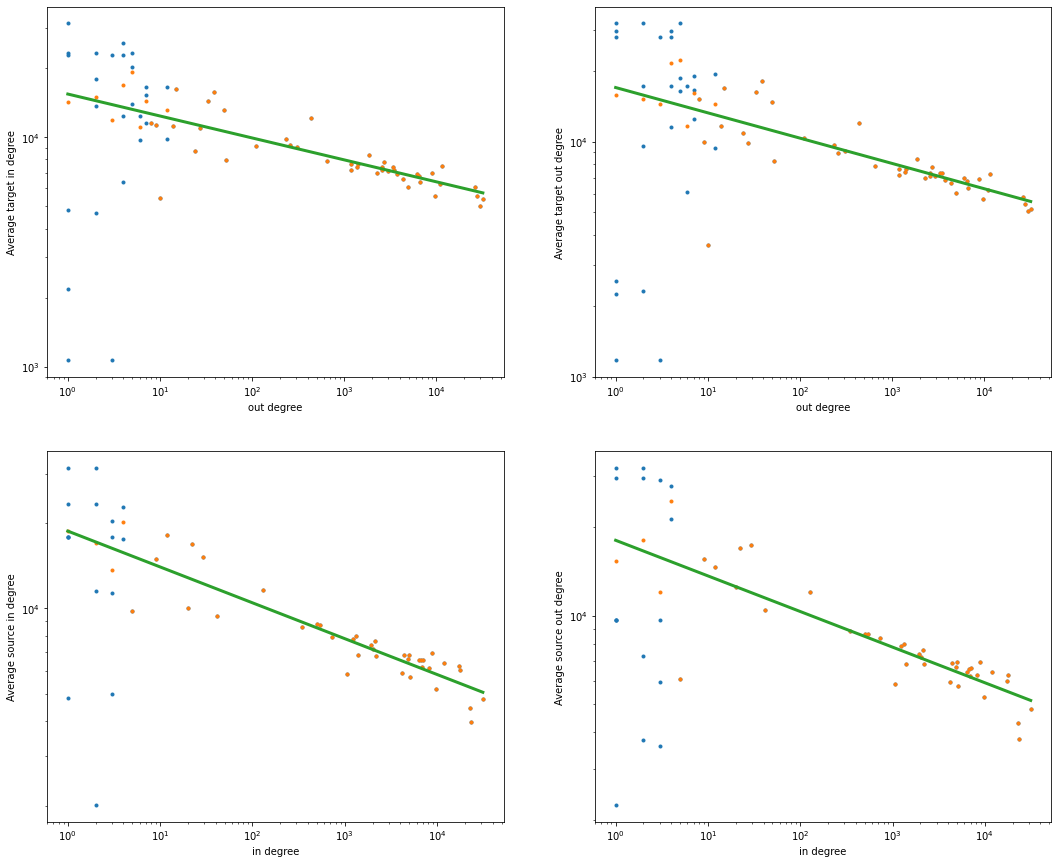

(-0.09567862679402746, -0.10766937303520784, -0.1268215594385636, -0.12154368544529677)


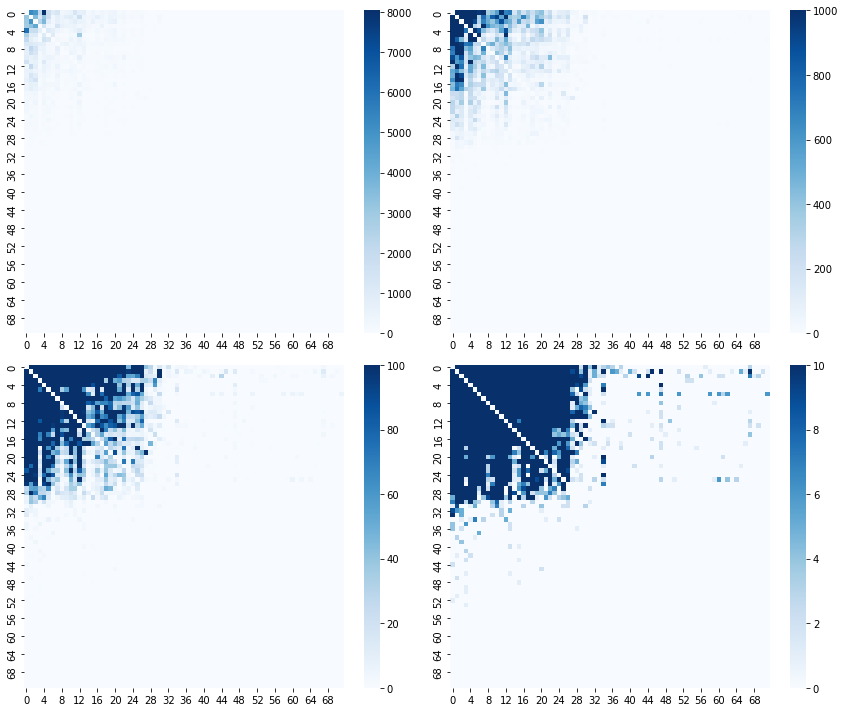

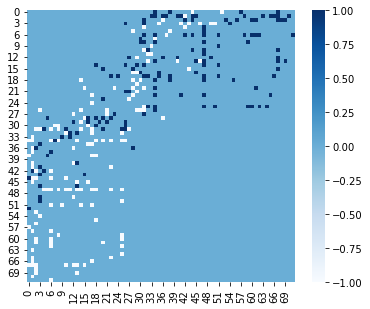

Nodes  Community
3                       India          0
6                 Netherlands          0
8                     Croatia          0
11  Taiwan, Province of China          0
12                     Norway          0
14                      Malta          0
17                     Serbia          0
24                      Egypt          0
29                     Cyprus          0
31                      Italy          0
32                  Lithuania          0
33                   Bulgaria          0
35                    Hungary          0
37                    Belgium          0
38                         EL          0
42                 Luxembourg          0
45                    Denmark          0
48                    Czechia          0
50                    Estonia          0
56                     Sweden          0
58       Moldova, Republic of          0
60                   Slovenia          0
62                    Ukraine          0
63                    Romania          0
64                    Finland          0
69              Liechtenstein          0
70                     Poland          0
71                     Israel          0

Nodes  Community
1                Japan          1
7              Lebanon          1
10              France          1
13       United States          1
18              Jordan          1
20  Korea, Republic of          1
25            Viet Nam          1
26           Indonesia          1
49             Iceland          1
51               China          1
52             Austria          1
53  Russian Federation          1
59              Canada          1
66               Spain          1
67             Uruguay          1

Nodes  Community
9                 Portugal          2
16              Kazakhstan          2
23                 Tunisia          2
27                Thailand          2
28                 Morocco          2
30  Bosnia and Herzegovina          2
41              Kyrgyzstan          2
43                 Georgia          2
46                 Germany          2
47                Slovakia          2
54         North Macedonia          2
55                 Armenia          2
57                  Brazil          2
68              Azerbaijan          2

Nodes  Community
0      Hong Kong          3
5    New Zealand          3
19     Argentina          3
21       Ireland          3
34         Chile          3
36            UK          3
39     Australia          3
40     Singapore          3
44  South Africa          3
65        Turkey          3

Nodes  Community
2   Malaysia          4
4     Latvia          4
15   Algeria          4
22     Nepal          4
61   Belarus          4

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
33          Turkey                          7107650.0
19         Germany                          2625241.0
14  United Kingdom                          2263020.0
10           Italy                          1797986.0
34           Spain                          1491419.0
36          Poland                          1418588.0
1      Netherlands                           720583.0
16          Greece                           704969.0
26          Sweden                           438578.0
3         Portugal                           323467.0

country  weight_pr_hub
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2            Malta   2.000000e-07
3         Slovenia   1.461950e-07
4          Romania   1.458174e-07
5          Belgium   1.103613e-07
6        Lithuania   1.081824e-07
7          Estonia   1.071431e-07
8         Slovakia   1.054367e-07
9           Latvia   9.279777e-08
10         Czechia   8.766619e-08
11        Portugal   8.659352e-08
12           Spain   7.828899e-08
13         Ireland   7.065396e-08
14       Macedonia   6.588155e-08
15         Finland   6.434946e-08
16           Italy   5.264814e-08
17         Hungary   4.946756e-08
18         Denmark   4.570027e-08
19         Croatia   4.558587e-08
20         Germany   4.406799e-08
21     Netherlands   4.270612e-08
22        Bulgaria   3.558353e-08
23          Sweden   3.266394e-08
24          Norway   3.250385e-08
25          Poland   3.193459e-08
26  United Kingdom   2.164089e-08
27          Greece   2.088241e-08
28          Serbia   1.167707e-08
29          Turkey   6.560308e-09
30     Switzerland   0.000000e+00

country  weight_pr_aut
0       Luxembourg   2.000000e-07
1            Malta   2.000000e-07
2    Liechtenstein   2.000000e-07
3         Slovenia   1.747029e-07
4           Latvia   1.504565e-07
5          Estonia   1.484368e-07
6         Portugal   1.324825e-07
7          Belgium   1.140064e-07
8          Ireland   1.055553e-07
9        Lithuania   1.043529e-07
10         Finland   9.686751e-08
11         Czechia   9.515131e-08
12         Denmark   7.949865e-08
13           Spain   7.667993e-08
14          Sweden   7.443156e-08
15          Norway   7.321852e-08
16        Slovakia   7.199844e-08
17         Romania   7.093829e-08
18         Hungary   6.280841e-08
19     Netherlands   5.346593e-08
20       Macedonia   4.553254e-08
21         Croatia   4.304839e-08
22         Germany   3.966272e-08
23           Italy   3.673111e-08
24  United Kingdom   3.070285e-08
25          Poland   2.781247e-08
26        Bulgaria   2.027881e-08
27          Greece   1.462227e-08
28          Serbia   9.153143e-09
29          Turkey   3.630832e-09
30     Switzerland   0.000000e+00

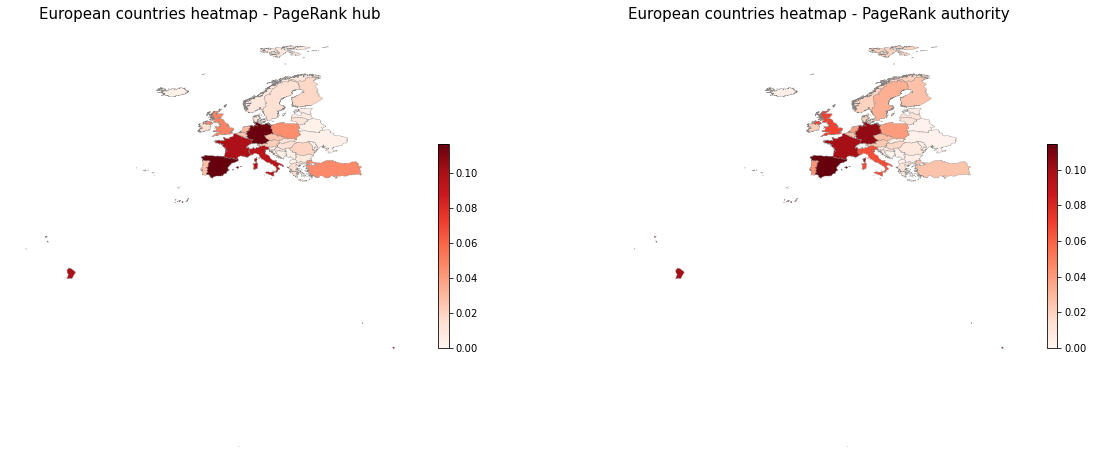

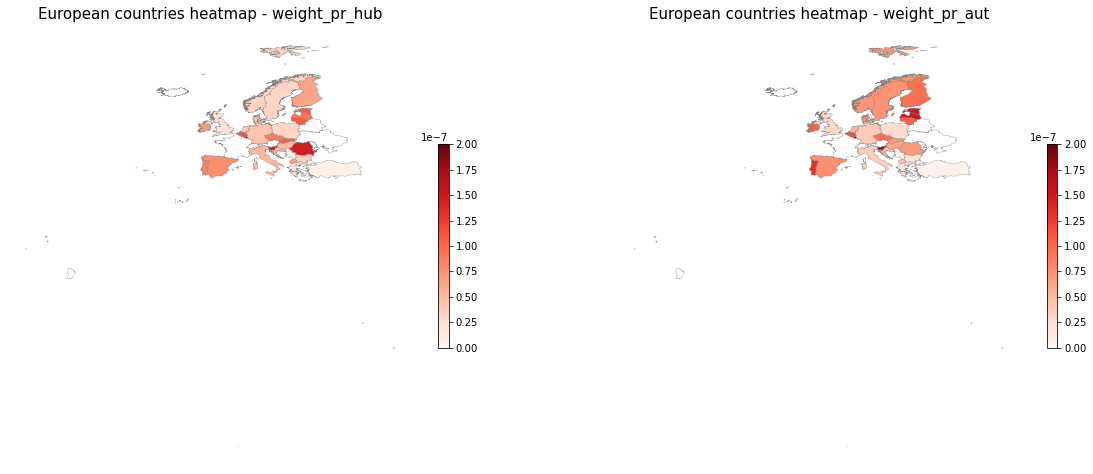

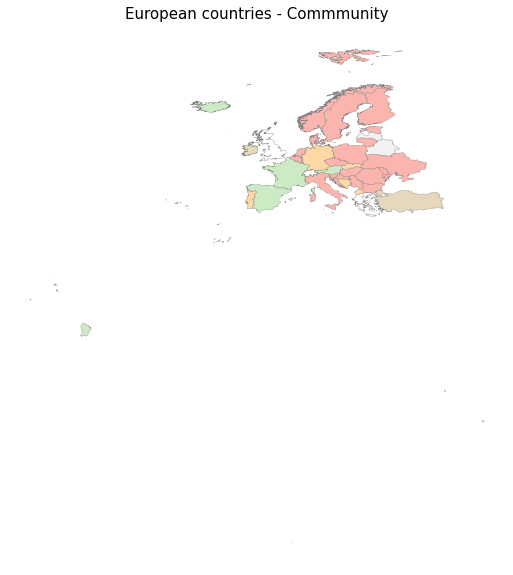

In [8]:
country15_df = pd.read_csv('data\Erasmus15.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country15_df)

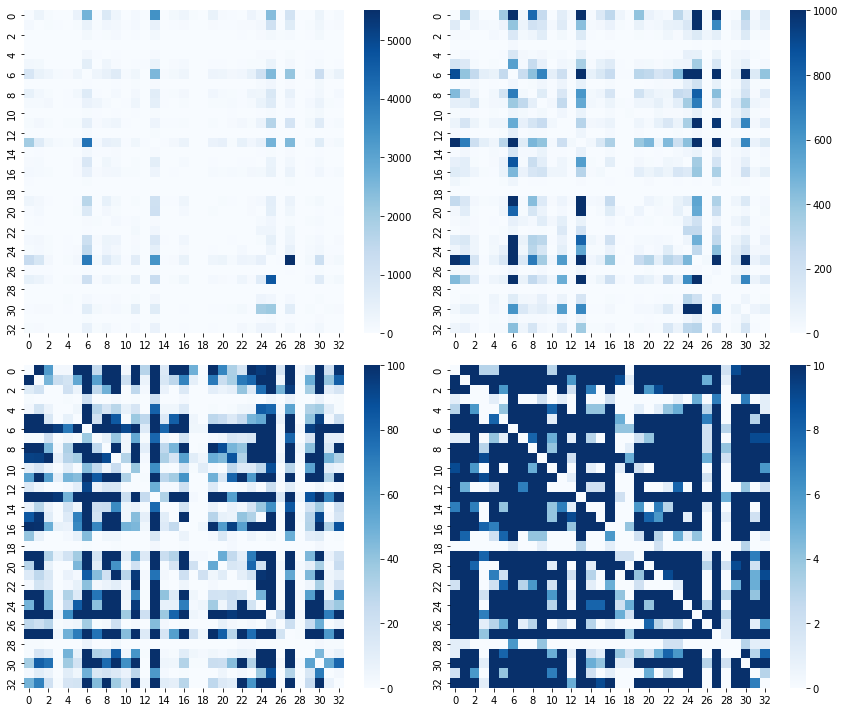

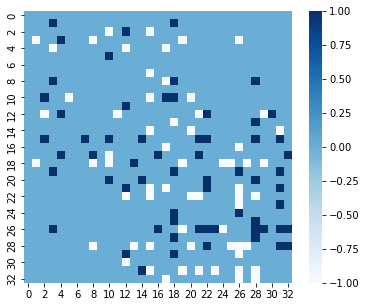

Number of components = 1


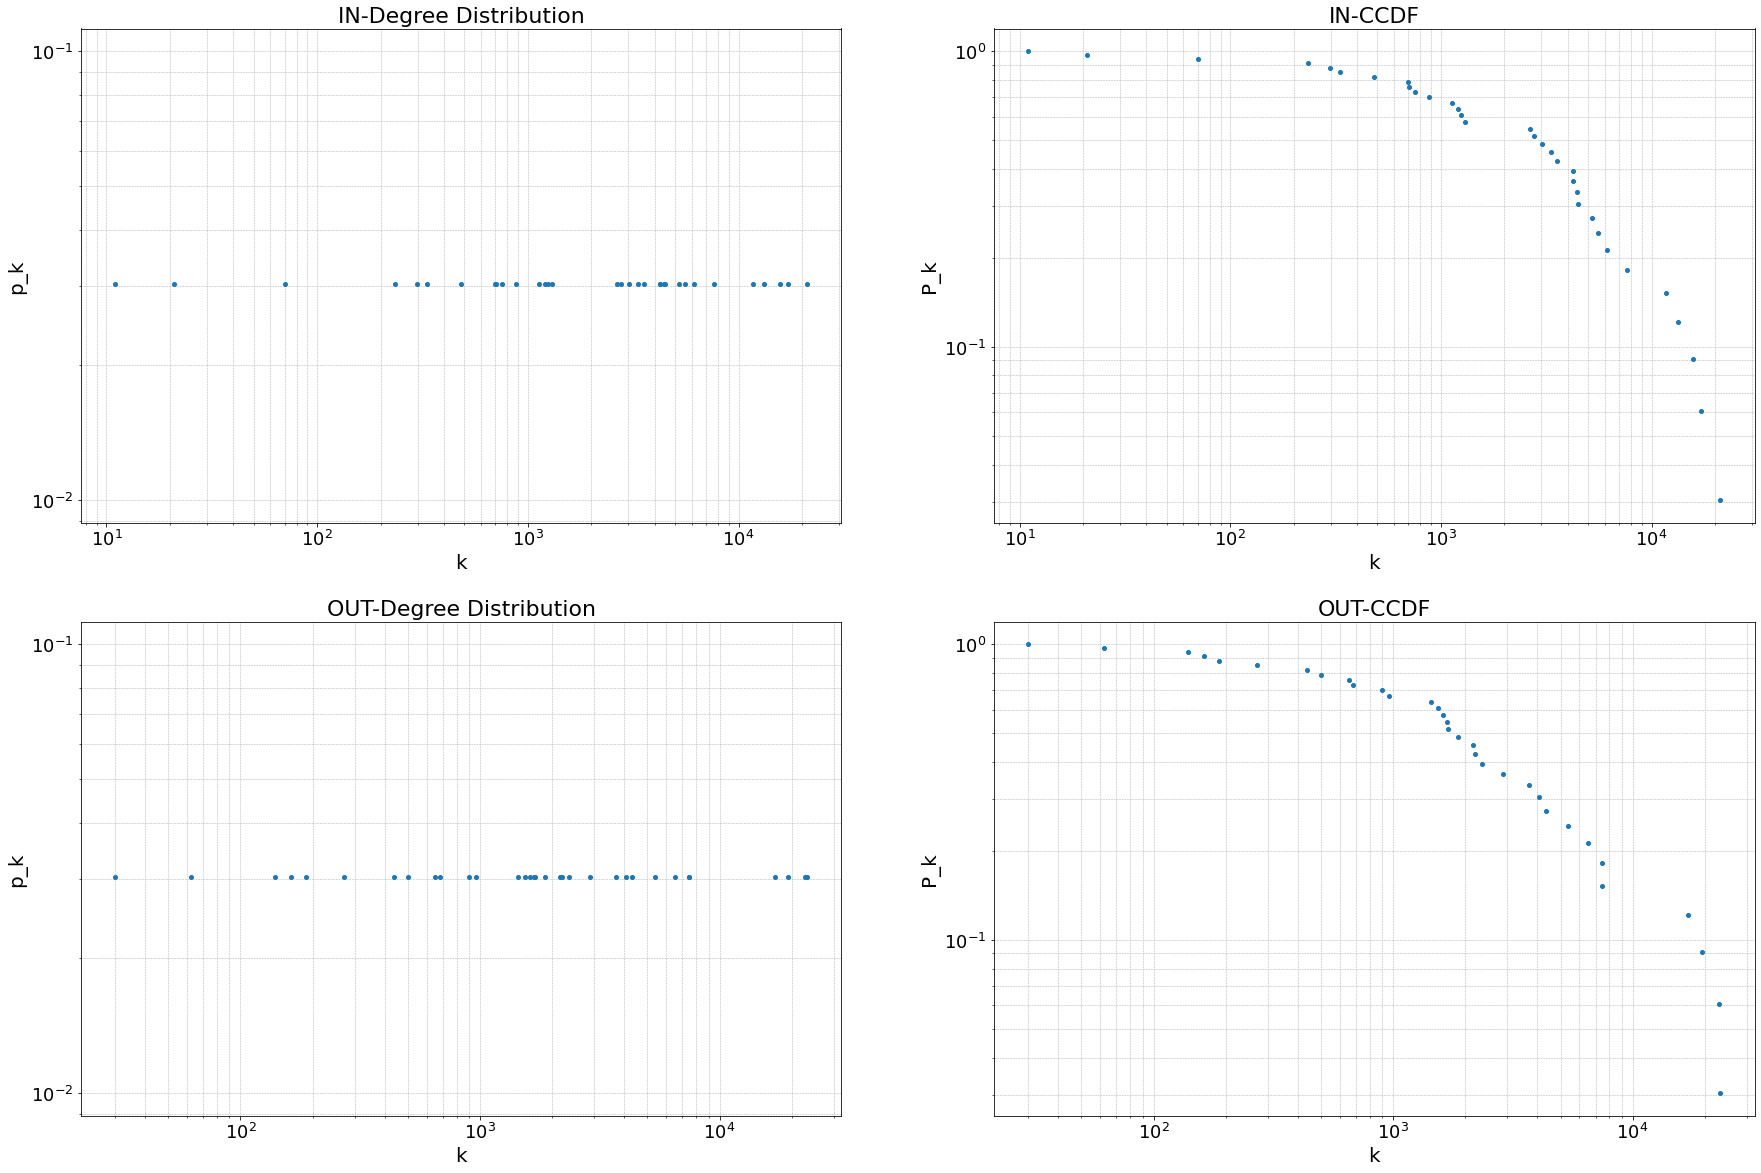

Top 10 for in degree


Nodes  in degree
25        Spain      21119
13       France      17250
6       Germany      15714
0            UK      13281
27        Italy      11699
30       Poland       7628
11     Portugal       6146
19       Sweden       5562
8   Netherlands       5232
23      Finland       4494

Top 10 for out degree


Nodes  out degree
25        Spain       23155
6       Germany       22824
13       France       19399
27        Italy       17047
30       Poland        7462
24       Turkey        7441
0            UK        6492
8   Netherlands        5390
1       Belgium        4330
9       Czechia        4066

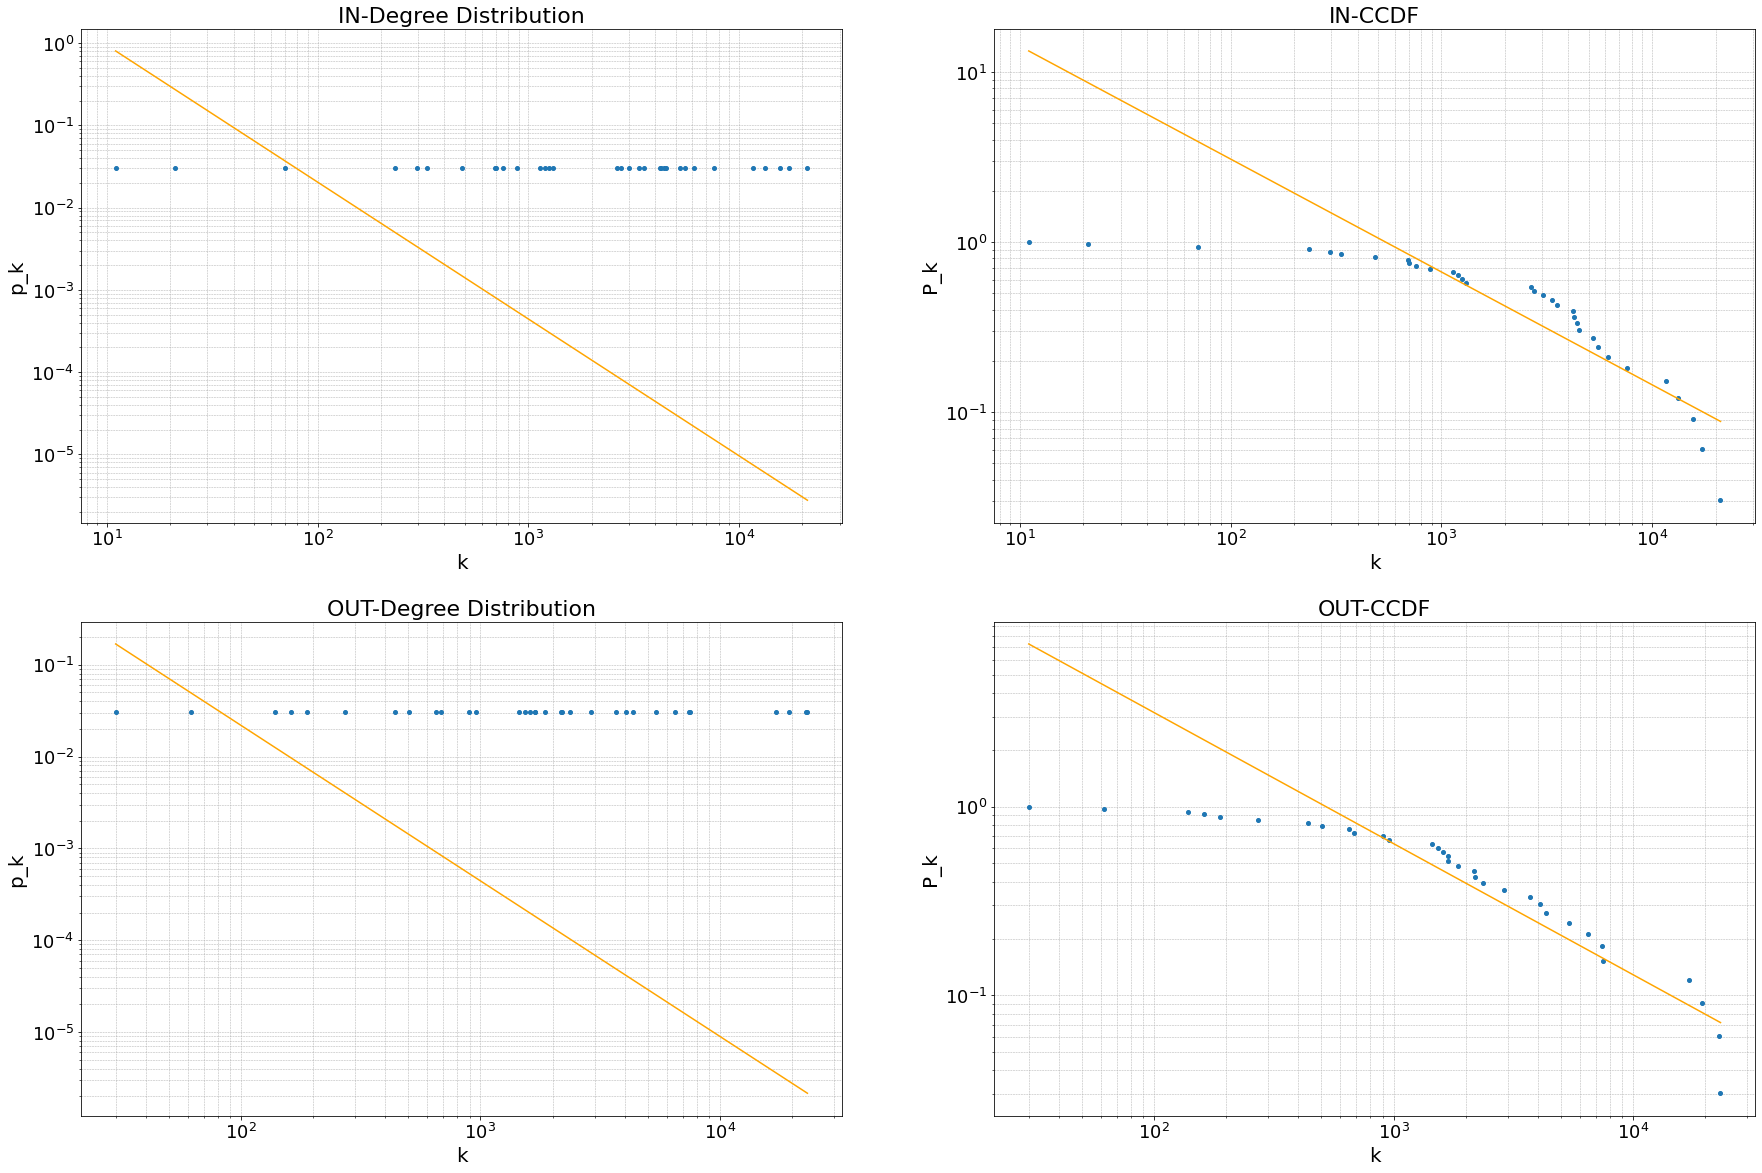

gamma_in = 1.6635377072473123
gamma_out = 1.6945538393614865


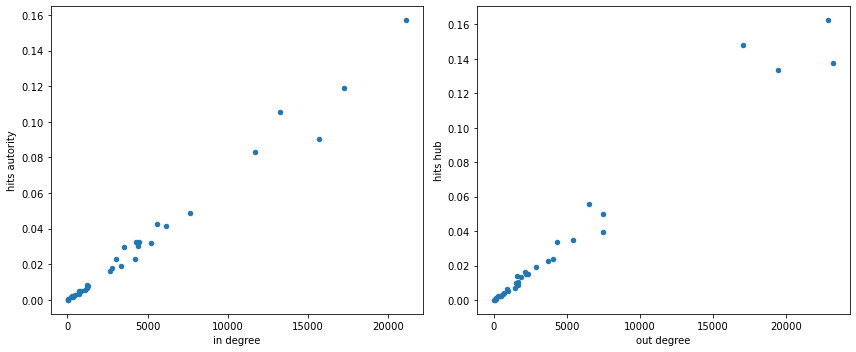

Top 10 for hits hub


Nodes  hits hub
6       Germany  0.162275
27        Italy  0.147887
25        Spain  0.137271
13       France  0.133438
0            UK  0.055983
30       Poland  0.050064
24       Turkey  0.039574
8   Netherlands  0.035035
1       Belgium  0.033543
9       Czechia  0.023626

Top 10 for hits autority


Nodes  hits autority
25     Spain       0.156956
13    France       0.118921
0         UK       0.105617
6    Germany       0.090148
27     Italy       0.082788
30    Poland       0.048618
19    Sweden       0.042787
11  Portugal       0.041566
23   Finland       0.032696
24    Turkey       0.032405

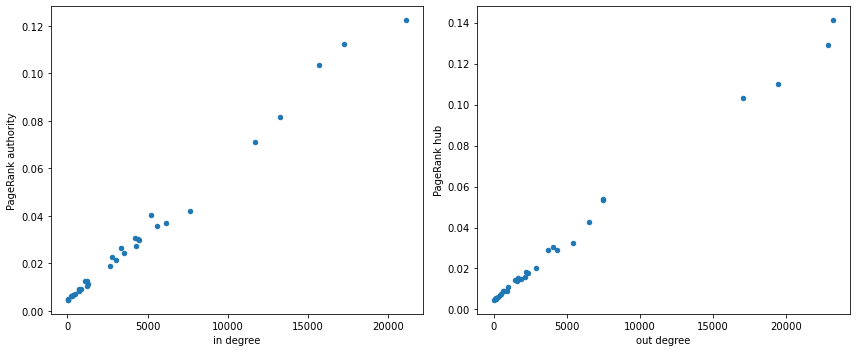

Top 10 for PageRank hub


Nodes  PageRank hub
25        Spain      0.141112
6       Germany      0.129106
13       France      0.110293
27        Italy      0.103348
30       Poland      0.054073
24       Turkey      0.053611
0            UK      0.042490
8   Netherlands      0.032353
9       Czechia      0.030299
11     Portugal      0.029030

Top 10 for PageRank authority


Nodes  PageRank authority
25        Spain            0.122351
13       France            0.112269
6       Germany            0.103498
0            UK            0.081532
27        Italy            0.070998
30       Poland            0.041874
8   Netherlands            0.040290
11     Portugal            0.036863
19       Sweden            0.035680
9       Czechia            0.030777

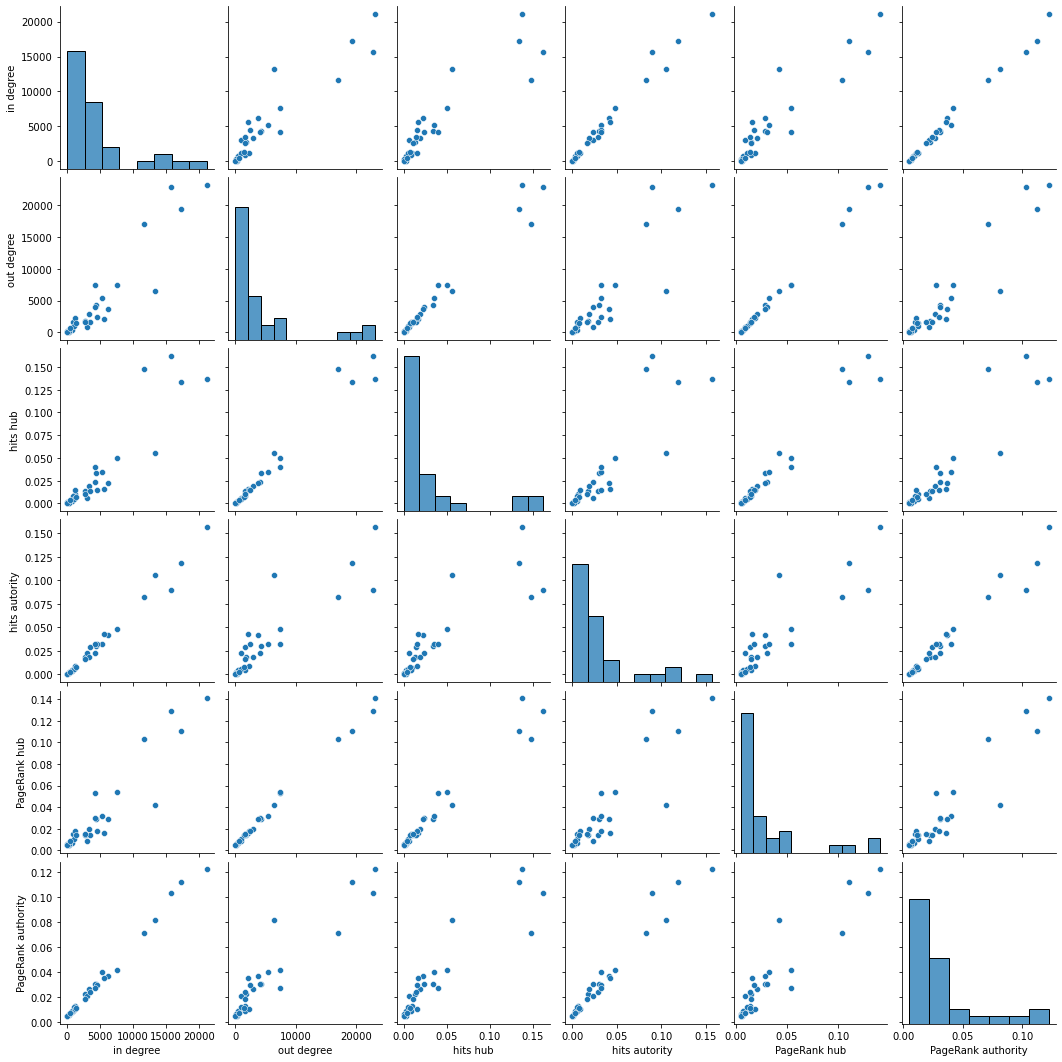

Nodes  in degree  in degree position  hits autority  \
25            Spain      21119                   1       0.156956   
13           France      17250                   2       0.118921   
6           Germany      15714                   3       0.090148   
0                UK      13281                   4       0.105617   
27            Italy      11699                   5       0.082788   
30           Poland       7628                   6       0.048618   
8       Netherlands       5232                   9       0.032177   
11         Portugal       6146                   7       0.041566   
19           Sweden       5562                   8       0.042787   
9           Czechia       4234                  13       0.023135   
1           Belgium       4413                  11       0.030519   
23          Finland       4494                  10       0.032696   
24           Turkey       4251                  12       0.032405   
16          Austria       3342                  15       0.019049   
20          Ireland       3545                  14       0.029458   
5           Denmark       2764                  17       0.018001   
15           Norway       3021                  16       0.023204   
32          Hungary       2648                  18       0.016353   
2                EL       1201                  21       0.006676   
21         Slovenia       1130                  22       0.005621   
29        Lithuania       1306                  19       0.007822   
22          Romania       1247                  20       0.008469   
7          Slovakia        882                  23       0.005118   
10          Croatia        697                  26       0.003269   
14          Estonia        756                  24       0.004975   
4            Latvia        704                  25       0.004647   
31         Bulgaria        483                  27       0.002911   
26           Cyprus        332                  28       0.001673   
12          Iceland        297                  29       0.002126   
17            Malta        234                  30       0.001527   
3        Luxembourg         70                  31       0.000613   
28    Liechtenstein         21                  32       0.000100   
18  North Macedonia         11                  33       0.000055   

    hits autority position  PageRank authority  PageRank authority position  
25                       1            0.122351                            1  
13                       2            0.112269                            2  
6                        4            0.103498                            3  
0                        3            0.081532                            4  
27                       5            0.070998                            5  
30                       6            0.041874                            6  
8                       11            0.040290                            7  
11                       8            0.036863                            8  
19                       7            0.035680                            9  
9                       15            0.030777                           10  
1                       12            0.030385                           11  
23                       9            0.029802                           12  
24                      10            0.027118                           13  
16                      16            0.026471                           14  
20                      13            0.024297                           15  
5                       17            0.022712                           16  
15                      14            0.021254                           17  
32                      18            0.018899                           18  
2                       21            0.012545                           19  
21                      22            0.012368                           20  
29                      20   

Nodes  out degree  out degree position  hits hub  \
25            Spain       23155                    1  0.137271   
6           Germany       22824                    2  0.162275   
13           France       19399                    3  0.133438   
27            Italy       17047                    4  0.147887   
30           Poland        7462                    5  0.050064   
24           Turkey        7441                    6  0.039574   
0                UK        6492                    7  0.055983   
8       Netherlands        5390                    8  0.035035   
9           Czechia        4066                   10  0.023626   
11         Portugal        3694                   11  0.022424   
1           Belgium        4330                    9  0.033543   
16          Austria        2887                   12  0.019040   
22          Romania        2196                   14  0.015245   
23          Finland        2360                   13  0.015171   
19           Sweden        2159                   15  0.016356   
7          Slovakia        1681                   18  0.008573   
32          Hungary        1692                   17  0.010578   
5           Denmark        1860                   16  0.013242   
29        Lithuania        1445                   21  0.006855   
2                EL        1539                   20  0.009965   
20          Ireland        1611                   19  0.013796   
21         Slovenia         958                   22  0.005292   
15           Norway         899                   23  0.006516   
31         Bulgaria         682                   24  0.004288   
4            Latvia         652                   25  0.003334   
10          Croatia         502                   26  0.002617   
14          Estonia         439                   27  0.002435   
3        Luxembourg         271                   28  0.002151   
26           Cyprus         162                   30  0.000952   
12          Iceland         188                   29  0.001245   
17            Malta         139                   31  0.000883   
18  North Macedonia          62                   32  0.000155   
28    Liechtenstein          30                   33  0.000191   

    hits hub position  PageRank hub  PageRank hub position  
25                  3      0.141112                      1  
6                   1      0.129106                      2  
13                  4      0.110293                      3  
27                  2      0.103348                      4  
30                  6      0.054073                      5  
24                  7      0.053611                      6  
0                   5      0.042490                      7  
8                   8      0.032353                      8  
9                  10      0.030299                      9  
11                 11      0.029030                     10  
1                   9      0.028949                     11  
16                 12      0.020286                     12  
22                 14      0.018381                     13  
23                 15      0.018006                     14  
19                 13      0.016049                     15  
7                  20      0.015143                     16  
32                 18      0.015005                     17  
5                  17      0.014631                     18  
29                 21      0.014240                     19  
2                  19      0.014236                     20  
20                 16      0.013981                     21  
21                 23      0.011038                     22  
15                 22      0.009230                     23  
31                 24      0.009153                     24  
4                  25      0.008935                     25  
10                 26      0.007738                     26  
14                 27      0.007054                     27  
3                  28      0.006142                     28  


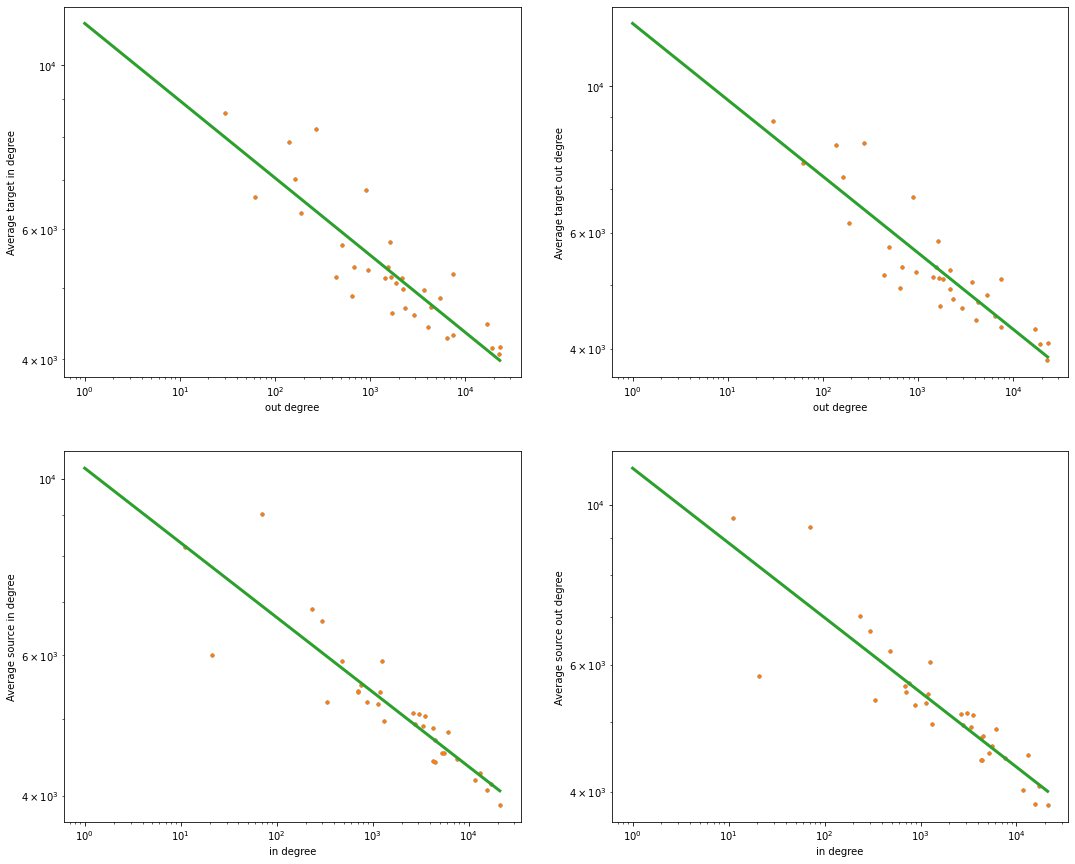

(-0.10455240865841625, -0.11594182711442622, -0.09360541404419462, -0.1037260967588432)


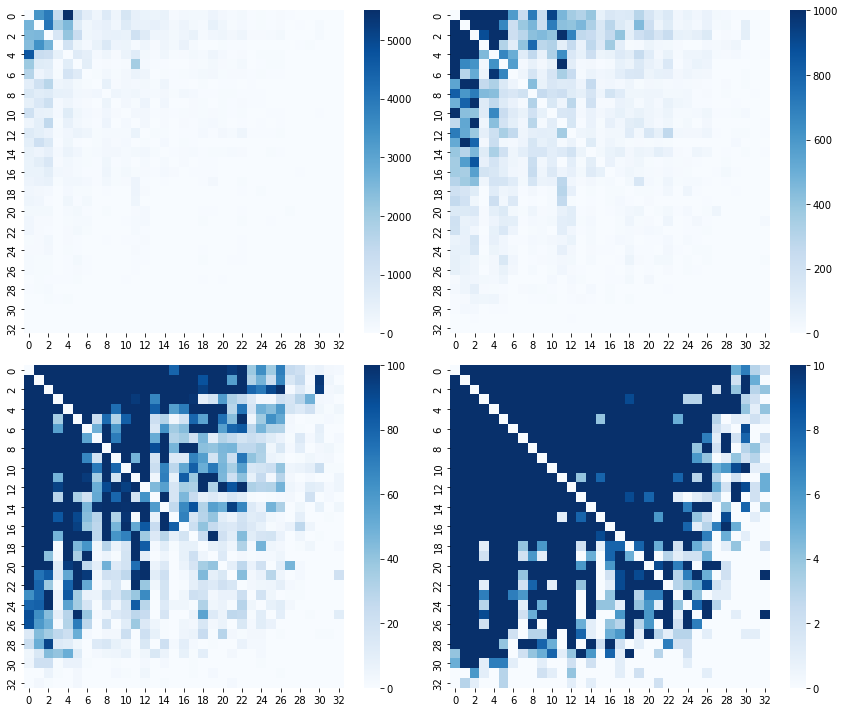

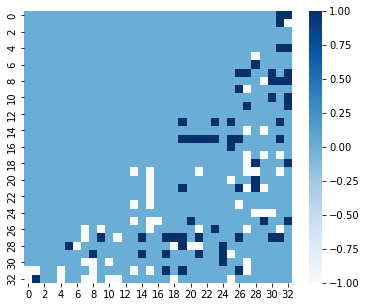

Nodes  Community
0              UK          0
2              EL          0
3      Luxembourg          0
4          Latvia          0
7        Slovakia          0
8     Netherlands          0
9         Czechia          0
11       Portugal          0
12        Iceland          0
13         France          0
14        Estonia          0
15         Norway          0
22        Romania          0
23        Finland          0
25          Spain          0
26         Cyprus          0
28  Liechtenstein          0
30         Poland          0
31       Bulgaria          0
32        Hungary          0

Nodes  Community
1           Belgium          1
5           Denmark          1
6           Germany          1
10          Croatia          1
16          Austria          1
17            Malta          1
18  North Macedonia          1
19           Sweden          1
20          Ireland          1
21         Slovenia          1
24           Turkey          1
27            Italy          1
29        Lithuania          1

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
24          Turkey                          7107650.0
6          Germany                          2625241.0
0   United Kingdom                          2263020.0
26           Italy                          1797986.0
25           Spain                          1491419.0
29          Poland                          1418588.0
8      Netherlands                           720583.0
2           Greece                           704969.0
19          Sweden                           438578.0
11        Portugal                           323467.0

country  weight_pr_hub
0       Luxembourg   2.000000e-07
1         Slovenia   2.000000e-07
2    Liechtenstein   2.000000e-07
3            Malta   2.000000e-07
4          Estonia   1.561997e-07
5          Romania   1.363381e-07
6         Slovakia   1.352762e-07
7          Belgium   1.255014e-07
8        Lithuania   1.244512e-07
9           Latvia   1.142395e-07
10       Macedonia   1.030193e-07
11         Czechia   1.021499e-07
12           Spain   9.461599e-08
13        Portugal   8.974626e-08
14         Ireland   6.955643e-08
15         Finland   6.508419e-08
16           Italy   5.748009e-08
17         Denmark   5.683028e-08
18         Hungary   5.394088e-08
19         Germany   4.917889e-08
20         Croatia   4.826007e-08
21     Netherlands   4.489903e-08
22        Bulgaria   3.943778e-08
23          Poland   3.811757e-08
24          Sweden   3.659371e-08
25          Norway   3.424649e-08
26          Greece   2.019327e-08
27  United Kingdom   1.877573e-08
28          Turkey   7.542693e-09
29     Switzerland   0.000000e+00

country  weight_pr_aut
0       Luxembourg   2.000000e-07
1    Liechtenstein   2.000000e-07
2            Malta   2.000000e-07
3         Slovenia   2.000000e-07
4          Estonia   1.926244e-07
5          Belgium   1.317276e-07
6          Ireland   1.208751e-07
7         Portugal   1.139634e-07
8          Finland   1.077198e-07
9           Latvia   1.052956e-07
10         Czechia   1.037606e-07
11       Lithuania   9.924275e-08
12       Macedonia   9.451786e-08
13         Denmark   8.822145e-08
14        Slovakia   8.342777e-08
15           Spain   8.203669e-08
16          Sweden   8.135302e-08
17          Norway   7.885817e-08
18         Romania   7.843321e-08
19         Hungary   6.793889e-08
20         Croatia   5.765418e-08
21     Netherlands   5.591304e-08
22           Italy   3.948754e-08
23         Germany   3.942410e-08
24  United Kingdom   3.602784e-08
25        Bulgaria   3.083430e-08
26          Poland   2.951780e-08
27          Greece   1.779566e-08
28          Turkey   3.815350e-09
29     Switzerland   0.000000e+00

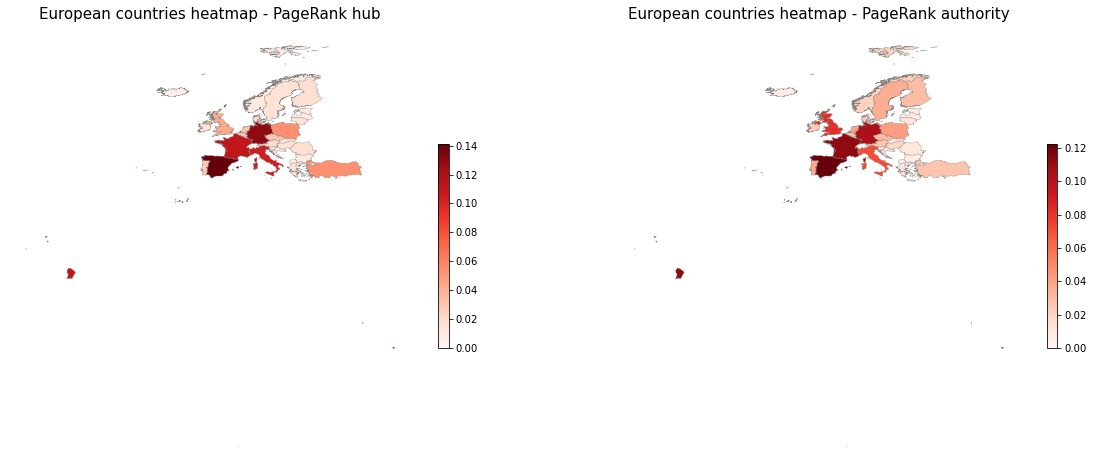

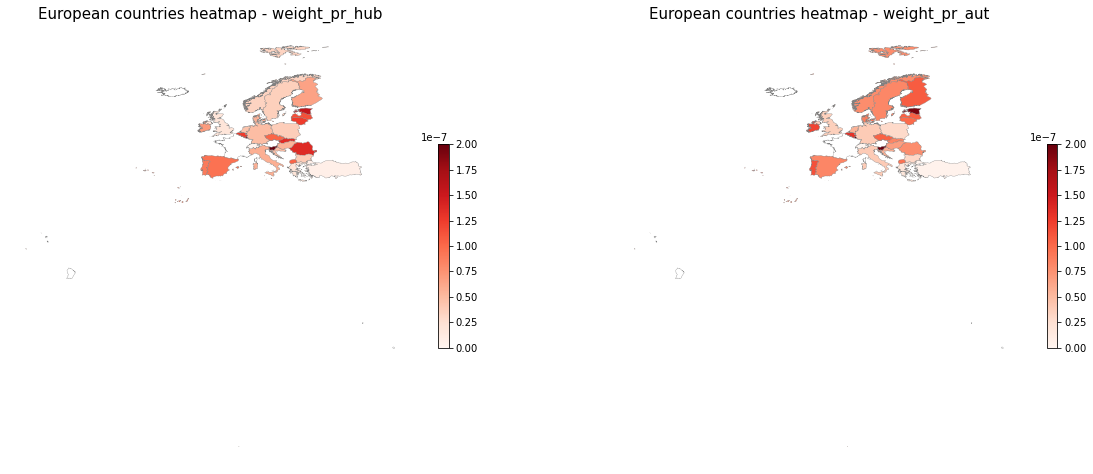

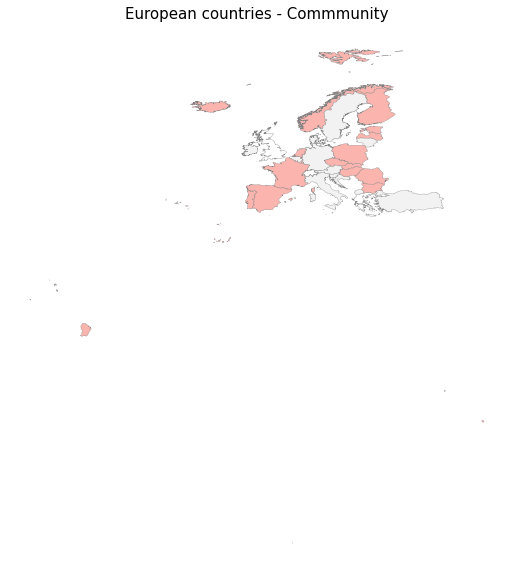

In [9]:
country14_df = pd.read_csv('data\Erasmus14.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country14_df)

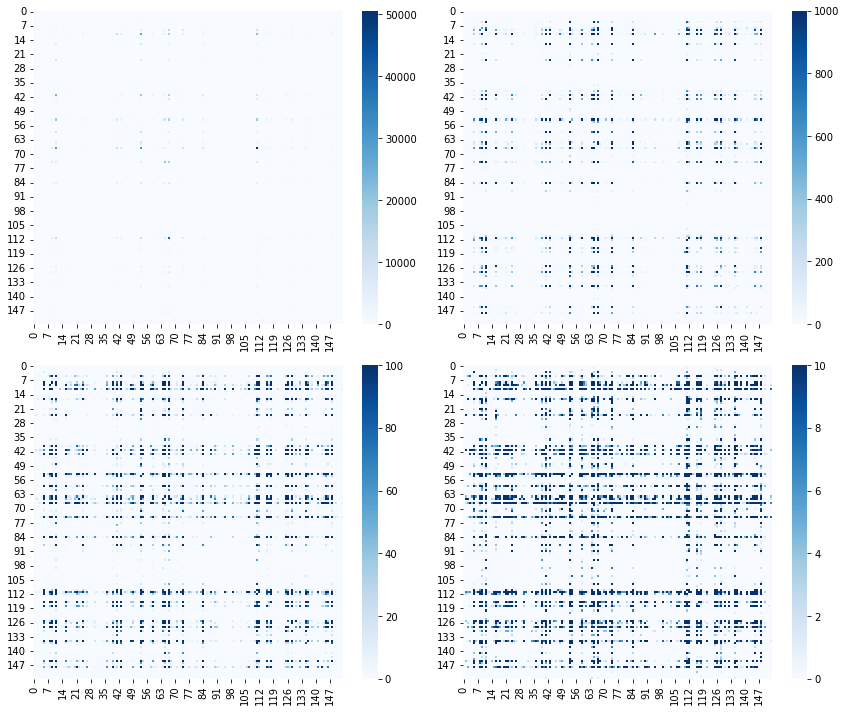

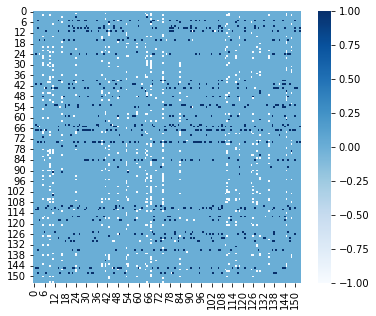

Number of components = 2


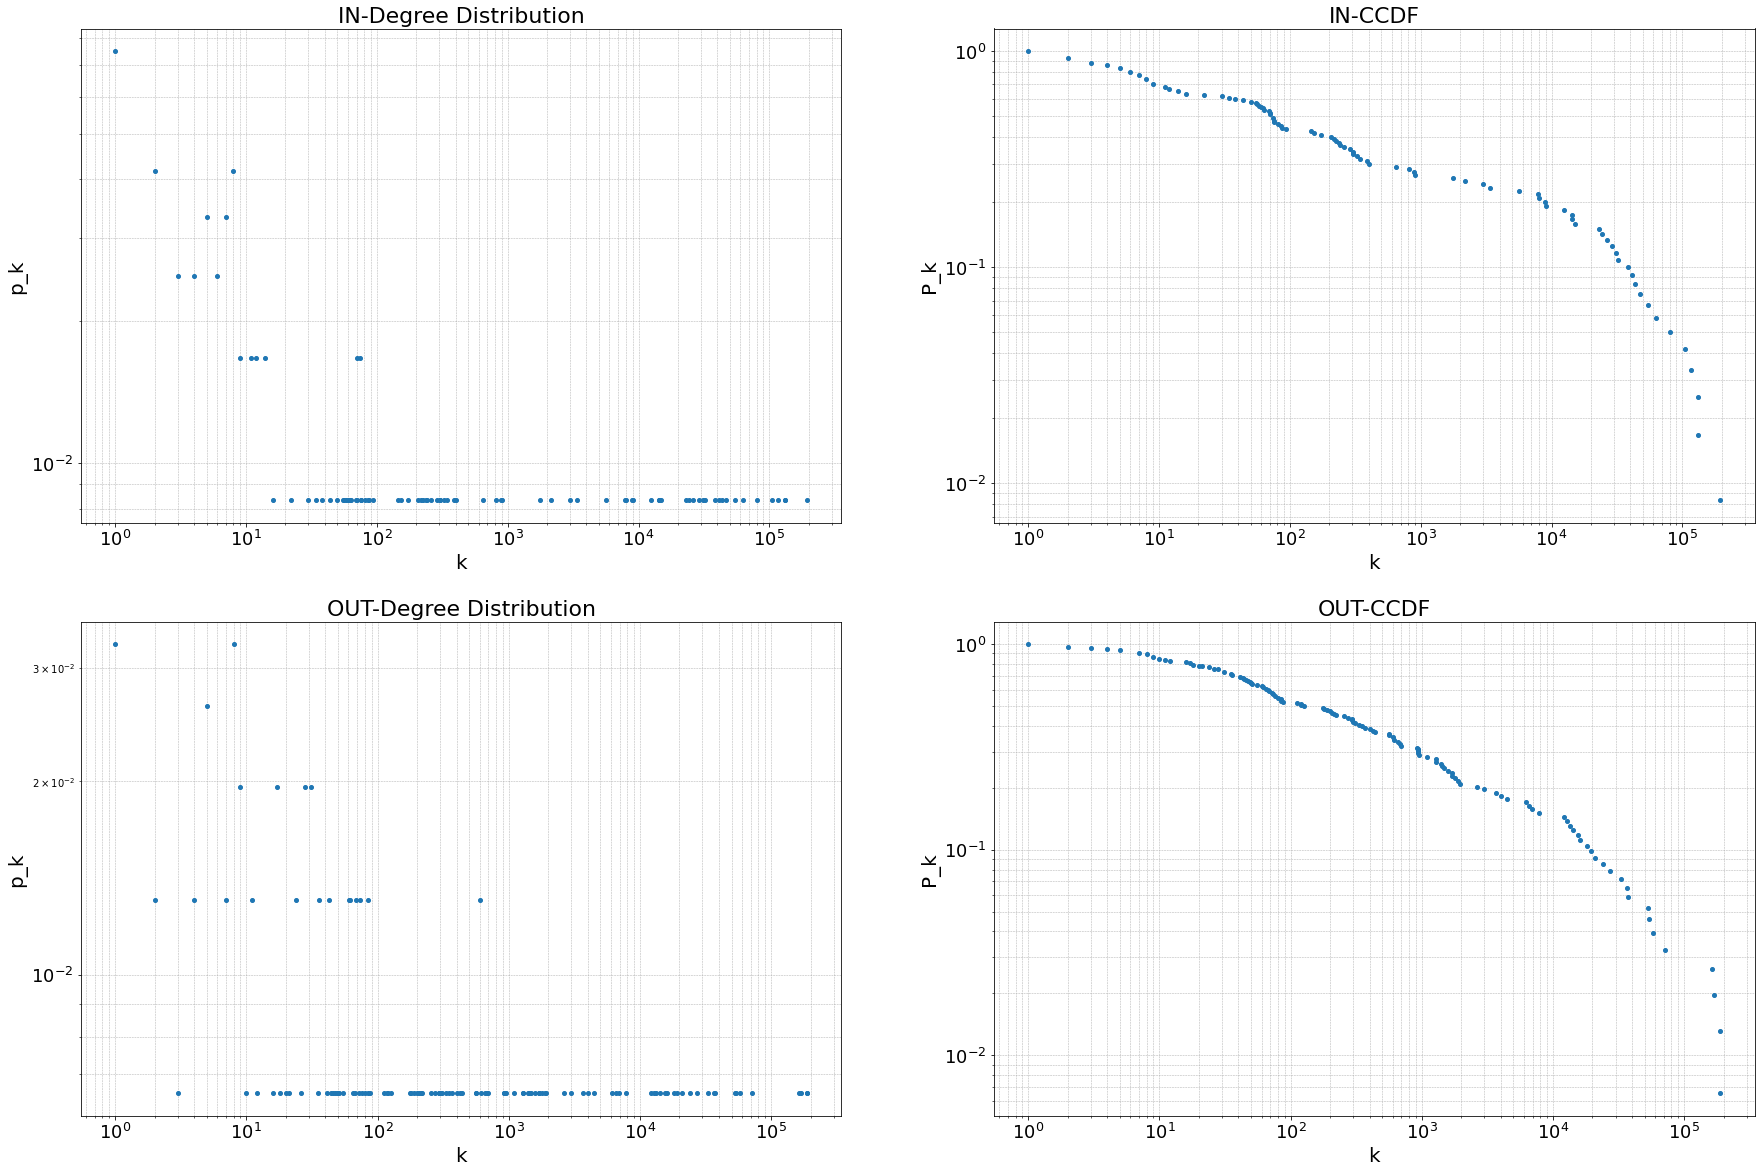

Top 10 for in degree


Nodes  in degree
67         Spain     193628
53       Germany     131451
11        France     130821
111        Italy     116180
41            UK     103962
74        Poland      79774
9       Portugal      63268
84   Netherlands      54828
59        Sweden      47028
128      Czechia      43532

Top 10 for out degree


Nodes  out degree
53       Germany      187627
67         Spain      186670
11        France      168162
111        Italy      162235
65        Turkey       71621
74        Poland       58299
41            UK       53862
84   Netherlands       53340
43       Belgium       37427
9       Portugal       36678

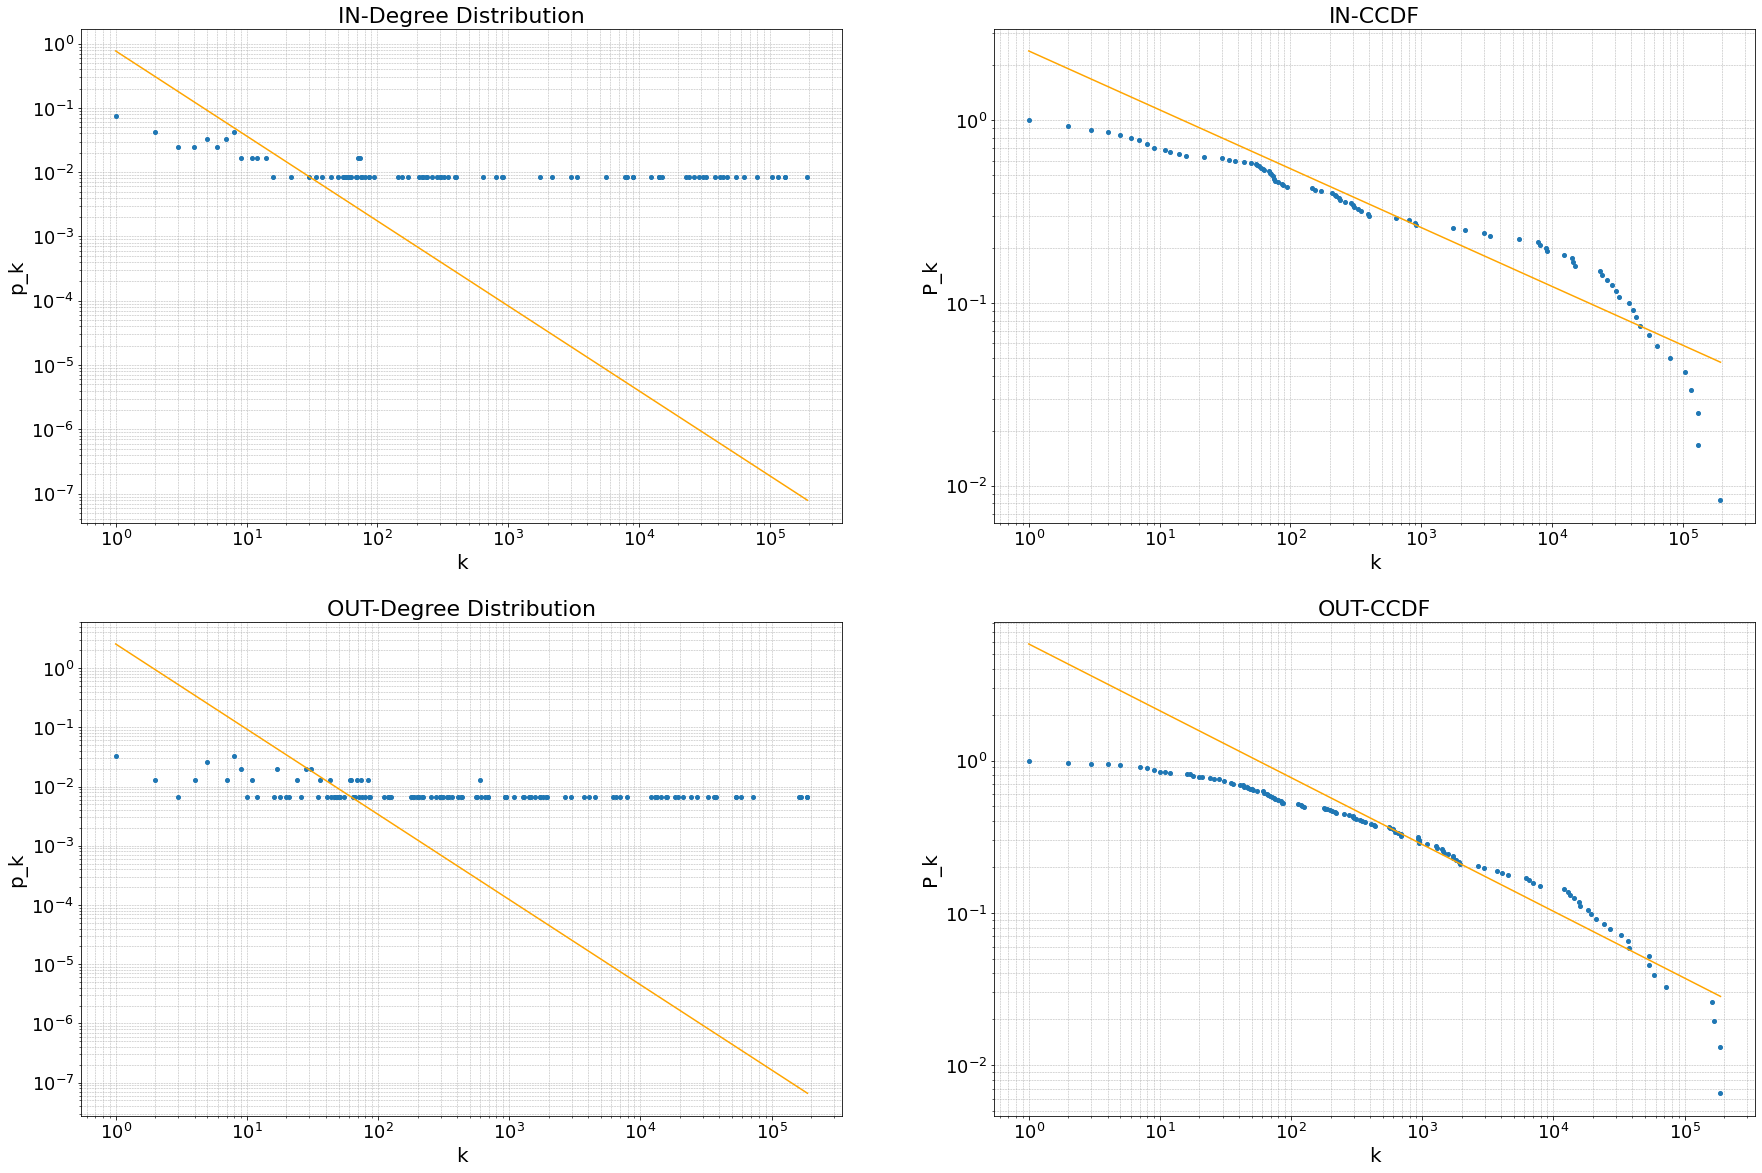

gamma_in = 1.3220208998433385
gamma_out = 1.4388365035651984


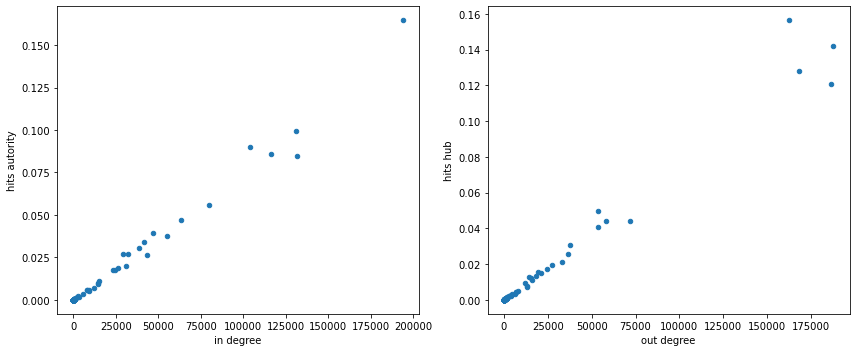

Top 10 for hits hub


Nodes  hits hub
111        Italy  0.156293
53       Germany  0.141831
11        France  0.128110
67         Spain  0.120733
41            UK  0.049901
74        Poland  0.044319
65        Turkey  0.043977
84   Netherlands  0.040685
43       Belgium  0.030840
9       Portugal  0.025639

Top 10 for hits autority


Nodes  hits autority
67         Spain       0.164556
11        France       0.099586
41            UK       0.089991
111        Italy       0.085836
53       Germany       0.084588
74        Poland       0.056051
9       Portugal       0.046731
59        Sweden       0.039643
84   Netherlands       0.037504
64       Finland       0.033788

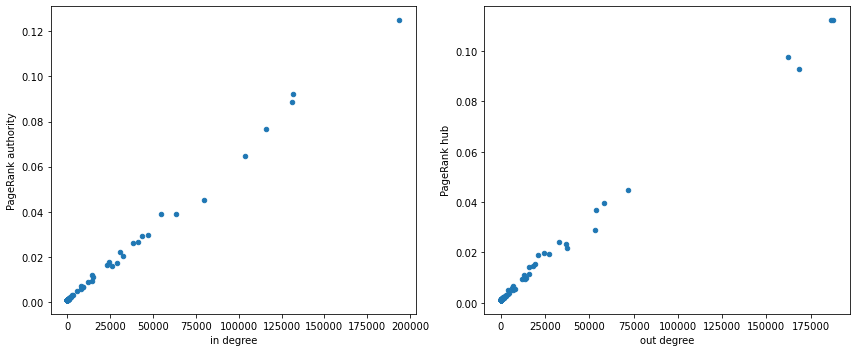

Top 10 for PageRank hub


Nodes  PageRank hub
53       Germany      0.112138
67         Spain      0.112125
111        Italy      0.097475
11        France      0.092776
65        Turkey      0.044988
74        Poland      0.039472
41            UK      0.036884
84   Netherlands      0.028761
128      Czechia      0.024009
9       Portugal      0.023171

Top 10 for PageRank authority


Nodes  PageRank authority
67         Spain            0.124839
53       Germany            0.092253
11        France            0.088529
111        Italy            0.076540
41            UK            0.064553
74        Poland            0.045153
9       Portugal            0.039174
84   Netherlands            0.038861
59        Sweden            0.029709
128      Czechia            0.029178

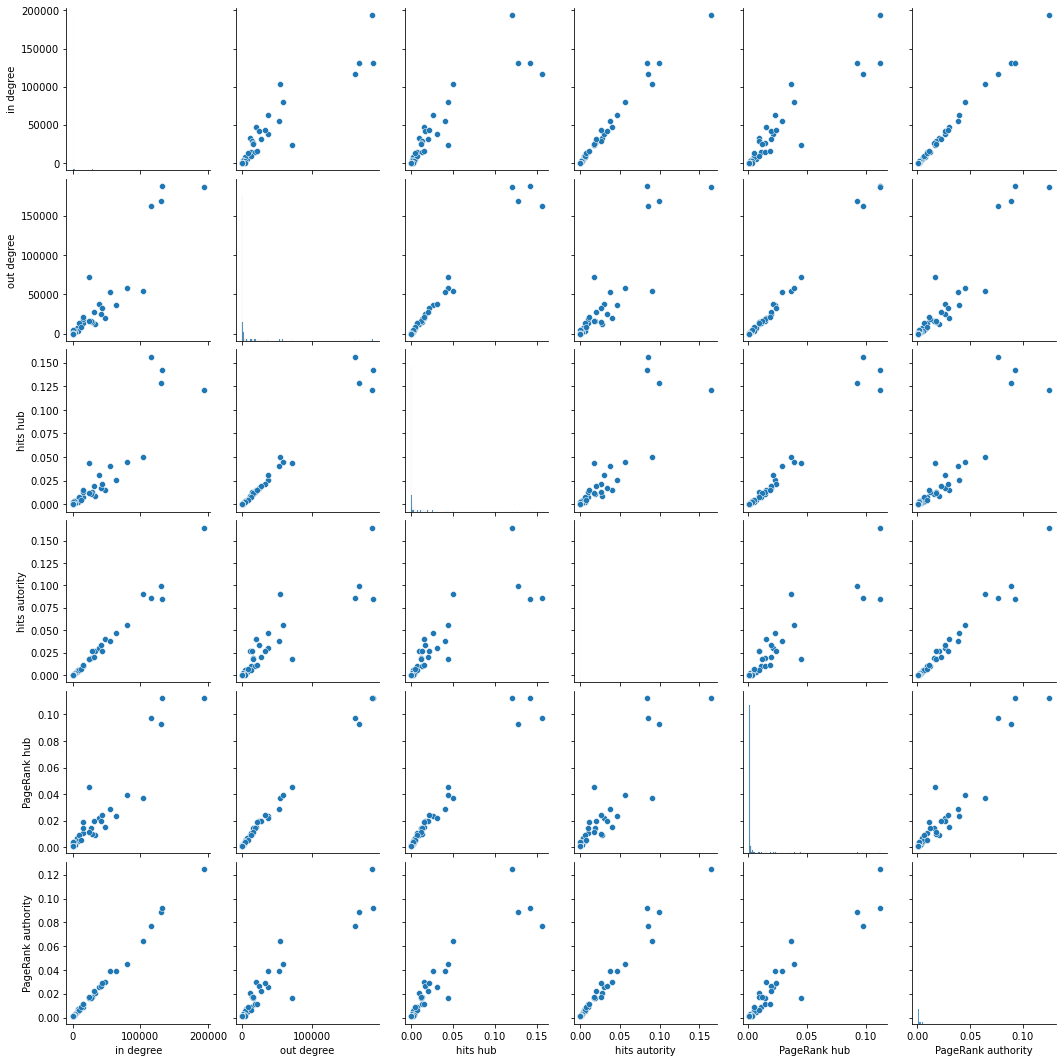

Nodes  in degree  in degree position  hits autority  \
67                    Spain     193628                   1       0.164556   
53                  Germany     131451                   2       0.084588   
11                   France     130821                   3       0.099586   
111                   Italy     116180                   4       0.085836   
41                       UK     103962                   5       0.089991   
74                   Poland      79774                   6       0.056051   
9                  Portugal      63268                   7       0.046731   
84              Netherlands      54828                   8       0.037504   
59                   Sweden      47028                   9       0.039643   
128                 Czechia      43532                  10       0.026612   
64                  Finland      41491                  11       0.033788   
43                  Belgium      38404                  12       0.030425   
135                 Austria      30949                  14       0.020008   
16                   Norway      32344                  13       0.027140   
125                 Denmark      24228                  17       0.017316   
24                  Ireland      28897                  15       0.026713   
65                   Turkey      23039                  18       0.017419   
116                 Hungary      26280                  16       0.018527   
118                      EL      14333                  20       0.009585   
148                 Romania      14966                  19       0.011204   
112               Lithuania      14273                  21       0.009962   
145                Slovenia      12383                  22       0.007141   
5                    Latvia       8064                  25       0.006076   
8                   Croatia       9059                  23       0.005239   
126                Slovakia       8950                  24       0.005978   
54                  Estonia       7844                  26       0.005851   
39                 Bulgaria       5609                  27       0.003485   
110                  Cyprus       3364                  28       0.001827   
130                 Iceland       2995                  29       0.002287   
88                    Malta       2161                  30       0.001473   
136      Russian Federation       1758                  31       0.001265   
71                   Israel        892                  33       0.000605   
21                   Serbia        908                  32       0.000602   
48               Luxembourg        812                  34       0.000725   
17            United States        643                  35       0.000460   
61                   Canada        401                  36       0.000289   
132                   China        302                  41       0.000125   
141         North Macedonia        390                  37       0.000238   
36   Bosnia and Herzegovina        345                  38       0.000210   
77                    Japan        326                  39       0.000264   

     hits autority position  PageRank authority  PageRank authority position  
67                        1            0.124839                            1  
53                        5            0.092253                            2  
11                        2            0.088529                            3  
111                       4            0.076540                            4  
41                        3            0.064553                            5  
74                        6            0.045153                            6  
9                         7            0.039174                            7  
84                        9            0.038861                            8  
59                        8            0.029709                            9  
128                      14            0.029178                           

Nodes  out degree  out degree position  hits hub  \
53                  Germany      187627                    1  0.141831   
67                    Spain      186670                    2  0.120733   
111                   Italy      162235                    4  0.156293   
11                   France      168162                    3  0.128110   
65                   Turkey       71621                    5  0.043977   
74                   Poland       58299                    6  0.044319   
41                       UK       53862                    7  0.049901   
84              Netherlands       53340                    8  0.040685   
128                 Czechia       32912                   11  0.021089   
9                  Portugal       36678                   10  0.025639   
43                  Belgium       37427                    9  0.030840   
64                  Finland       24264                   13  0.017102   
135                 Austria       27204                   12  0.019678   
148                 Romania       21012                   14  0.014906   
59                   Sweden       19337                   15  0.015423   
118                      EL       18254                   16  0.013360   
116                 Hungary       16068                   17  0.011245   
125                 Denmark       15651                   18  0.012205   
112               Lithuania       12867                   21  0.007240   
24                  Ireland       14255                   19  0.012791   
126                Slovakia       13370                   20  0.007605   
16                   Norway       12075                   22  0.009214   
39                 Bulgaria        6558                   25  0.004334   
5                    Latvia        6178                   26  0.003345   
145                Slovenia        7847                   23  0.004957   
8                   Croatia        6937                   24  0.004517   
54                  Estonia        3696                   29  0.002296   
136      Russian Federation        4500                   27  0.003247   
146                 Ukraine        4025                   28  0.002819   
21                   Serbia        2962                   30  0.002150   
48               Luxembourg        2653                   31  0.002165   
49                  Georgia        1893                   33  0.001299   
107                 Morocco        1939                   32  0.001774   
110                  Cyprus        1714                   35  0.000830   
132                   China        1796                   34  0.001301   
95                  Tunisia        1708                   36  0.001601   
36   Bosnia and Herzegovina        1584                   37  0.001099   
141         North Macedonia        1290                   41  0.000470   
117                 Albania        1438                   39  0.000992   
71                   Israel        1277                   42  0.000881   

     hits hub position  PageRank hub  PageRank hub position  
53                   2      0.112138                      1  
67                   4      0.112125                      2  
111                  1      0.097475                      3  
11                   3      0.092776                      4  
65                   7      0.044988                      5  
74                   6      0.039472                      6  
41                   5      0.036884                      7  
84                   8      0.028761                      8  
128                 11      0.024009                      9  
9                   10      0.023171                     10  
43                   9      0.021710                     11  
64                  13      0.019637                     12  
135                 12      0.019579                     13  
148                 15      0.019101                     14  
59                  14      0.015339                     

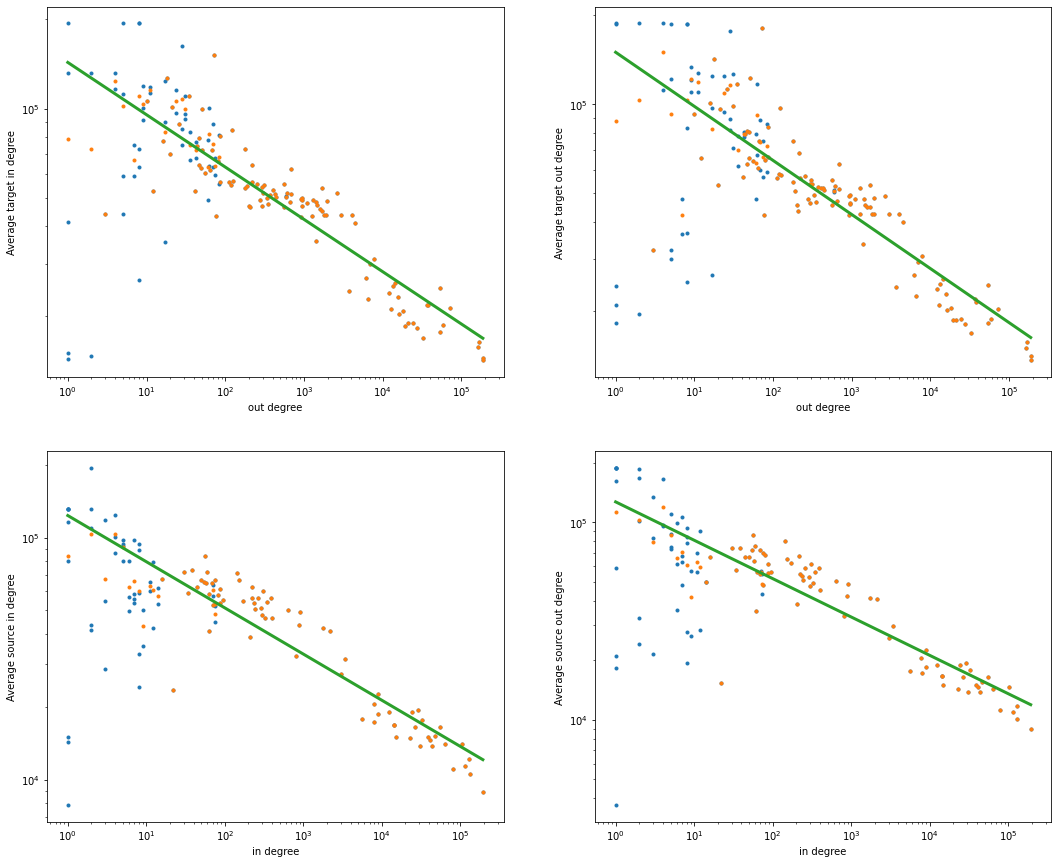

(-0.17644093588481982, -0.1826865894999842, -0.1908311792419887, -0.19417524253887586)


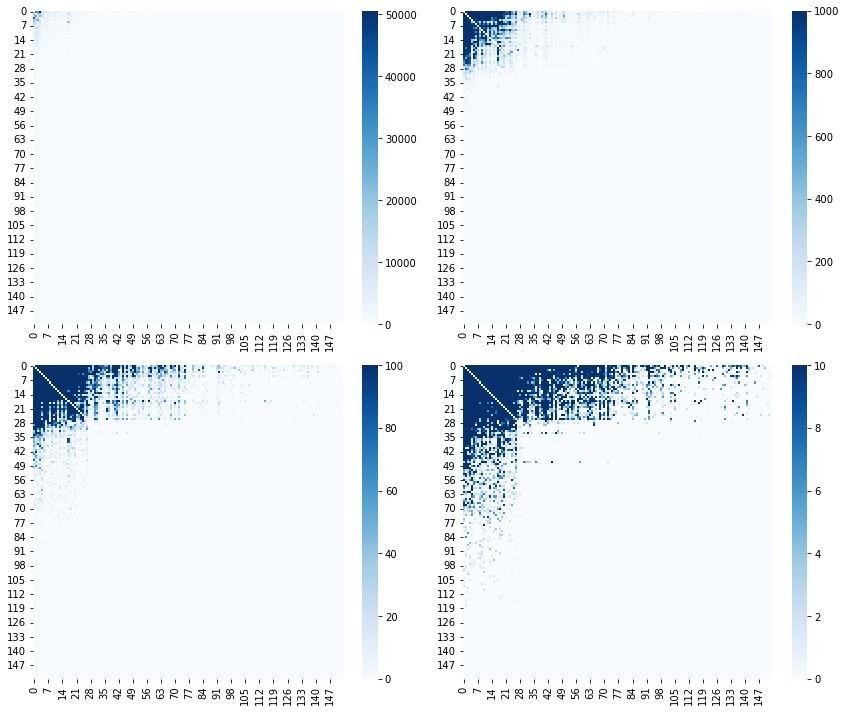

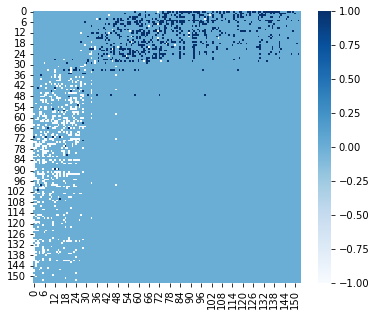

Nodes  Community
1      Bangladesh          0
6     New Zealand          0
7        Cameroon          0
9        Portugal          0
12         Rwanda          0
..            ...        ...
125       Denmark          0
129    Mozambique          0
140  Burkina Faso          0
150        Bhutan          0
151      Suriname          0

[44 rows x 2 columns]

Nodes  Community
2                            Sri Lanka          1
10                              Gambia          1
11                              France          1
14                  Dominican Republic          1
17                       United States          1
19                            Botswana          1
23                           Argentina          1
28                               Sudan          1
32                                Fiji          1
33   Venezuela, Bolivarian Republic of          1
39                            Bulgaria          1
42                               Haiti          1
52            Central African Republic          1
60                              Brazil          1
63                           Mauritius          1
65                              Turkey          1
68                          Azerbaijan          1
72                 Trinidad and Tobago          1
75                          Tajikistan          1
77                               Japan          1
90                          Kazakhstan          1
92                             Ecuador          1
95                             Tunisia          1
106                         Uzbekistan          1
108                           Mongolia          1
112                          Lithuania          1
114                              Niger          1
117                            Albania          1
118                                 EL          1
121                         Kyrgyzstan          1
126                           Slovakia          1
138                                 XK          1
139                          Nicaragua          1
141                    North Macedonia          1
143               Moldova, Republic of          1
144                            Belarus          1
145                           Slovenia          1
148                            Romania          1
152                  Brunei Darussalam          1

Nodes  Community
3                           Hong Kong          2
4                              Zambia          2
16                             Norway          2
21                             Serbia          2
24                            Ireland          2
26                              Egypt          2
41                                 UK          2
45                          Australia          2
47                           Pakistan          2
48                         Luxembourg          2
49                            Georgia          2
57                           Zimbabwe          2
59                             Sweden          2
62       Tanzania, United Republic of          2
64                            Finland          2
70                      Liechtenstein          2
71                             Israel          2
73                Palestine, State of          2
76    Bolivia, Plurinational State of          2
80   Lao People's Democratic Republic          2
88                              Malta          2
89                             Malawi          2
96                            Myanmar          2
99                           Viet Nam          2
103                          Thailand          2
104                          Barbados          2
110                            Cyprus          2
113                          Ethiopia          2
124                           Jamaica          2
132                             China          2
135                           Austria          2
136                Russian Federation          2
137                             Ghana          2
146                           Ukraine          2
153                           Uruguay          2

Nodes  Community
8                   Croatia          3
18               Montenegro          3
20                  Algeria          3
22                   Jordan          3
35               Costa Rica          3
36   Bosnia and Herzegovina          3
56                     Togo          3
61                   Canada          3
67                    Spain          3
81                    India          3
94              Afghanistan          3
102             El Salvador          3
109        Papua New Guinea          3
128                 Czechia          3
130                 Iceland          3
131       Equatorial Guinea          3
142                  Belize          3
147                 Nigeria          3
149              Mauritania          3

Nodes  Community
5        Latvia          4
25        Nepal          4
54      Estonia          4
55      Lesotho          4
58      Armenia          4
69        Kenya          4
78     Malaysia          4
82        Libya          4
93     Honduras          4
98       Panama          4
107     Morocco          4
116     Hungary          4
119      Angola          4
127      Mexico          4
133  Cabo Verde          4
134       Gabon          4

Nodes  Community
0   nan          5

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
17          Turkey                          7107650.0
13         Germany                          2625241.0
10  United Kingdom                          2263020.0
23           Italy                          1797986.0
18           Spain                          1491419.0
20          Poland                          1418588.0
21     Netherlands                           720583.0
27          Greece                           704969.0
15          Sweden                           438578.0
2         Portugal                           323467.0

country  weight_pr_hub
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.436605e-07
3          Romania   1.416776e-07
4          Estonia   1.091404e-07
5         Slovenia   1.060772e-07
6        Lithuania   9.576885e-08
7          Belgium   9.411755e-08
8         Slovakia   8.501996e-08
9          Czechia   8.094202e-08
10          Latvia   7.568011e-08
11           Spain   7.517994e-08
12        Portugal   7.163195e-08
13         Finland   7.097819e-08
14           Italy   5.421317e-08
15         Hungary   5.164213e-08
16         Ireland   4.854750e-08
17       Macedonia   4.571612e-08
18         Denmark   4.514084e-08
19         Germany   4.271524e-08
20     Netherlands   3.991404e-08
21          Sweden   3.497513e-08
22          Norway   3.442421e-08
23         Croatia   3.306144e-08
24        Bulgaria   2.858916e-08
25          Poland   2.782512e-08
26          Greece   2.051796e-08
27  United Kingdom   1.629872e-08
28         Albania   1.608158e-08
29          Serbia   1.277912e-08
30          Turkey   6.329569e-09
31     Switzerland   0.000000e+00

country  weight_pr_aut
0    Liechtenstein   2.000000e-07
1       Luxembourg   2.000000e-07
2            Malta   1.851544e-07
3         Slovenia   1.708349e-07
4          Estonia   1.234076e-07
5         Portugal   1.211056e-07
6          Belgium   1.128108e-07
7          Czechia   9.837169e-08
8          Finland   9.590120e-08
9           Latvia   9.280425e-08
10         Ireland   8.696108e-08
11           Spain   8.370455e-08
12         Romania   8.249194e-08
13       Lithuania   7.999926e-08
14          Norway   7.534802e-08
15         Denmark   6.878679e-08
16          Sweden   6.773854e-08
17        Slovakia   5.815819e-08
18         Hungary   5.775969e-08
19     Netherlands   5.393050e-08
20           Italy   4.256987e-08
21         Croatia   4.082327e-08
22         Germany   3.514081e-08
23          Poland   3.182963e-08
24  United Kingdom   2.852515e-08
25       Macedonia   2.399950e-08
26        Bulgaria   2.106220e-08
27          Greece   1.673973e-08
28         Albania   7.942546e-09
29          Serbia   6.320501e-09
30          Turkey   2.297469e-09
31     Switzerland   0.000000e+00

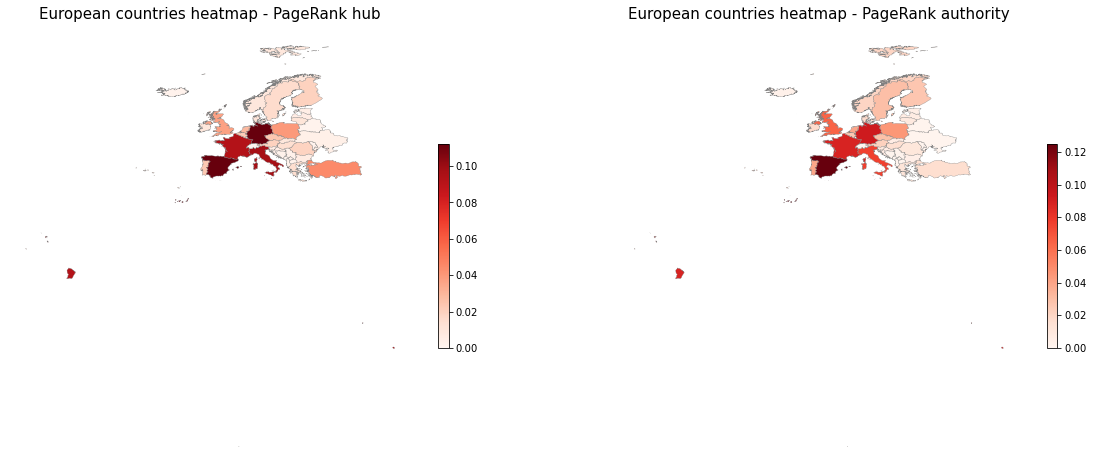

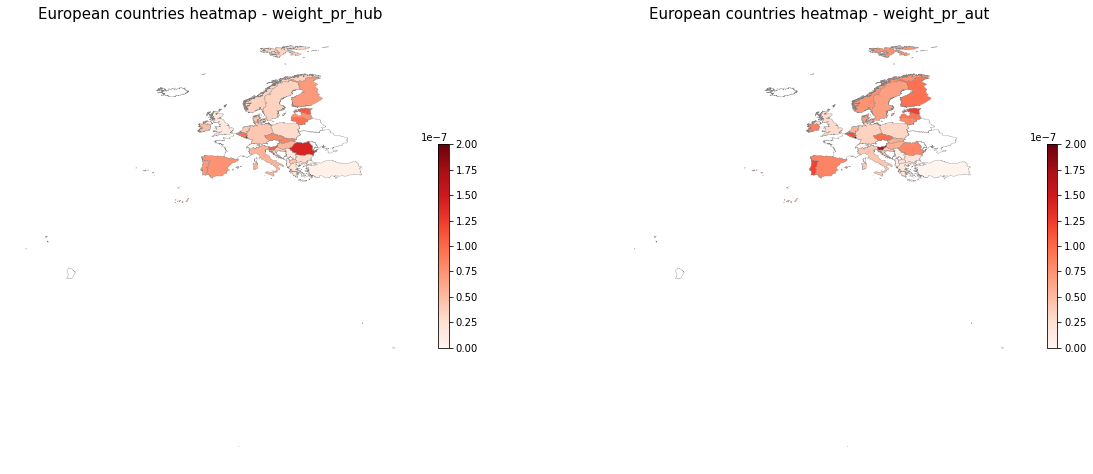

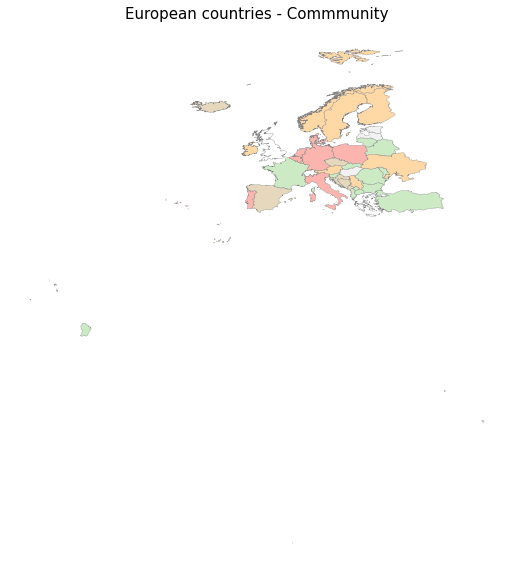

In [10]:
country_df = country19_df.append(country18_df)
country_df = country_df.append(country17_df)
country_df = country_df.append(country16_df)
country_df = country_df.append(country15_df)
country_df = country_df.append(country14_df)
analysis(country_df)